In [ ]:
#Import all libraries
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import math
import numpy as np
import string
import inflect

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import TextBlob
from tqdm import tqdm  # For progress bar

In [ ]:
#Init function

#======Data Statistic======
def text_statistics(text_data):
  # Initialize variables
  total_words = 0
  unique_words = set()
  total_chars = 0
  document_lengths = []
  longest_word = 0
  longest_document = ""
  shortest_word = 999999
  shortest_document = ""

  # Loop through each document
  for document in text_data:
    # Split document into words
    words = document.split()

    # Update document length statistics
    document_lengths.append(len(words))

    # Update word and character statistics
    total_words += len(words)
    unique_words.update(words)
    total_chars += sum(len(word) for word in words)
    
    #Calculate maximum and minimum word
    if(len(words)>longest_word):
        longest_word = len(words)
        longest_document = document
        
    if(len(words)<shortest_word):
        shortest_word = len(words)
        shortest_document = document

  # Calculate statistics
  avg_document_length = sum(document_lengths) / len(document_lengths)
  type_token_ratio = len(unique_words) / total_words
  avg_word_length = total_chars / total_words

  # Create and return the statistics dictionary
  statistics = {
      "avg_document_length": avg_document_length,
      "unique_words": len(unique_words),
      "total_words" : total_words,
      "type_token_ratio": type_token_ratio,
      "avg_word_length": avg_word_length,
      "longest_word_count": longest_word,
      "longest_document": longest_document,
      "shortest_word_count": shortest_word,
      "shortest_document": shortest_document
  }
  return statistics
#======End Data Statistic======

#======Case Folding======
def text_lowercase(text):
    return text.lower()
#======End Case Folding======

#======Tokenizing======
#func remove number
def remove_numbers_html_symbol(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]*>', '', text)
    
    # Remove symbols (excluding whitespace and alphabets)
    text = re.sub(r'[^\x00-\x7F]+', '', text) #old r'[^\w\s]'
    
    # Replace "-" with empty string if it's preceded or followed by a lowercase letter
    text = re.sub(r'(?<=[a-z])-(?=[a-z])', '', text)
    
    return text

# remove punctuation
def remove_punctuation(text):
    #Added this to remove if punctuation dont use space in text
    text = text.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation})) 
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

#remove whitespace leading & trailing
def remove_whitespace_leading_trailing(text):
    return text.strip()

#remove multiple whitespace into single whitespace
def remove_multiple_whitespace(text):
    return re.sub('\s+',' ',text)

def tokenize(text):
    return word_tokenize(text)
#======End Tokenizing======

#======Filtering====== 
# remove stopwords
def remove_stopwords(word_tokens):
    stop_words = set(stopwords.words("indonesian"))
    filtered_text = []
    for word in word_tokens: 
        if word not in stop_words:
            filtered_text.append(word)
    
    return filtered_text
#======Filtering======

#======Stemming======
#Init stem cache to skip slow process
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stem_cache = {}
def stemming(text):
    if text in stem_cache:
        return stem_cache[text]
    else:
        stem = stemmer.stem(text)
        stem_cache[text] = stem
        return stem
#======End Stemming======

#======Preprocess======
def preprocess_text(text_dataset):
    text_casefold = text_lowercase(text_dataset)
    text_remove_number_html = remove_numbers_html_symbol(text_casefold)
    text_remove_punctuation = remove_punctuation(text_remove_number_html)
    text_remove_whitespace_leading_trailing = remove_whitespace_leading_trailing(text_remove_punctuation)
    text_remove_multiple_whitespace = remove_multiple_whitespace(text_remove_whitespace_leading_trailing)
    text_tokenize = tokenize(text_remove_multiple_whitespace)
    text_remove_stopwords = remove_stopwords(text_tokenize)
    text_stemming = stemming(" ".join(text_remove_stopwords))           
    
    return text_stemming;
#======End Preprocess======

#======Classification======
def classification(data, train_index, test_index, index_loop):
    # Initialize variables for evaluation metrics
    accuracy_scores = []
    precision_scores = {name: [] for name in target_class}
    recall_scores = {name: [] for name in target_class}
    f1_scores = []
    processing_times = []
    
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Feature extraction using TF-IDF
    vectorizer = TfidfVectorizer()  # Adjust max_features as needed
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Convert TF-IDF sparse matrix to dense numpy array
    X_train_dense = X_train_tfidf.toarray()
    X_test_dense = X_test_tfidf.toarray()

    # Classification with MultinomialNB, BernoulliNB, and GaussianNB
    for clf_name, clf in [
        ("MultinomialNB", MultinomialNB()),
        ("BernoulliNB", BernoulliNB()),
        ("GaussianNB", GaussianNB()),
    ]:
        start_time = time.time()
        if clf_name == "GaussianNB":
            clf.fit(X_train_dense, y_train)
            predictions = clf.predict(X_test_dense)
        else:
            clf.fit(X_train_tfidf, y_train)
            predictions = clf.predict(X_test_tfidf)
            
        end_time = time.time()
        processing_time = end_time - start_time

        # Evaluation metrics
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average=None, zero_division=0)
        recall = recall_score(y_test, predictions, average=None, zero_division=0)
        f1 = f1_score(y_test, predictions, average=None, zero_division=0)
        
        #Macro Avg
        precision_avg_mac = precision_score(y_test, predictions, average="macro", zero_division=0)
        recall_avg_mac = recall_score(y_test, predictions, average="macro", zero_division=0)
        f1_avg_mac = f1_score(y_test, predictions, average="macro",zero_division=0)
        
        #Micro Avg
        precision_avg_mic = precision_score(y_test, predictions, average="micro", zero_division=0)
        recall_avg_mic = recall_score(y_test, predictions, average="micro", zero_division=0)
        f1_avg_mic = f1_score(y_test, predictions, average="micro",zero_division=0)
        
        #Weighted Avg
        precision_avg_weighted = precision_score(y_test, predictions, average="weighted", zero_division=0)
        recall_avg_weighted = recall_score(y_test, predictions, average="weighted", zero_division=0)
        f1_avg_weighted = f1_score(y_test, predictions, average="weighted",zero_division=0)
        
        cm = confusion_matrix(y_test, predictions)

        accuracy_scores.append(accuracy)
        for name, score in zip(target_class, precision):
            precision_scores[name].append(score)
        for name, score in zip(target_class, recall):
            recall_scores[name].append(score)
        f1_scores.append(f1)
        processing_times.append(processing_time)
        
        #Confusion matrix fold illustration
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, cmap="Blues")
        plt.title(f"Confusion Matrix - Fold {index_loop}")
        plt.colorbar()
        plt.xticks(range(len(target_class)), target_class, rotation=90)
        plt.yticks(range(len(target_class)), target_class)
        plt.tight_layout()
        plt.show()

        # Print detailed results for each fold and classifier (commented out for brevity)
        print("=========Fold : ", index_loop, "=========")
        print(f"Classifier: {clf_name}")
        print(f"Confusion Matrix:\n{cm}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-Score:", f1)
        print("Processing time", processing_time)
        print("=========Macro Average=========")
        print("Precision Macro Avg :", precision_avg_mac)
        print("Recall Macro Avg:", recall_avg_mac)
        print("F1-Score Macro Avg:", f1_avg_mac)
        print("=========Micro Average=========")
        print("Precision Micro Avg:", precision_avg_mic)
        print("Recall Micro Avg:", recall_avg_mic)
        print("F1-Score Micro Avg:", f1_avg_mic)
        print("=========Weighted Average=========")
        print("Precision Weighted Avg:", precision_avg_weighted)
        print("Recall Weighted Avg:", recall_avg_weighted)
        print("F1-Score Weighted Avg:", f1_avg_weighted)
        print("\n")
#======End Classification======

#======Count Classes========
def count_classes(subset, name):
    counts = subset["kategori_jenis"].value_counts()
    print(f"==== COUNT CLASS {name} ====")
    for cls in target_class:
        print(f"{cls}: {counts.get(cls, 0)}")
    print()

In [ ]:
# Load data from CSV file
data = pd.read_excel("pengaduan_kota_denpasar.xlsx")

#get data len
num_rows = len(data["deskripsi"])

#Get data by 25%
deskripsi_25 = data["deskripsi"].iloc[:int(num_rows * 0.25)].astype(str)

#Get data by 50%
deskripsi_50 = data["deskripsi"].iloc[:int(num_rows * 0.50)].astype(str)

#Get data by 75%
deskripsi_75 = data["deskripsi"].iloc[:int(num_rows * 0.75)].astype(str)

#Get deskripsi total
deskripsi_100 = data["deskripsi"].astype(str)

#Print All Deskripsi
print(f"======DESKRIPSI======")
print(f"Deskripsi Data 25% : \n {deskripsi_25}\n")
print(f"Deskripsi Data 50% : \n {deskripsi_50}\n")
print(f"Deskripsi Data 75% : \n {deskripsi_75}\n")
print(f"Deskripsi Data 100% : \n {deskripsi_100}\n")

# #get class
target_class = ["Apresiasi", "Informasi", "Keluhan", "Permohonan Informasi Publik (PPID)", "Pertanyaan", "Usul / Saran"]
y = data["kategori_jenis"]

======DESKRIPSI======
Deskripsi Data 25% : 
 0       Motor saya samsat di Negara, ortu bayar pajak,...
1       Banjir di jl Bumiayu Sanur. Mohon tindaklanjut...
2       Jalan jalan di kota dps kapan bisa mulus dan h...
3       Kenapa ya murid SD kelas 1 disuruh isi LKS sed...
4       jalan berlubang jebol ambles ke bawah di jalan...
                              ...                        
3781    Mohon untuk ditertibkan, RAMBO GYM yang berlok...
3782    dimohonkan kpd pihak yg terkait agar menambah ...
3783    Mohon bantuan untuk fogging di jl. Gunung Anda...
3784    mohon trafic light dari buluh indah ke mahendr...
3785    om swastyastu pak, bu....  tyang warga Denpasa...
Name: deskripsi, Length: 3786, dtype: object

Deskripsi Data 50% : 
 0       Motor saya samsat di Negara, ortu bayar pajak,...
1       Banjir di jl Bumiayu Sanur. Mohon tindaklanjut...
2       Jalan jalan di kota dps kapan bisa mulus dan h...
3       Kenapa ya murid SD kelas 1 disuruh isi LKS sed...
4       jalan be

In [10]:
# Get slices data
data_25 = data.iloc[:int(num_rows * 0.25)]
data_50 = data.iloc[:int(num_rows * 0.50)]
data_75 = data.iloc[:int(num_rows * 0.75)]
data_100 = data

# Count for each slice
count_class_25 = count_classes(data_25, "25%")
count_class_50 = count_classes(data_50, "50%")
count_class_75 = count_classes(data_75, "75%")
count_class_100 = count_classes(data_100, "100%")

==== COUNT CLASS 25% ====
Apresiasi: 0
Informasi: 239
Keluhan: 2695
Permohonan Informasi Publik (PPID): 0
Pertanyaan: 451
Usul / Saran: 401

==== COUNT CLASS 50% ====
Apresiasi: 0
Informasi: 476
Keluhan: 5646
Permohonan Informasi Publik (PPID): 1
Pertanyaan: 773
Usul / Saran: 677

==== COUNT CLASS 75% ====
Apresiasi: 13
Informasi: 676
Keluhan: 8828
Permohonan Informasi Publik (PPID): 13
Pertanyaan: 909
Usul / Saran: 921

==== COUNT CLASS 100% ====
Apresiasi: 16
Informasi: 856
Keluhan: 12206
Permohonan Informasi Publik (PPID): 78
Pertanyaan: 1000
Usul / Saran: 991



In [ ]:
#Data statistic total
statistics_25 = text_statistics(deskripsi_25)
statistics_50 = text_statistics(deskripsi_50)
statistics_75 = text_statistics(deskripsi_75)
statistics_100 = text_statistics(deskripsi_100)

print("======STATISTIC DATA======")
print(f"Statistic Data 25% : \n{statistics_25}\n")
print(f"Statistic Data 50% : \n{statistics_50}\n")
print(f"Statistic Data 75% : \n{statistics_75}\n")
print(f"Statistic Data 100% : \n{statistics_100}\n")

#Preprocess text
data_preprocess_25 = deskripsi_25.apply(preprocess_text)
data_preprocess_50 = deskripsi_50.apply(preprocess_text)
data_preprocess_75 = deskripsi_75.apply(preprocess_text)
data_preprocess_100 = deskripsi_100.apply(preprocess_text)

======STATISTIC DATA======
Statistic Data 25% : 
{'avg_document_length': 55.829635499207605, 'unique_words': 29843, 'total_words': 211371, 'type_token_ratio': 0.14118776937233585, 'avg_word_length': 5.904390857780869, 'longest_word_count': 1662, 'longest_document': 'Pak walikota saya mau mengadu,_x000D_\nPagi ini saya periksa/berobat ke puskesmas 3 denpasar utara,_x000D_\nAda beberapa hal yg harus di soroti, sbg warga bapak dari Salah satu banjar di desa peguyangan, saya amat sangat kecewa dengan pelayanan unit tersebut :_x000D_\n1. Jam operasional, pasien sudah ramai sejak jam 7 pagi, ada sekitar 30 org mengantre termasuk saya, dan saya datang jm 7.30 sepulang shift malam, tapi yg saya perhatikan, 30an org tersebut tidak satupun yg memegang nomer antrean, knp ? Ya betul, krn ketidak tahuan mreka akan prosedur tersebut . Knp tidak d beritahu/ d arahkan ? Padahal saya lihat juga staff puskesmas banyak yg lalu lalang, mebanten dll, tidak adakah rasa peduli di diri para staff itu ? Dirasa

======WORDCLOUD DATA======


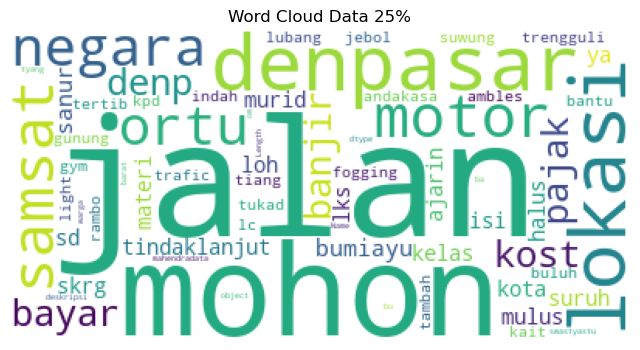

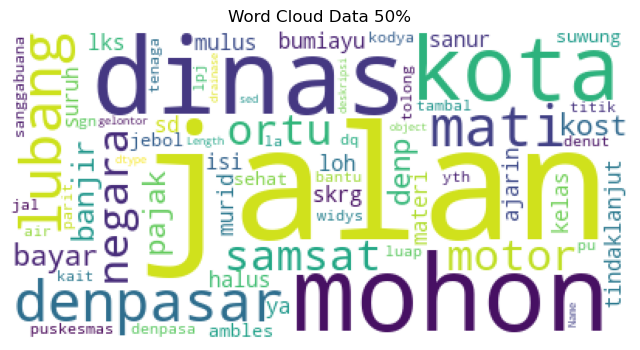

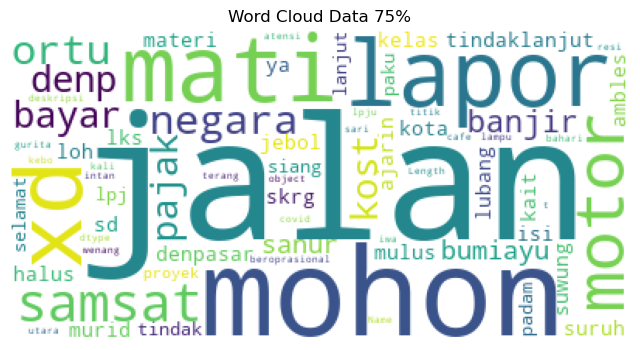

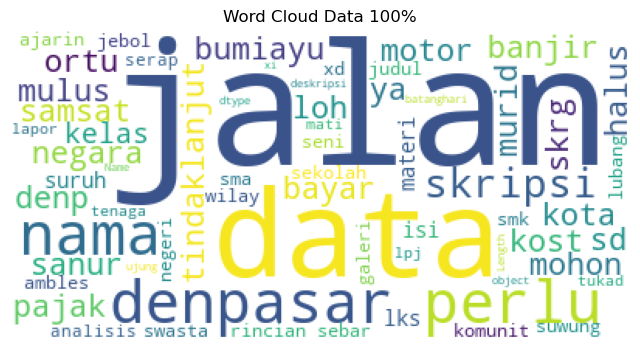

In [20]:
print("======WORDCLOUD DATA======")

#Create wordcloud from text data
wordcloud_25 = WordCloud(background_color="white").generate(str(data_preprocess_25))

# Create a figure and display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_25)
plt.axis("off")
plt.title("Word Cloud Data 25%")
plt.show()

#Create wordcloud from text data
wordcloud_50 = WordCloud(background_color="white").generate(str(data_preprocess_50))

# Create a figure and display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_50)
plt.axis("off")
plt.title("Word Cloud Data 50%")
plt.show()

#Create wordcloud from text data
wordcloud_75 = WordCloud(background_color="white").generate(str(data_preprocess_75))

# Create a figure and display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_75)
plt.axis("off")
plt.title("Word Cloud Data 75%")
plt.show()

#Create wordcloud from text data
wordcloud_100 = WordCloud(background_color="white").generate(str(data_preprocess_100))

# Create a figure and display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_100)
plt.axis("off")
plt.title("Word Cloud Data 100%")
plt.show()

In [21]:
#Init 5-fold cross-validation
kf5 = KFold(n_splits=5)  # Set random state for reproducibility

#Init 10-fold cross-validation
kf10 = KFold(n_splits=10)  # Set random state for reproducibility

======5-FOLD CROSS VALIDATION FOR 25% DATA======
K-Fold = 5
Data Deskripsi Array Len = 3786
Data Pre-process Array Len = 3786


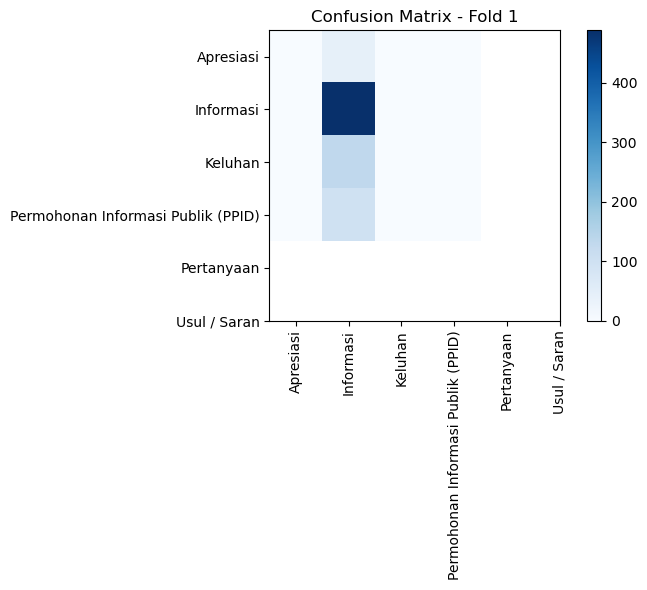

=========Fold :  1 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  41   0   0]
 [  0 488   0   0]
 [  0 130   0   0]
 [  0  99   0   0]]
Accuracy: 0.6437994722955145
Precision: [0.         0.64379947 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.78330658 0.         0.        ]
Processing time 0.010822296142578125
=========Macro Average=========
Precision Macro Avg : 0.16094986807387862
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.1958266452648475
=========Micro Average=========
Precision Micro Avg: 0.6437994722955145
Recall Micro Avg: 0.6437994722955145
F1-Score Micro Avg: 0.6437994722955145
=========Weighted Average=========
Precision Weighted Avg: 0.4144777605279829
Recall Weighted Avg: 0.6437994722955145
F1-Score Weighted Avg: 0.504292363531639




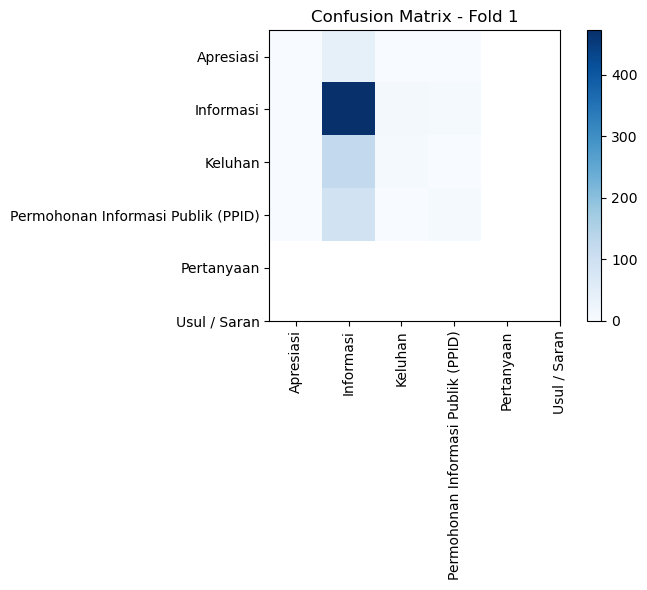

=========Fold :  1 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  40   1   0]
 [  0 472   9   7]
 [  0 123   7   0]
 [  0  91   1   7]]
Accuracy: 0.6411609498680739
Precision: [0.         0.65013774 0.38888889 0.5       ]
Recall: [0.         0.96721311 0.05384615 0.07070707]
F1-Score: [0.         0.77759473 0.09459459 0.12389381]
Processing time 0.0075609683990478516
=========Macro Average=========
Precision Macro Avg : 0.38475665748393023
Recall Macro Avg: 0.27294158482683073
F1-Score Macro Avg: 0.24902078201891592
=========Micro Average=========
Precision Micro Avg: 0.6411609498680739
Recall Micro Avg: 0.6411609498680739
F1-Score Micro Avg: 0.6411609498680739
=========Weighted Average=========
Precision Weighted Avg: 0.5505577482670311
Recall Weighted Avg: 0.6411609498680739
F1-Score Weighted Avg: 0.5330198039189608




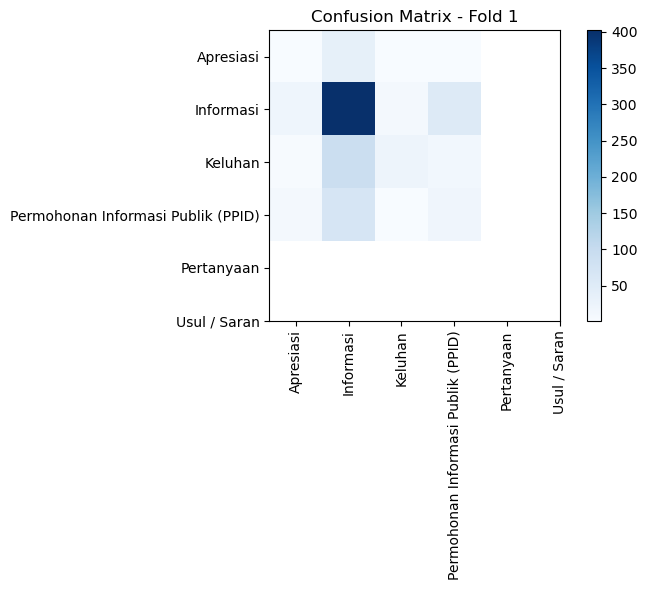

=========Fold :  1 =========
Classifier: GaussianNB
Confusion Matrix:
[[  2  35   2   2]
 [ 20 402  11  55]
 [  4  91  21  14]
 [  9  69   3  18]]
Accuracy: 0.5844327176781002
Precision: [0.05714286 0.67336683 0.56756757 0.20224719]
Recall: [0.04878049 0.82377049 0.16153846 0.18181818]
F1-Score: [0.05263158 0.74101382 0.25149701 0.19148936]
Processing time 0.7760751247406006
=========Macro Average=========
Precision Macro Avg : 0.37508111247312875
Recall Macro Avg: 0.30397690574120007
F1-Score Macro Avg: 0.30915794288057813
=========Micro Average=========
Precision Micro Avg: 0.5844327176781002
Recall Micro Avg: 0.5844327176781002
F1-Score Micro Avg: 0.5844327176781002
=========Weighted Average=========
Precision Weighted Avg: 0.560359007799644
Recall Weighted Avg: 0.5844327176781002
F1-Score Weighted Avg: 0.5480536924374336




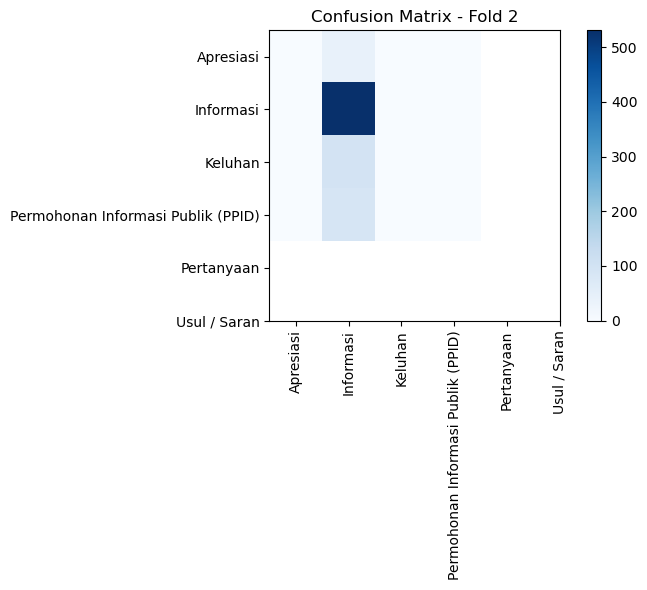

=========Fold :  2 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  41   0   0]
 [  0 531   0   0]
 [  0  97   0   0]
 [  0  88   0   0]]
Accuracy: 0.7014531043593131
Precision: [0.        0.7014531 0.        0.       ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.82453416 0.         0.        ]
Processing time 0.007910966873168945
=========Macro Average=========
Precision Macro Avg : 0.17536327608982827
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.20613354037267081
=========Micro Average=========
Precision Micro Avg: 0.7014531043593131
Recall Micro Avg: 0.7014531043593131
F1-Score Micro Avg: 0.7014531043593131
=========Weighted Average=========
Precision Weighted Avg: 0.4920364576153174
Recall Weighted Avg: 0.7014531043593131
F1-Score Weighted Avg: 0.5783720472279429




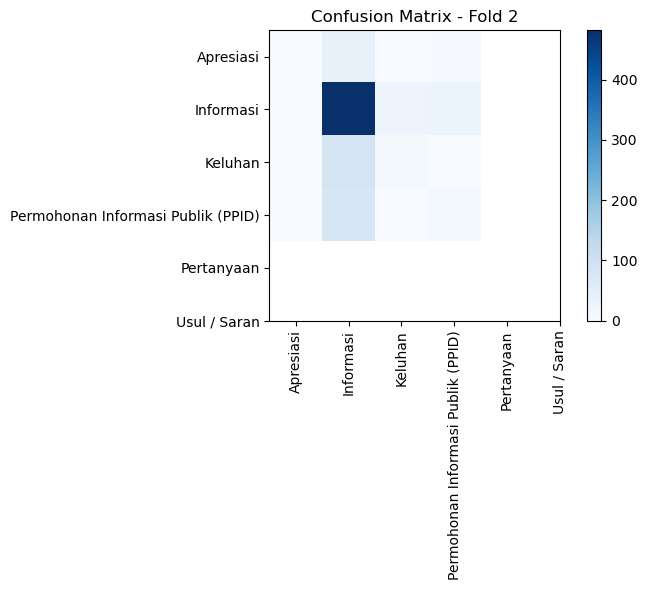

=========Fold :  2 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  39   0   2]
 [  0 482  23  26]
 [  0  86  10   1]
 [  0  76   1  11]]
Accuracy: 0.6644649933949802
Precision: [0.         0.7057101  0.29411765 0.275     ]
Recall: [0.         0.90772128 0.10309278 0.125     ]
F1-Score: [0.         0.79406919 0.15267176 0.171875  ]
Processing time 0.008136987686157227
=========Macro Average=========
Precision Macro Avg : 0.31870693738696065
Recall Macro Avg: 0.2839535160269478
F1-Score Macro Avg: 0.2796539871191066
=========Micro Average=========
Precision Micro Avg: 0.6644649933949802
Recall Micro Avg: 0.6644649933949802
F1-Score Micro Avg: 0.6644649933949802
=========Weighted Average=========
Precision Weighted Avg: 0.5646783040771135
Recall Weighted Avg: 0.6644649933949802
F1-Score Weighted Avg: 0.5965454447242399




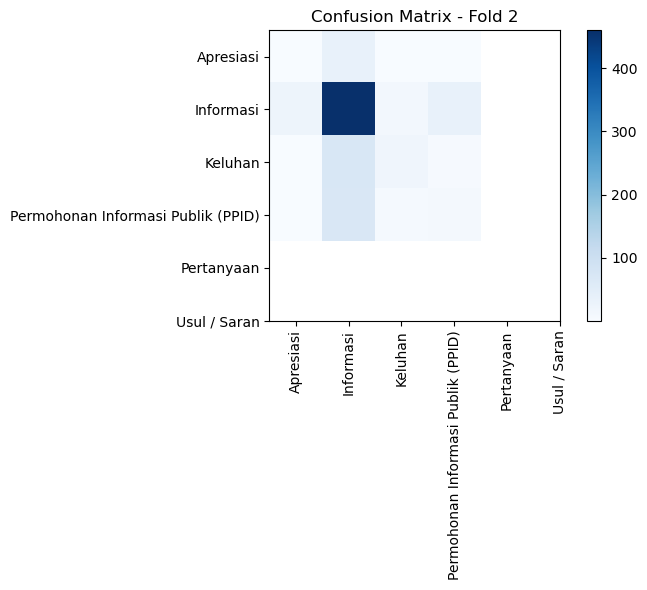

=========Fold :  2 =========
Classifier: GaussianNB
Confusion Matrix:
[[  2  36   2   1]
 [ 23 460  13  35]
 [  1  72  19   5]
 [  2  70   7   9]]
Accuracy: 0.6472919418758256
Precision: [0.07142857 0.72100313 0.46341463 0.18      ]
Recall: [0.04878049 0.86629002 0.19587629 0.10227273]
F1-Score: [0.05797101 0.78699743 0.27536232 0.13043478]
Processing time 0.7139692306518555
=========Macro Average=========
Precision Macro Avg : 0.35896158509278775
Recall Macro Avg: 0.30330488064244776
F1-Score Macro Avg: 0.3126913874115123
=========Micro Average=========
Precision Micro Avg: 0.6472919418758256
Recall Micro Avg: 0.6472919418758256
F1-Score Micro Avg: 0.6472919418758256
=========Weighted Average=========
Precision Weighted Avg: 0.5899239835106592
Recall Weighted Avg: 0.6472919418758256
F1-Score Weighted Avg: 0.6056286059288496




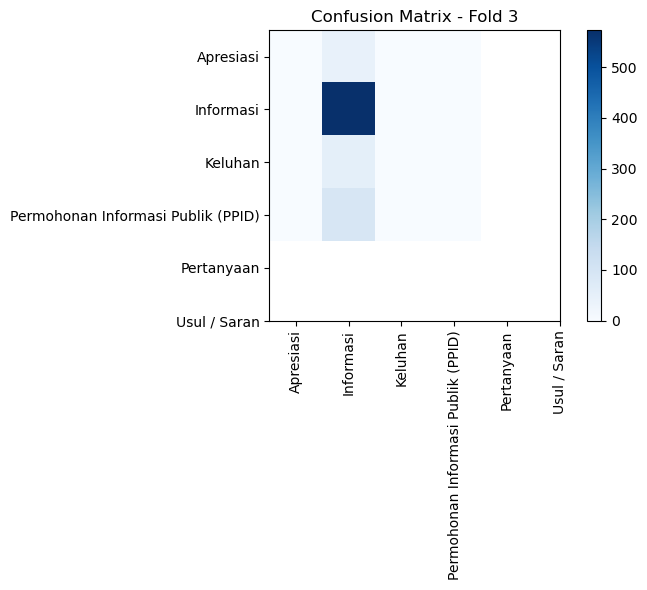

=========Fold :  3 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  41   0   0]
 [  0 573   0   0]
 [  0  53   0   0]
 [  0  90   0   0]]
Accuracy: 0.7569352708058125
Precision: [0.         0.75693527 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.86165414 0.         0.        ]
Processing time 0.008887052536010742
=========Macro Average=========
Precision Macro Avg : 0.18923381770145312
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2154135338345865
=========Micro Average=========
Precision Micro Avg: 0.7569352708058125
Recall Micro Avg: 0.7569352708058125
F1-Score Micro Avg: 0.7569352708058125
=========Weighted Average=========
Precision Weighted Avg: 0.5729510041898687
Recall Weighted Avg: 0.7569352708058125
F1-Score Weighted Avg: 0.6522164062732791




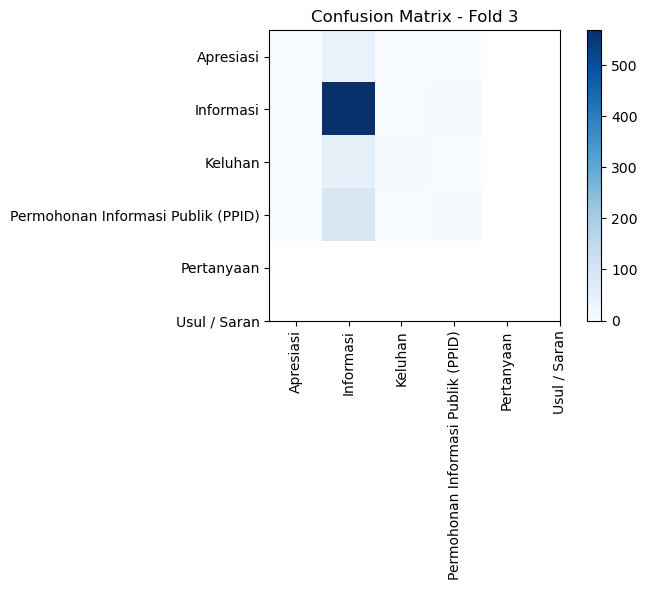

=========Fold :  3 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  38   1   2]
 [  0 568   0   5]
 [  0  48   5   0]
 [  0  86   1   3]]
Accuracy: 0.760898282694848
Precision: [0.         0.76756757 0.71428571 0.3       ]
Recall: [0.         0.991274   0.09433962 0.03333333]
F1-Score: [0.         0.86519421 0.16666667 0.06      ]
Processing time 0.00869297981262207
=========Macro Average=========
Precision Macro Avg : 0.4454633204633205
Recall Macro Avg: 0.2797367381211104
F1-Score Macro Avg: 0.272965219598883
=========Micro Average=========
Precision Micro Avg: 0.760898282694848
Recall Micro Avg: 0.760898282694848
F1-Score Micro Avg: 0.760898282694848
=========Weighted Average=========
Precision Weighted Avg: 0.6666755073624294
Recall Weighted Avg: 0.760898282694848
F1-Score Weighted Avg: 0.6736983046948125




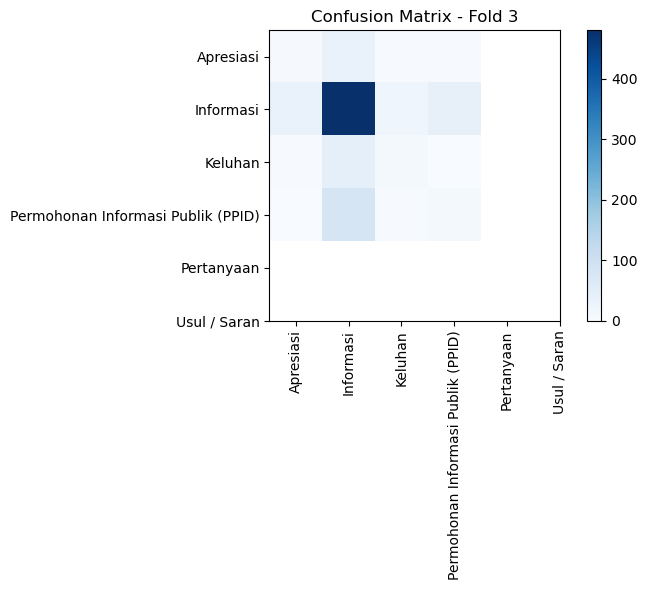

=========Fold :  3 =========
Classifier: GaussianNB
Confusion Matrix:
[[  4  32   3   2]
 [ 33 480  22  38]
 [  2  43   8   0]
 [  0  79   3   8]]
Accuracy: 0.6605019815059445
Precision: [0.1025641  0.75709779 0.22222222 0.16666667]
Recall: [0.09756098 0.83769634 0.1509434  0.08888889]
F1-Score: [0.1        0.7953604  0.17977528 0.11594203]
Processing time 0.729698896408081
=========Macro Average=========
Precision Macro Avg : 0.3121376958127747
Recall Macro Avg: 0.2937723989508985
F1-Score Macro Avg: 0.2977694268911456
=========Micro Average=========
Precision Micro Avg: 0.6605019815059445
Recall Micro Avg: 0.6605019815059445
F1-Score Micro Avg: 0.6605019815059445
=========Weighted Average=========
Precision Weighted Avg: 0.6140025636502265
Recall Weighted Avg: 0.6605019815059445
F1-Score Weighted Avg: 0.6338234879353898




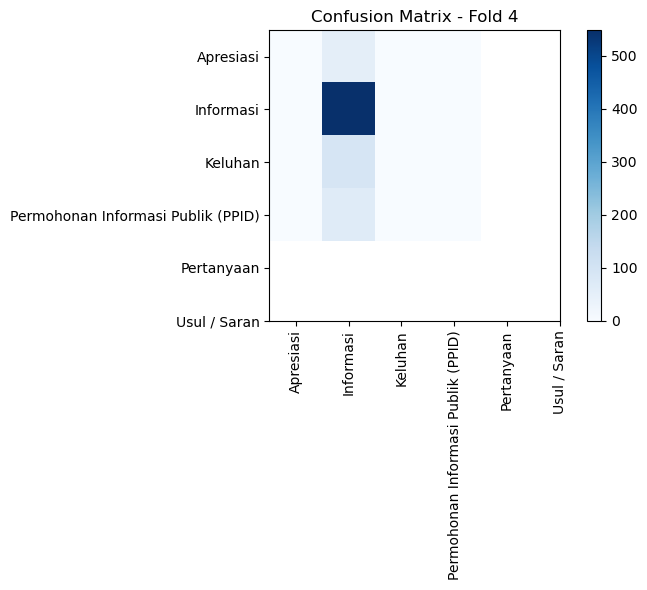

=========Fold :  4 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  53   0   0]
 [  0 548   0   0]
 [  0  90   0   0]
 [  0  66   0   0]]
Accuracy: 0.7239101717305152
Precision: [0.         0.72391017 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.83984674 0.         0.        ]
Processing time 0.007046937942504883
=========Macro Average=========
Precision Macro Avg : 0.1809775429326288
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2099616858237548
=========Micro Average=========
Precision Micro Avg: 0.7239101717305152
Recall Micro Avg: 0.7239101717305152
F1-Score Micro Avg: 0.7239101717305152
=========Weighted Average=========
Precision Weighted Avg: 0.524045936734904
Recall Weighted Avg: 0.7239101717305152
F1-Score Weighted Avg: 0.6079736001660112




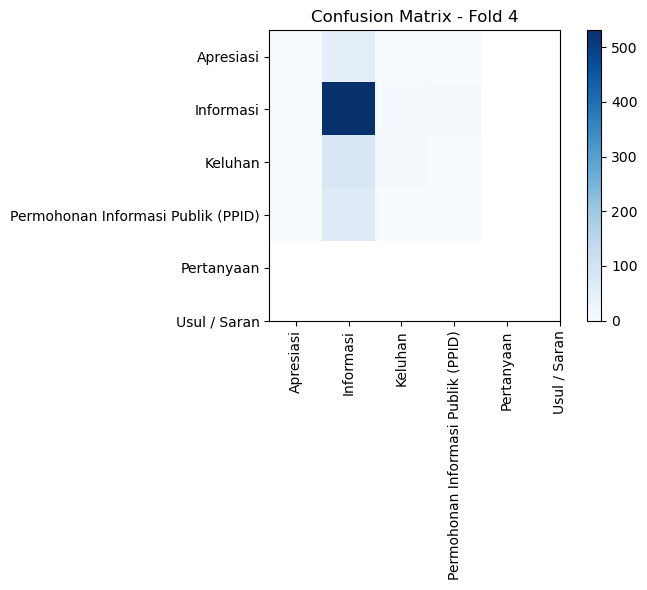

=========Fold :  4 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  51   1   1]
 [  0 531   8   9]
 [  0  80   9   1]
 [  0  64   0   2]]
Accuracy: 0.7159841479524438
Precision: [0.         0.73140496 0.5        0.15384615]
Recall: [0.         0.9689781  0.1        0.03030303]
F1-Score: [0.         0.83359498 0.16666667 0.05063291]
Processing time 0.00830388069152832
=========Macro Average=========
Precision Macro Avg : 0.34631277813095995
Recall Macro Avg: 0.27482028312320284
F1-Score Macro Avg: 0.26272363862779774
=========Micro Average=========
Precision Micro Avg: 0.7159841479524438
Recall Micro Avg: 0.7159841479524438
F1-Score Micro Avg: 0.7159841479524438
=========Weighted Average=========
Precision Weighted Avg: 0.6023299385854928
Recall Weighted Avg: 0.7159841479524438
F1-Score Weighted Avg: 0.6276774362584677




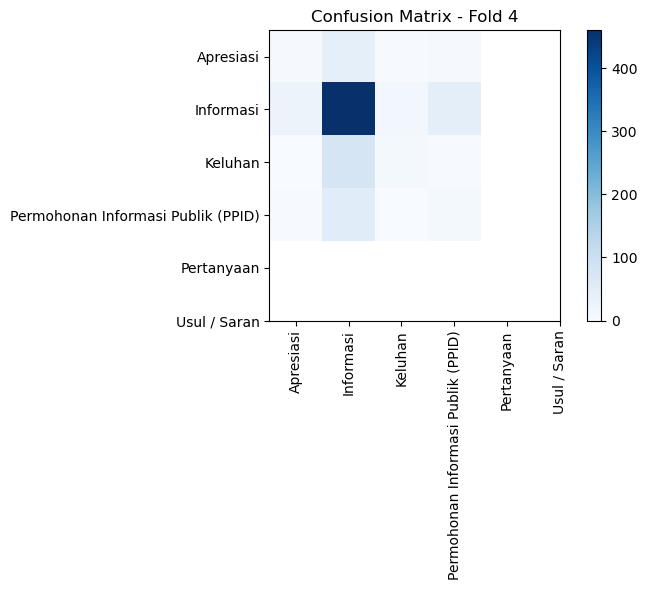

=========Fold :  4 =========
Classifier: GaussianNB
Confusion Matrix:
[[  5  42   2   4]
 [ 28 460  14  46]
 [  1  78   9   2]
 [  3  53   0  10]]
Accuracy: 0.6393659180977543
Precision: [0.13513514 0.72669826 0.36       0.16129032]
Recall: [0.09433962 0.83941606 0.1        0.15151515]
F1-Score: [0.11111111 0.77900085 0.15652174 0.15625   ]
Processing time 0.7040088176727295
=========Macro Average=========
Precision Macro Avg : 0.34578092998976656
Recall Macro Avg: 0.2963177081377054
F1-Score Macro Avg: 0.3007209242453992
=========Micro Average=========
Precision Micro Avg: 0.6393659180977543
Recall Micro Avg: 0.6393659180977543
F1-Score Micro Avg: 0.6393659180977543
=========Weighted Average=========
Precision Weighted Avg: 0.5923883370697561
Recall Weighted Avg: 0.6393659180977543
F1-Score Weighted Avg: 0.6039376610623195




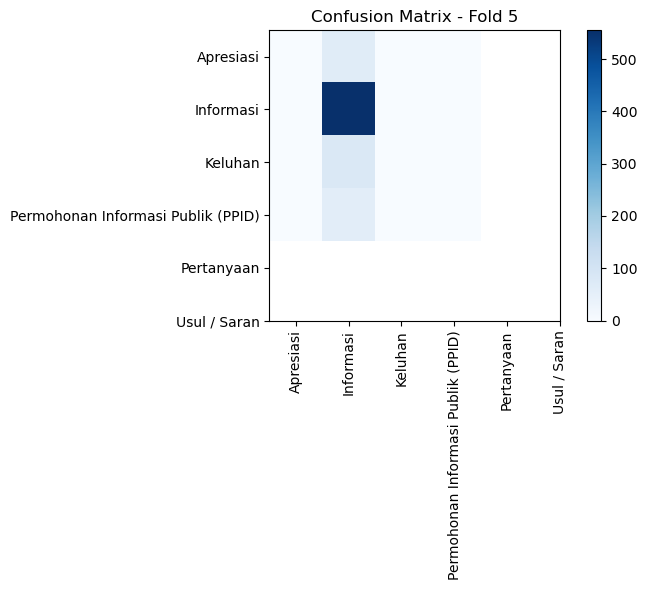

=========Fold :  5 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  63   0   0]
 [  0 555   0   0]
 [  0  81   0   0]
 [  0  58   0   0]]
Accuracy: 0.7331571994715984
Precision: [0.        0.7331572 0.        0.       ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.84603659 0.         0.        ]
Processing time 0.006651878356933594
=========Macro Average=========
Precision Macro Avg : 0.1832892998678996
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21150914634146342
=========Micro Average=========
Precision Micro Avg: 0.7331571994715984
Recall Micro Avg: 0.7331571994715984
F1-Score Micro Avg: 0.7331571994715984
=========Weighted Average=========
Precision Weighted Avg: 0.5375194791370371
Recall Weighted Avg: 0.7331571994715984
F1-Score Weighted Avg: 0.6202778135773432




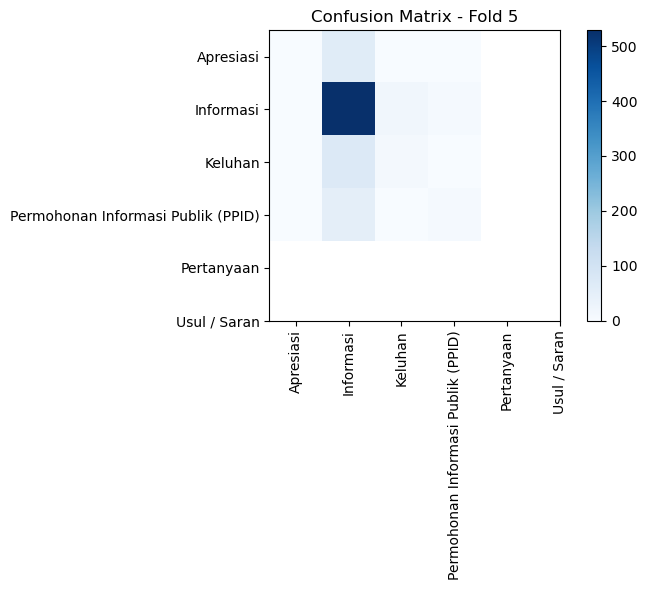

=========Fold :  5 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  60   2   1]
 [  0 529  18   8]
 [  0  71   9   1]
 [  0  51   0   7]]
Accuracy: 0.7199471598414795
Precision: [0.         0.7440225  0.31034483 0.41176471]
Recall: [0.         0.95315315 0.11111111 0.12068966]
F1-Score: [0.         0.835703   0.16363636 0.18666667]
Processing time 0.007697343826293945
=========Macro Average=========
Precision Macro Avg : 0.3665330092461836
Recall Macro Avg: 0.2962384798591695
F1-Score Macro Avg: 0.2965015079707023
=========Micro Average=========
Precision Micro Avg: 0.7199471598414795
Recall Micro Avg: 0.7199471598414795
F1-Score Micro Avg: 0.7199471598414795
=========Weighted Average=========
Precision Weighted Avg: 0.6102414444215799
Recall Weighted Avg: 0.7199471598414795
F1-Score Weighted Avg: 0.6445130488744906




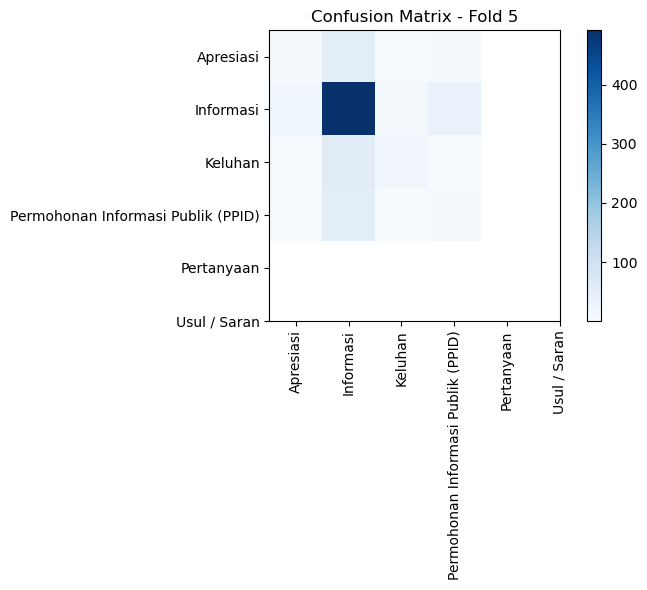

=========Fold :  5 =========
Classifier: GaussianNB
Confusion Matrix:
[[  5  48   4   6]
 [ 19 492  10  34]
 [  3  56  18   4]
 [  1  48   2   7]]
Accuracy: 0.6895640686922061
Precision: [0.17857143 0.76397516 0.52941176 0.1372549 ]
Recall: [0.07936508 0.88648649 0.22222222 0.12068966]
F1-Score: [0.10989011 0.8206839  0.31304348 0.12844037]
Processing time 0.7687070369720459
=========Macro Average=========
Precision Macro Avg : 0.40230331262939956
Recall Macro Avg: 0.32719086081155047
F1-Score Macro Avg: 0.3430144645940417
=========Micro Average=========
Precision Micro Avg: 0.6895640686922061
Recall Micro Avg: 0.6895640686922061
F1-Score Micro Avg: 0.6895640686922061
=========Weighted Average=========
Precision Weighted Avg: 0.6421391657001667
Recall Weighted Avg: 0.6895640686922061
F1-Score Weighted Avg: 0.6541726634767046


======10-FOLD CROSS VALIDATION FOR 25% DATA======
K-Fold = 10
Data Deskripsi Array Len = 3786
Data Pre-process Array Len = 3786


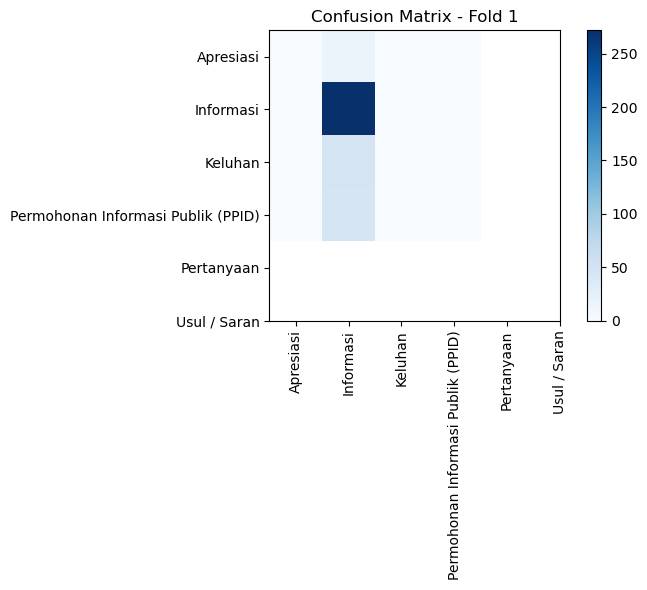

=========Fold :  1 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  14   0   0]
 [  0 272   0   0]
 [  0  47   0   0]
 [  0  46   0   0]]
Accuracy: 0.7176781002638523
Precision: [0.        0.7176781 0.        0.       ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.83563748 0.         0.        ]
Processing time 0.007676839828491211
=========Macro Average=========
Precision Macro Avg : 0.17941952506596306
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2089093701996928
=========Micro Average=========
Precision Micro Avg: 0.7176781002638523
Recall Micro Avg: 0.7176781002638523
F1-Score Micro Avg: 0.7176781002638523
=========Weighted Average=========
Precision Weighted Avg: 0.515061855598332
Recall Weighted Avg: 0.7176781002638523
F1-Score Weighted Avg: 0.5997187197289334




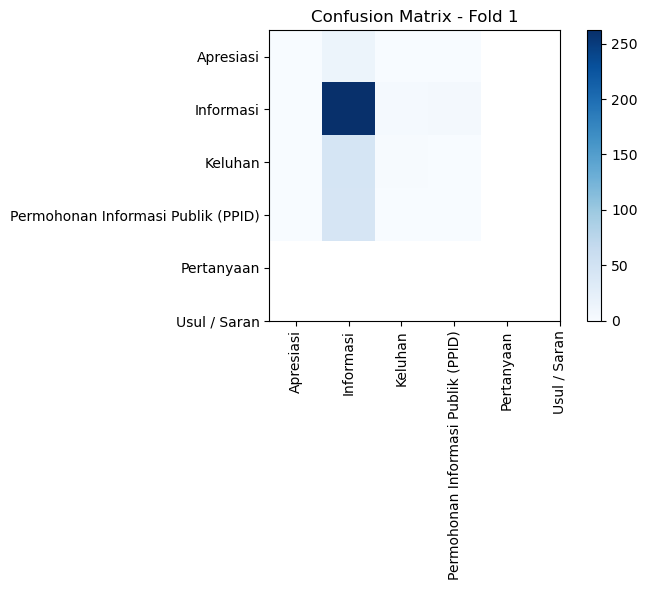

=========Fold :  1 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  14   0   0]
 [  0 262   4   6]
 [  0  45   2   0]
 [  0  44   1   1]]
Accuracy: 0.6992084432717678
Precision: [0.         0.71780822 0.28571429 0.14285714]
Recall: [0.         0.96323529 0.04255319 0.02173913]
F1-Score: [0.         0.82260597 0.07407407 0.03773585]
Processing time 0.008858203887939453
=========Macro Average=========
Precision Macro Avg : 0.2865949119373777
Recall Macro Avg: 0.25688190401044786
F1-Score Macro Avg: 0.23360397214844655
=========Micro Average=========
Precision Micro Avg: 0.6992084432717678
Recall Micro Avg: 0.6992084432717678
F1-Score Micro Avg: 0.6992084432717678
=========Weighted Average=========
Precision Weighted Avg: 0.5679256876423175
Recall Weighted Avg: 0.6992084432717678
F1-Score Weighted Avg: 0.6041323301953845




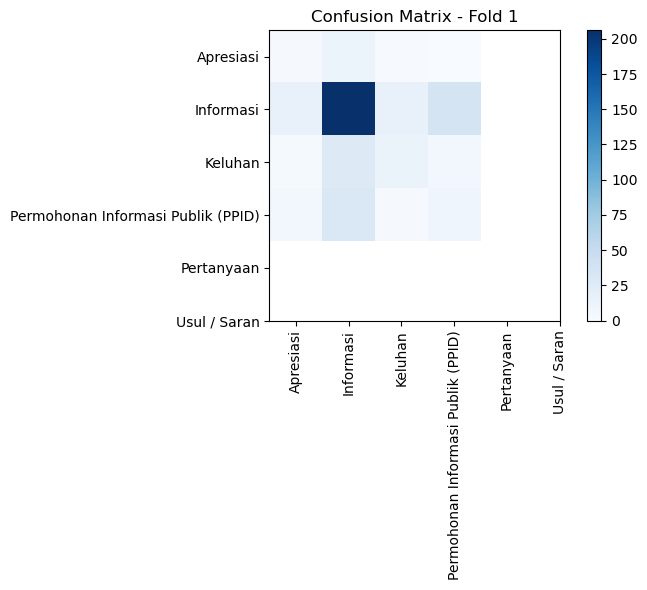

=========Fold :  1 =========
Classifier: GaussianNB
Confusion Matrix:
[[  2  11   1   0]
 [ 15 206  15  36]
 [  3  26  13   5]
 [  6  29   2   9]]
Accuracy: 0.6068601583113457
Precision: [0.07692308 0.75735294 0.41935484 0.18      ]
Recall: [0.14285714 0.75735294 0.27659574 0.19565217]
F1-Score: [0.1        0.75735294 0.33333333 0.1875    ]
Processing time 0.954747200012207
=========Macro Average=========
Precision Macro Avg : 0.3584077142023062
Recall Macro Avg: 0.343114500656877
F1-Score Macro Avg: 0.344546568627451
=========Micro Average=========
Precision Micro Avg: 0.6068601583113457
Recall Micro Avg: 0.6068601583113457
F1-Score Micro Avg: 0.6068601583113457
=========Weighted Average=========
Precision Weighted Avg: 0.6202284973516567
Recall Weighted Avg: 0.6068601583113457
F1-Score Weighted Avg: 0.6113236587510994




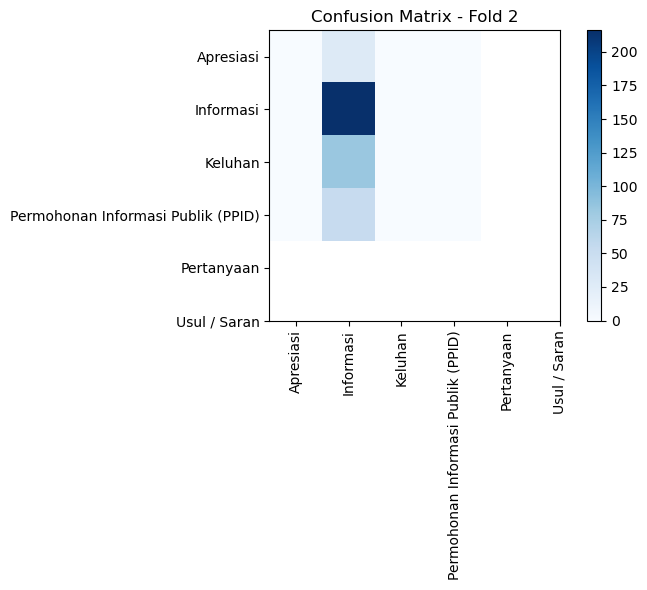

=========Fold :  2 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  27   0   0]
 [  0 216   0   0]
 [  0  83   0   0]
 [  0  53   0   0]]
Accuracy: 0.5699208443271768
Precision: [0.         0.56992084 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.72605042 0.         0.        ]
Processing time 0.0076029300689697266
=========Macro Average=========
Precision Macro Avg : 0.1424802110817942
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.18151260504201683
=========Micro Average=========
Precision Micro Avg: 0.5699208443271768
Recall Micro Avg: 0.5699208443271768
F1-Score Micro Avg: 0.5699208443271768
=========Weighted Average=========
Precision Weighted Avg: 0.32480976879860207
Recall Weighted Avg: 0.5699208443271768
F1-Score Weighted Avg: 0.4137912684862864




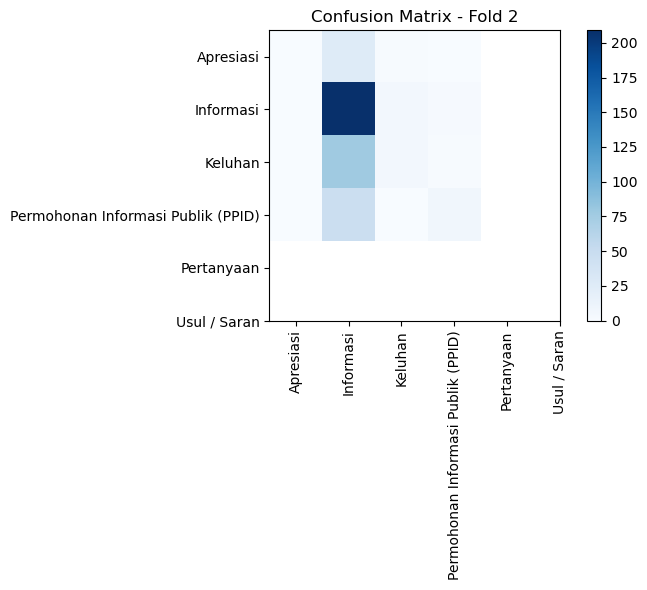

=========Fold :  2 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  26   1   0]
 [  0 209   5   2]
 [  0  77   5   1]
 [  0  46   0   7]]
Accuracy: 0.58311345646438
Precision: [0.         0.58379888 0.45454545 0.7       ]
Recall: [0.         0.96759259 0.06024096 0.13207547]
F1-Score: [0.         0.728223   0.10638298 0.22222222]
Processing time 0.008955001831054688
=========Macro Average=========
Precision Macro Avg : 0.43458608430675466
Recall Macro Avg: 0.2899772570365319
F1-Score Macro Avg: 0.2642070493653265
=========Micro Average=========
Precision Micro Avg: 0.58311345646438
Recall Micro Avg: 0.58311345646438
F1-Score Micro Avg: 0.58311345646438
=========Weighted Average=========
Precision Weighted Avg: 0.5301525894102654
Recall Weighted Avg: 0.58311345646438
F1-Score Weighted Avg: 0.4694029874913116




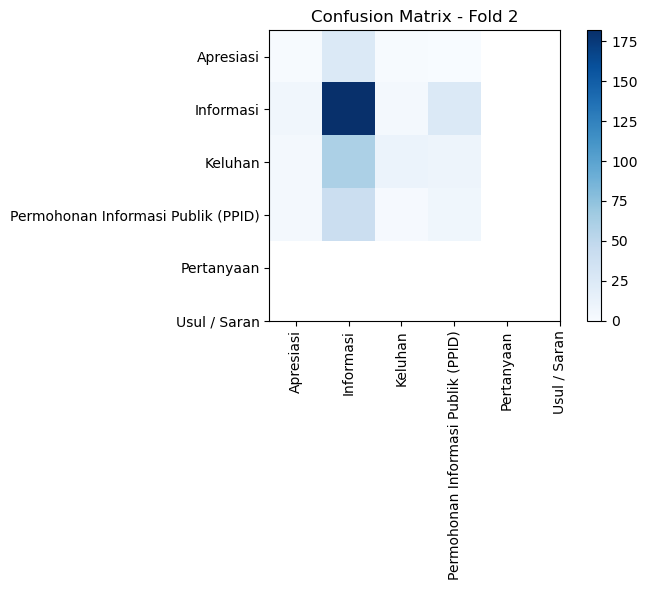

=========Fold :  2 =========
Classifier: GaussianNB
Confusion Matrix:
[[  1  25   1   0]
 [  6 182   3  25]
 [  3  60  11   9]
 [  3  41   2   7]]
Accuracy: 0.5303430079155673
Precision: [0.07692308 0.59090909 0.64705882 0.17073171]
Recall: [0.03703704 0.84259259 0.13253012 0.13207547]
F1-Score: [0.05       0.69465649 0.22       0.14893617]
Processing time 0.7285749912261963
=========Macro Average=========
Precision Macro Avg : 0.3714056746696632
Recall Macro Avg: 0.28605880545241763
F1-Score Macro Avg: 0.2783981646905961
=========Micro Average=========
Precision Micro Avg: 0.5303430079155673
Recall Micro Avg: 0.5303430079155673
F1-Score Micro Avg: 0.5303430079155673
=========Weighted Average=========
Precision Weighted Avg: 0.5078310014618279
Recall Weighted Avg: 0.5303430079155673
F1-Score Weighted Avg: 0.46846812281792644




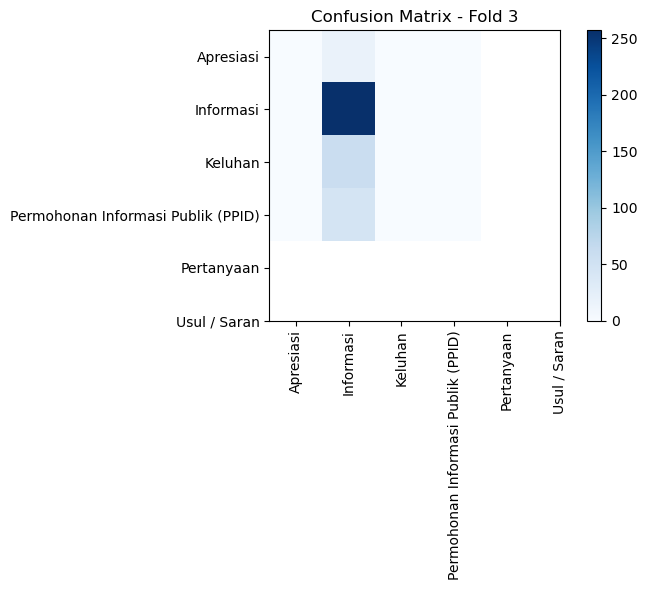

=========Fold :  3 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  17   0   0]
 [  0 257   0   0]
 [  0  59   0   0]
 [  0  46   0   0]]
Accuracy: 0.6781002638522428
Precision: [0.         0.67810026 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.        0.8081761 0.        0.       ]
Processing time 0.006772041320800781
=========Macro Average=========
Precision Macro Avg : 0.1695250659630607
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2020440251572327
=========Micro Average=========
Precision Micro Avg: 0.6781002638522428
Recall Micro Avg: 0.6781002638522428
F1-Score Micro Avg: 0.6781002638522428
=========Weighted Average=========
Precision Weighted Avg: 0.4598199678364812
Recall Weighted Avg: 0.6781002638522428
F1-Score Weighted Avg: 0.5480244270755547




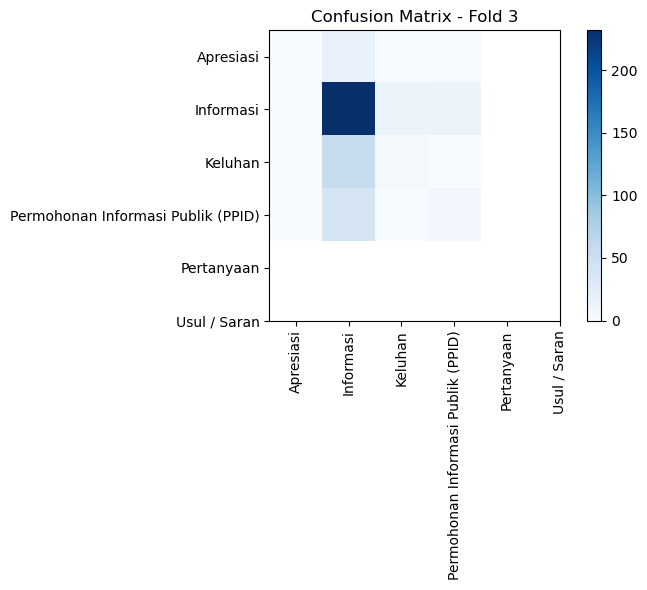

=========Fold :  3 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  16   0   1]
 [  0 232  12  13]
 [  0  55   4   0]
 [  0  40   0   6]]
Accuracy: 0.6385224274406333
Precision: [0.         0.67638484 0.25       0.3       ]
Recall: [0.         0.90272374 0.06779661 0.13043478]
F1-Score: [0.         0.77333333 0.10666667 0.18181818]
Processing time 0.008167028427124023
=========Macro Average=========
Precision Macro Avg : 0.30659620991253644
Recall Macro Avg: 0.2752387820466869
F1-Score Macro Avg: 0.26545454545454544
=========Micro Average=========
Precision Micro Avg: 0.6385224274406333
Recall Micro Avg: 0.6385224274406333
F1-Score Micro Avg: 0.6385224274406333
=========Weighted Average=========
Precision Weighted Avg: 0.5339865535358509
Recall Weighted Avg: 0.6385224274406333
F1-Score Weighted Avg: 0.5630702806428399




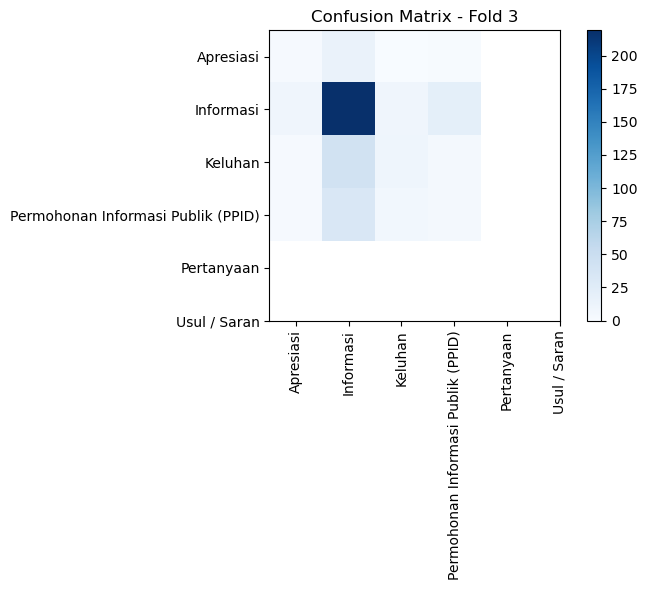

=========Fold :  3 =========
Classifier: GaussianNB
Confusion Matrix:
[[  2  14   0   1]
 [  9 219   9  20]
 [  2  42  10   5]
 [  2  33   6   5]]
Accuracy: 0.6226912928759895
Precision: [0.13333333 0.71103896 0.4        0.16129032]
Recall: [0.11764706 0.85214008 0.16949153 0.10869565]
F1-Score: [0.125      0.77522124 0.23809524 0.12987013]
Processing time 0.5802631378173828
=========Macro Average=========
Precision Macro Avg : 0.3514156542382349
Recall Macro Avg: 0.31199357856054577
F1-Score Macro Avg: 0.3170466517258553
=========Micro Average=========
Precision Micro Avg: 0.6226912928759895
Recall Micro Avg: 0.6226912928759895
F1-Score Micro Avg: 0.6226912928759895
=========Weighted Average=========
Precision Weighted Avg: 0.5699816213519507
Recall Weighted Avg: 0.6226912928759895
F1-Score Weighted Avg: 0.5841121462499331




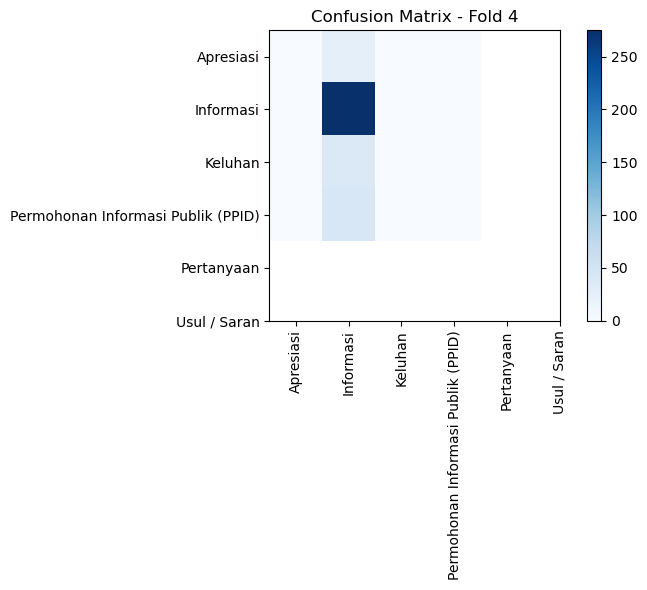

=========Fold :  4 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  24   0   0]
 [  0 275   0   0]
 [  0  38   0   0]
 [  0  42   0   0]]
Accuracy: 0.7255936675461742
Precision: [0.         0.72559367 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.84097859 0.         0.        ]
Processing time 0.00670313835144043
=========Macro Average=========
Precision Macro Avg : 0.18139841688654354
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2102446483180428
=========Micro Average=========
Precision Micro Avg: 0.7255936675461742
Recall Micro Avg: 0.7255936675461742
F1-Score Micro Avg: 0.7255936675461743
=========Weighted Average=========
Precision Weighted Avg: 0.5264861703831079
Recall Weighted Avg: 0.7255936675461742
F1-Score Weighted Avg: 0.6102087418201769




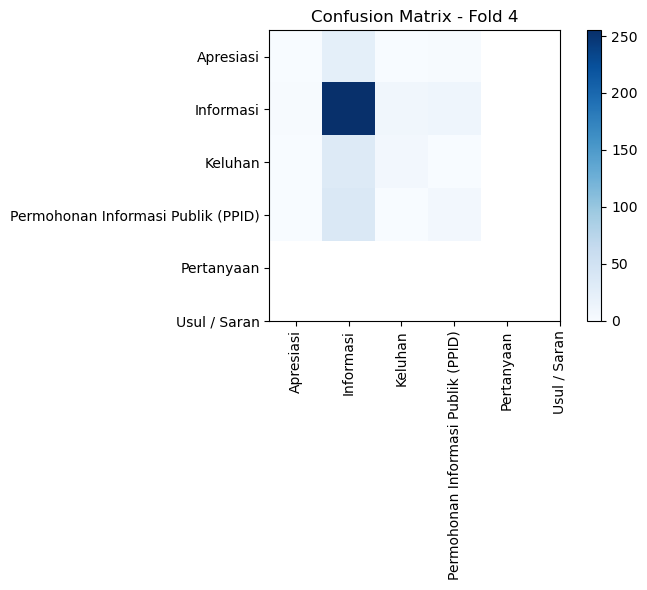

=========Fold :  4 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  23   0   1]
 [  1 255   8  11]
 [  0  32   6   0]
 [  0  36   0   6]]
Accuracy: 0.7044854881266491
Precision: [0.         0.73699422 0.42857143 0.33333333]
Recall: [0.         0.92727273 0.15789474 0.14285714]
F1-Score: [0.         0.82125604 0.23076923 0.2       ]
Processing time 0.008028984069824219
=========Macro Average=========
Precision Macro Avg : 0.37472474538948525
Recall Macro Avg: 0.30700615174299384
F1-Score Macro Avg: 0.3130063173541434
=========Micro Average=========
Precision Micro Avg: 0.7044854881266491
Recall Micro Avg: 0.7044854881266491
F1-Score Micro Avg: 0.7044854881266491
=========Weighted Average=========
Precision Weighted Avg: 0.6146678751723973
Recall Weighted Avg: 0.7044854881266491
F1-Score Weighted Avg: 0.6411995815230873




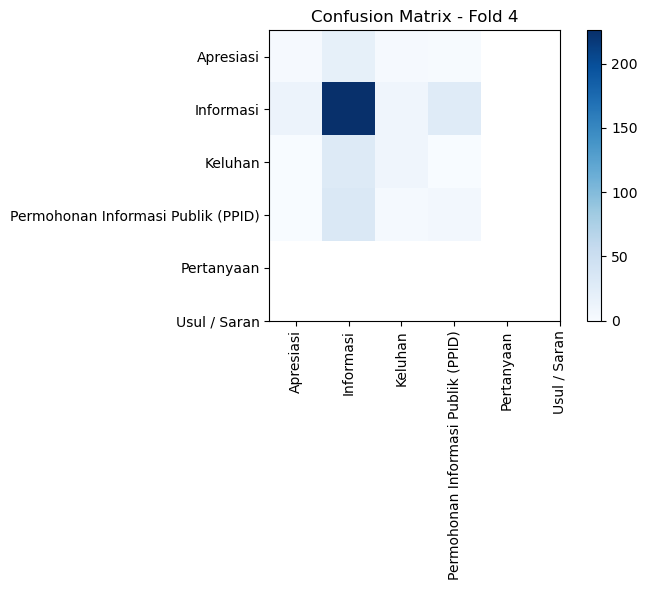

=========Fold :  4 =========
Classifier: GaussianNB
Confusion Matrix:
[[  2  19   2   1]
 [ 13 226   9  27]
 [  0  29   9   0]
 [  0  33   3   6]]
Accuracy: 0.6411609498680739
Precision: [0.13333333 0.73615635 0.39130435 0.17647059]
Recall: [0.08333333 0.82181818 0.23684211 0.14285714]
F1-Score: [0.1025641  0.7766323  0.29508197 0.15789474]
Processing time 0.5734241008758545
=========Macro Average=========
Precision Macro Avg : 0.35931615529656136
Recall Macro Avg: 0.32121269081795395
F1-Score Macro Avg: 0.3330432772562052
=========Micro Average=========
Precision Micro Avg: 0.6411609498680739
Recall Micro Avg: 0.6411609498680739
F1-Score Micro Avg: 0.6411609498680739
=========Weighted Average=========
Precision Weighted Avg: 0.6013834476674002
Recall Weighted Avg: 0.6411609498680739
F1-Score Weighted Avg: 0.6170979296161406




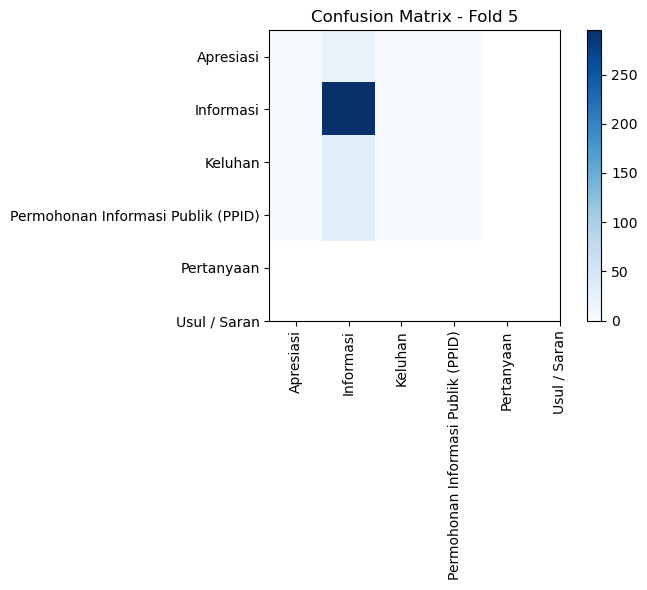

=========Fold :  5 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  20   0   0]
 [  0 295   0   0]
 [  0  32   0   0]
 [  0  32   0   0]]
Accuracy: 0.7783641160949868
Precision: [0.         0.77836412 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.87537092 0.         0.        ]
Processing time 0.0068018436431884766
=========Macro Average=========
Precision Macro Avg : 0.1945910290237467
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21884272997032642
=========Micro Average=========
Precision Micro Avg: 0.7783641160949868
Recall Micro Avg: 0.7783641160949868
F1-Score Micro Avg: 0.7783641160949868
=========Weighted Average=========
Precision Weighted Avg: 0.60585069722433
Recall Weighted Avg: 0.7783641160949868
F1-Score Weighted Avg: 0.681357312308668




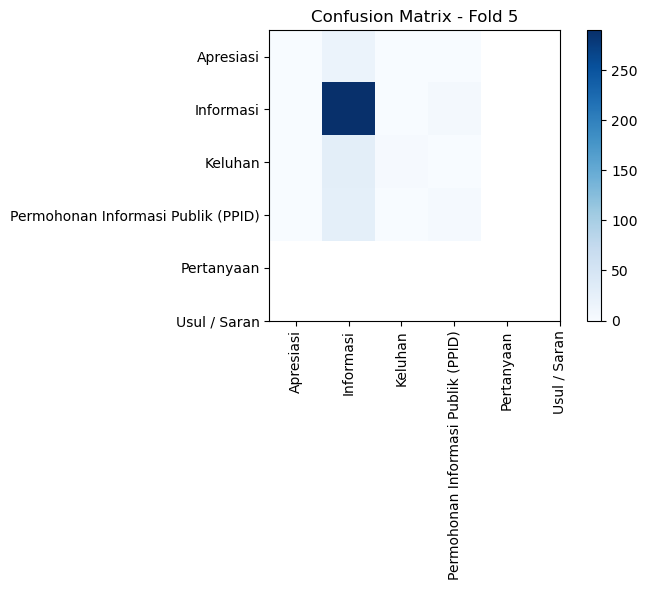

=========Fold :  5 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  18   1   1]
 [  0 290   0   5]
 [  0  29   3   0]
 [  0  27   1   4]]
Accuracy: 0.783641160949868
Precision: [0.        0.7967033 0.6       0.4      ]
Recall: [0.         0.98305085 0.09375    0.125     ]
F1-Score: [0.         0.8801214  0.16216216 0.19047619]
Processing time 0.007993221282958984
=========Macro Average=========
Precision Macro Avg : 0.44917582417582413
Recall Macro Avg: 0.3004502118644068
F1-Score Macro Avg: 0.3081899371732452
=========Micro Average=========
Precision Micro Avg: 0.783641160949868
Recall Micro Avg: 0.783641160949868
F1-Score Micro Avg: 0.783641160949868
=========Weighted Average=========
Precision Weighted Avg: 0.7045579750065236
Recall Weighted Avg: 0.783641160949868
F1-Score Weighted Avg: 0.7148291269671309




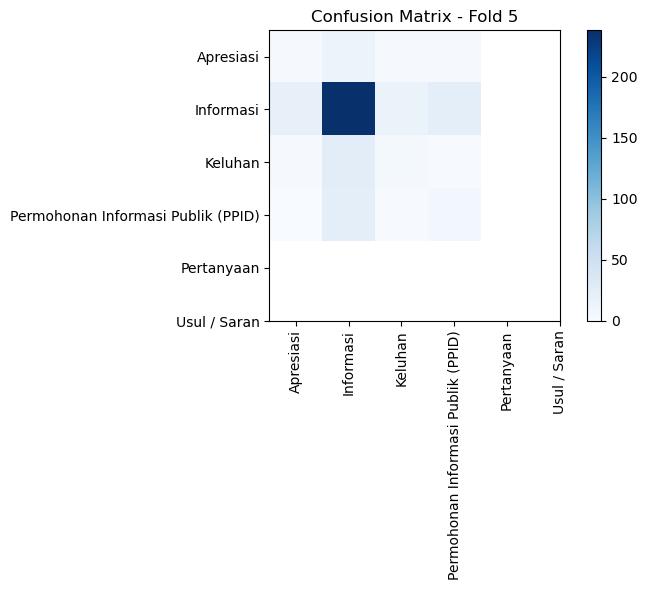

=========Fold :  5 =========
Classifier: GaussianNB
Confusion Matrix:
[[  2  14   2   2]
 [ 19 238  15  23]
 [  2  25   4   1]
 [  0  24   1   7]]
Accuracy: 0.662269129287599
Precision: [0.08695652 0.79069767 0.18181818 0.21212121]
Recall: [0.1        0.80677966 0.125      0.21875   ]
F1-Score: [0.09302326 0.79865772 0.14814815 0.21538462]
Processing time 0.6074931621551514
=========Macro Average=========
Precision Macro Avg : 0.3178983975242823
Recall Macro Avg: 0.3126324152542373
F1-Score Macro Avg: 0.3138034343668806
=========Micro Average=========
Precision Micro Avg: 0.662269129287599
Recall Micro Avg: 0.662269129287599
F1-Score Micro Avg: 0.662269129287599
=========Weighted Average=========
Precision Weighted Avg: 0.653300804734384
Recall Weighted Avg: 0.6622691292875991
F1-Score Weighted Avg: 0.6572494469524145




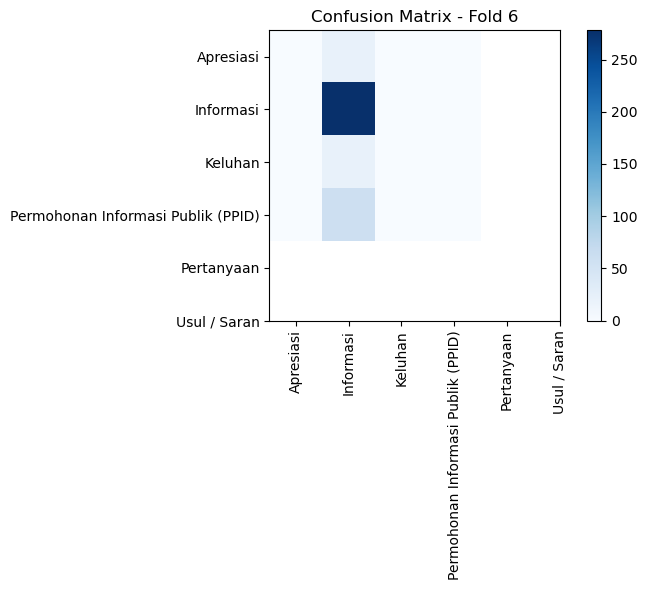

=========Fold :  6 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  21   0   0]
 [  0 278   0   0]
 [  0  21   0   0]
 [  0  59   0   0]]
Accuracy: 0.7335092348284961
Precision: [0.         0.73350923 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.84627093 0.         0.        ]
Processing time 0.00804591178894043
=========Macro Average=========
Precision Macro Avg : 0.18337730870712401
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21156773211567734
=========Micro Average=========
Precision Micro Avg: 0.7335092348284961
Recall Micro Avg: 0.7335092348284961
F1-Score Micro Avg: 0.7335092348284961
=========Weighted Average=========
Precision Weighted Avg: 0.5380357975786858
Recall Weighted Avg: 0.7335092348284961
F1-Score Weighted Avg: 0.6207475411942828




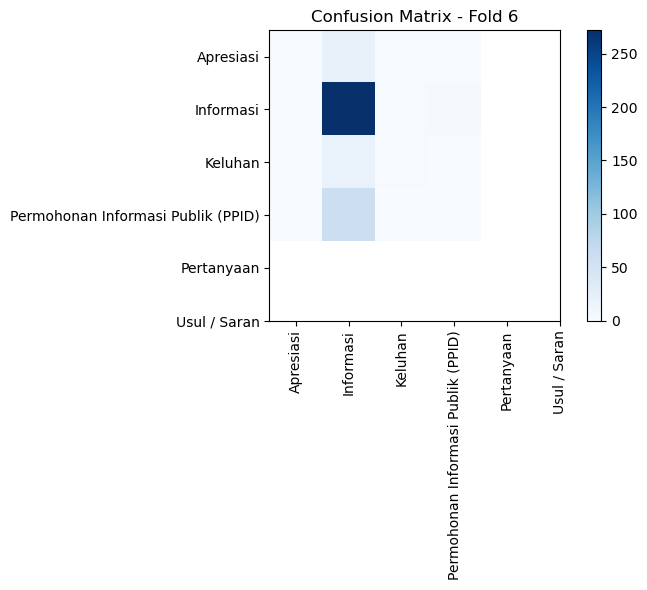

=========Fold :  6 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  20   0   1]
 [  0 272   2   4]
 [  0  19   2   0]
 [  0  59   0   0]]
Accuracy: 0.7229551451187335
Precision: [0.         0.73513514 0.5        0.        ]
Recall: [0.         0.97841727 0.0952381  0.        ]
F1-Score: [0.         0.83950617 0.16       0.        ]
Processing time 0.008562088012695312
=========Macro Average=========
Precision Macro Avg : 0.3087837837837838
Recall Macro Avg: 0.2684138403562864
F1-Score Macro Avg: 0.24987654320987657
=========Micro Average=========
Precision Micro Avg: 0.7229551451187335
Recall Micro Avg: 0.7229551451187335
F1-Score Micro Avg: 0.7229551451187334
=========Weighted Average=========
Precision Weighted Avg: 0.5669328959566428
Recall Weighted Avg: 0.7229551451187335
F1-Score Weighted Avg: 0.624650965829506




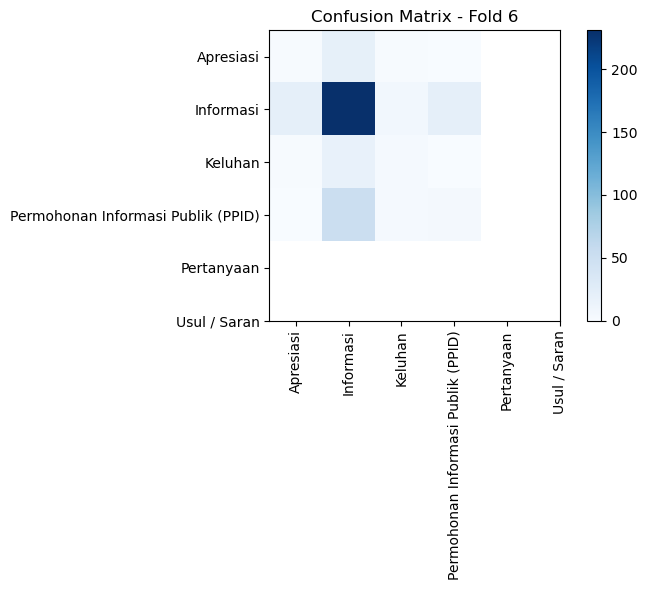

=========Fold :  6 =========
Classifier: GaussianNB
Confusion Matrix:
[[  1  19   1   0]
 [ 20 231   7  20]
 [  1  17   3   0]
 [  0  52   3   4]]
Accuracy: 0.6306068601583114
Precision: [0.04545455 0.72413793 0.21428571 0.16666667]
Recall: [0.04761905 0.83093525 0.14285714 0.06779661]
F1-Score: [0.04651163 0.77386935 0.17142857 0.09638554]
Processing time 0.6006872653961182
=========Macro Average=========
Precision Macro Avg : 0.2876362143603523
Recall Macro Avg: 0.2723020131110608
F1-Score Macro Avg: 0.2720487720594728
=========Micro Average=========
Precision Micro Avg: 0.6306068601583114
Recall Micro Avg: 0.6306068601583114
F1-Score Micro Avg: 0.6306068601583114
=========Weighted Average=========
Precision Weighted Avg: 0.5714992707532058
Recall Weighted Avg: 0.6306068601583115
F1-Score Weighted Avg: 0.5947207640262747




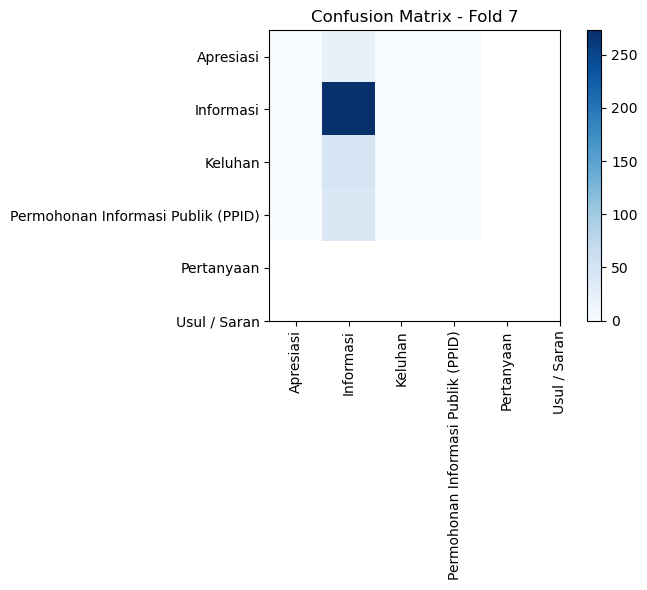

=========Fold :  7 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  21   0   0]
 [  0 273   0   0]
 [  0  45   0   0]
 [  0  39   0   0]]
Accuracy: 0.7222222222222222
Precision: [0.         0.72222222 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.83870968 0.         0.        ]
Processing time 0.006850004196166992
=========Macro Average=========
Precision Macro Avg : 0.18055555555555555
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2096774193548387
=========Micro Average=========
Precision Micro Avg: 0.7222222222222222
Recall Micro Avg: 0.7222222222222222
F1-Score Micro Avg: 0.7222222222222222
=========Weighted Average=========
Precision Weighted Avg: 0.5216049382716049
Recall Weighted Avg: 0.7222222222222222
F1-Score Weighted Avg: 0.6057347670250895




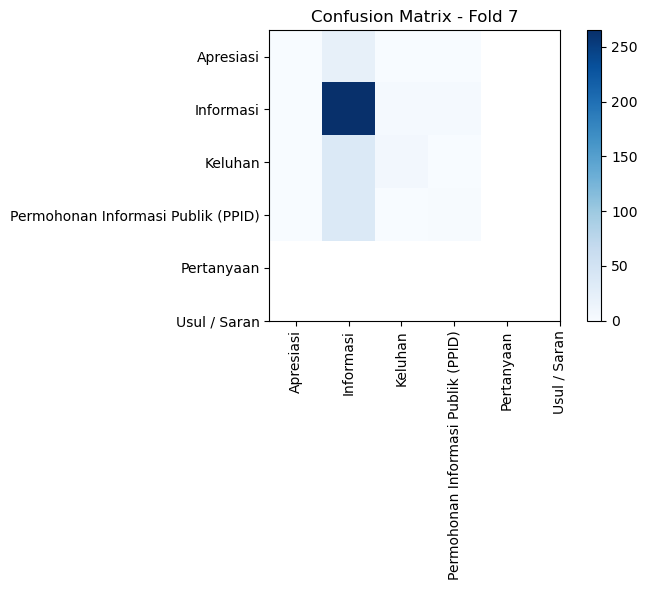

=========Fold :  7 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  21   0   0]
 [  0 265   4   4]
 [  0  37   7   1]
 [  0  37   0   2]]
Accuracy: 0.7248677248677249
Precision: [0.         0.73611111 0.63636364 0.28571429]
Recall: [0.         0.97069597 0.15555556 0.05128205]
F1-Score: [0.         0.83728278 0.25       0.08695652]
Processing time 0.008398056030273438
=========Macro Average=========
Precision Macro Avg : 0.41454725829725825
Recall Macro Avg: 0.2943833943833944
F1-Score Macro Avg: 0.29355982553746823
=========Micro Average=========
Precision Micro Avg: 0.7248677248677249
Recall Micro Avg: 0.7248677248677249
F1-Score Micro Avg: 0.7248677248677248
=========Weighted Average=========
Precision Weighted Avg: 0.6368718362765982
Recall Weighted Avg: 0.7248677248677249
F1-Score Weighted Avg: 0.6434378396824307




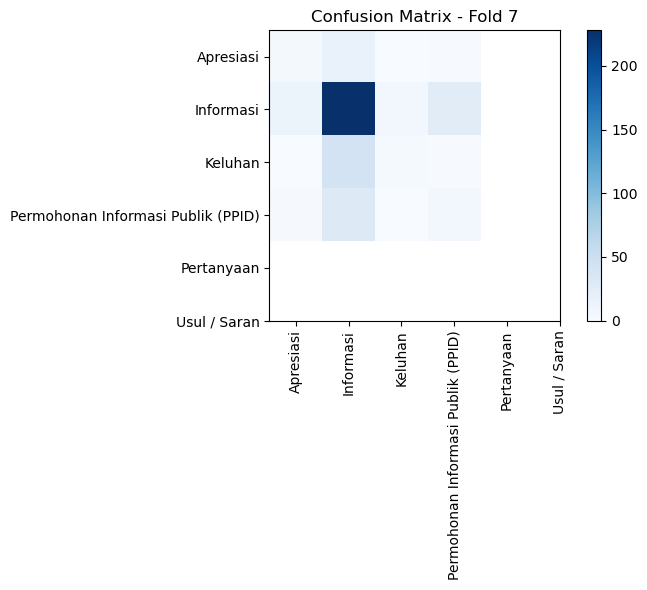

=========Fold :  7 =========
Classifier: GaussianNB
Confusion Matrix:
[[  4  16   0   1]
 [ 14 228   6  25]
 [  0  41   3   1]
 [  2  30   0   7]]
Accuracy: 0.6402116402116402
Precision: [0.2        0.72380952 0.33333333 0.20588235]
Recall: [0.19047619 0.83516484 0.06666667 0.17948718]
F1-Score: [0.19512195 0.7755102  0.11111111 0.19178082]
Processing time 0.7177777290344238
=========Macro Average=========
Precision Macro Avg : 0.3657563025210084
Recall Macro Avg: 0.31794871794871793
F1-Score Macro Avg: 0.31838102208251606
=========Micro Average=========
Precision Micro Avg: 0.6402116402116402
Recall Micro Avg: 0.6402116402116402
F1-Score Micro Avg: 0.6402116402116402
=========Weighted Average=========
Precision Weighted Avg: 0.594786803610333
Recall Weighted Avg: 0.6402116402116402
F1-Score Weighted Avg: 0.6039452347743122




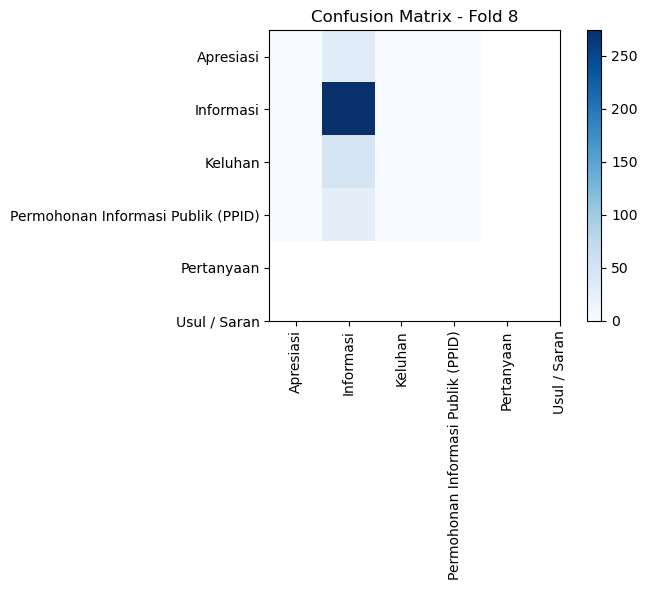

=========Fold :  8 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  32   0   0]
 [  0 274   0   0]
 [  0  45   0   0]
 [  0  27   0   0]]
Accuracy: 0.7248677248677249
Precision: [0.         0.72486772 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.        0.8404908 0.        0.       ]
Processing time 0.007652759552001953
=========Macro Average=========
Precision Macro Avg : 0.18121693121693122
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21012269938650308
=========Micro Average=========
Precision Micro Avg: 0.7248677248677249
Recall Micro Avg: 0.7248677248677249
F1-Score Micro Avg: 0.7248677248677248
=========Weighted Average=========
Precision Weighted Avg: 0.5254332185549117
Recall Weighted Avg: 0.7248677248677249
F1-Score Weighted Avg: 0.6092446521894375




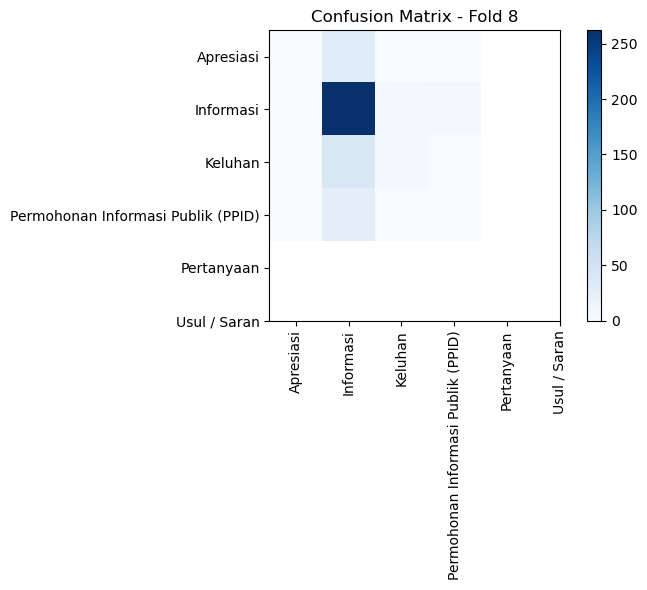

=========Fold :  8 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  30   1   1]
 [  0 262   5   7]
 [  0  39   6   0]
 [  0  27   0   0]]
Accuracy: 0.708994708994709
Precision: [0.         0.73184358 0.5        0.        ]
Recall: [0.         0.95620438 0.13333333 0.        ]
F1-Score: [0.         0.82911392 0.21052632 0.        ]
Processing time 0.01115274429321289
=========Macro Average=========
Precision Macro Avg : 0.30796089385474856
Recall Macro Avg: 0.2723844282238443
F1-Score Macro Avg: 0.25991005996002664
=========Micro Average=========
Precision Micro Avg: 0.708994708994709
Recall Micro Avg: 0.708994708994709
F1-Score Micro Avg: 0.708994708994709
=========Weighted Average=========
Precision Weighted Avg: 0.5900135969968372
Recall Weighted Avg: 0.708994708994709
F1-Score Weighted Avg: 0.6260605804243379




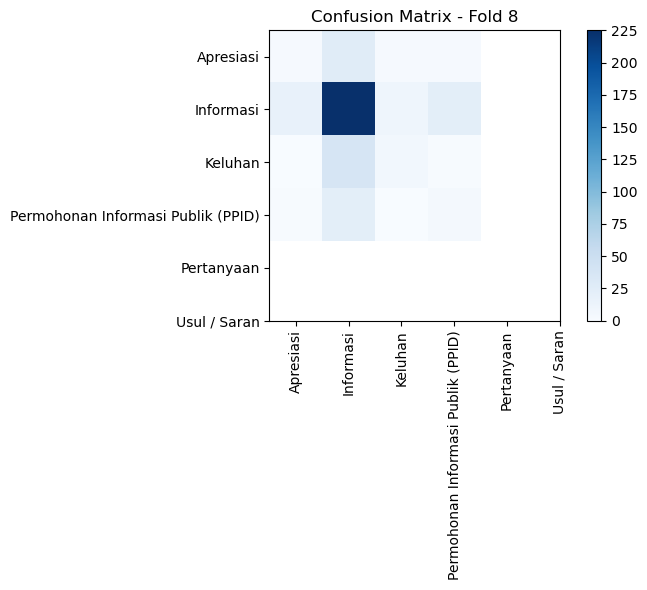

=========Fold :  8 =========
Classifier: GaussianNB
Confusion Matrix:
[[  2  26   2   2]
 [ 17 225  10  22]
 [  0  37   7   1]
 [  1  22   0   4]]
Accuracy: 0.6296296296296297
Precision: [0.1        0.72580645 0.36842105 0.13793103]
Recall: [0.0625     0.82116788 0.15555556 0.14814815]
F1-Score: [0.07692308 0.77054795 0.21875    0.14285714]
Processing time 0.7469711303710938
=========Macro Average=========
Precision Macro Avg : 0.3330396346818102
Recall Macro Avg: 0.2968428967288456
F1-Score Macro Avg: 0.3022695412464248
=========Micro Average=========
Precision Micro Avg: 0.6296296296296297
Recall Micro Avg: 0.6296296296296297
F1-Score Micro Avg: 0.6296296296296297
=========Weighted Average=========
Precision Weighted Avg: 0.5882911456121455
Recall Weighted Avg: 0.6296296296296297
F1-Score Weighted Avg: 0.6013030907539224




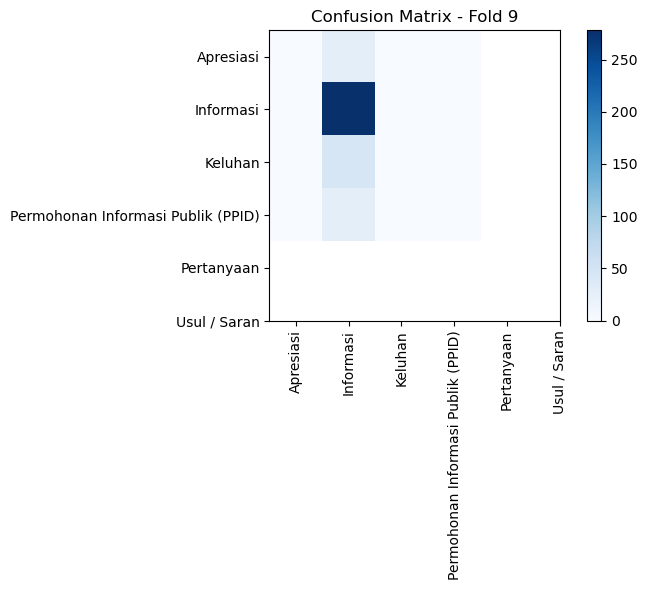

=========Fold :  9 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  28   0   0]
 [  0 278   0   0]
 [  0  44   0   0]
 [  0  28   0   0]]
Accuracy: 0.7354497354497355
Precision: [0.         0.73544974 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.84756098 0.         0.        ]
Processing time 0.006671905517578125
=========Macro Average=========
Precision Macro Avg : 0.18386243386243387
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21189024390243905
=========Micro Average=========
Precision Micro Avg: 0.7354497354497355
Recall Micro Avg: 0.7354497354497355
F1-Score Micro Avg: 0.7354497354497355
=========Weighted Average=========
Precision Weighted Avg: 0.5408863133730859
Recall Weighted Avg: 0.7354497354497355
F1-Score Weighted Avg: 0.6233384952897149




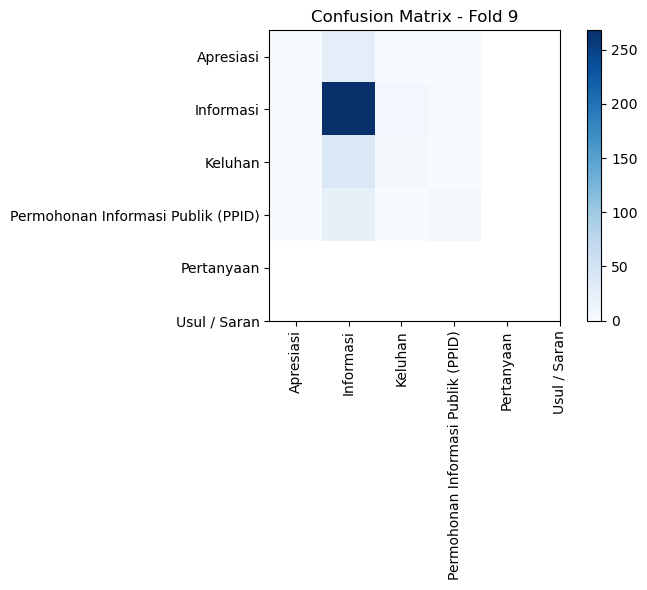

=========Fold :  9 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  26   1   1]
 [  0 268   7   3]
 [  0  38   6   0]
 [  0  23   0   5]]
Accuracy: 0.7380952380952381
Precision: [0.         0.75492958 0.42857143 0.55555556]
Recall: [0.         0.96402878 0.13636364 0.17857143]
F1-Score: [0.         0.84676145 0.20689655 0.27027027]
Processing time 0.008029937744140625
=========Macro Average=========
Precision Macro Avg : 0.4347641403979432
Recall Macro Avg: 0.3197409604783706
F1-Score Macro Avg: 0.3309820688477332
=========Micro Average=========
Precision Micro Avg: 0.7380952380952381
Recall Micro Avg: 0.7380952380952381
F1-Score Micro Avg: 0.7380952380952381
=========Weighted Average=========
Precision Weighted Avg: 0.6462516427193379
Recall Weighted Avg: 0.7380952380952381
F1-Score Weighted Avg: 0.6668537034065171




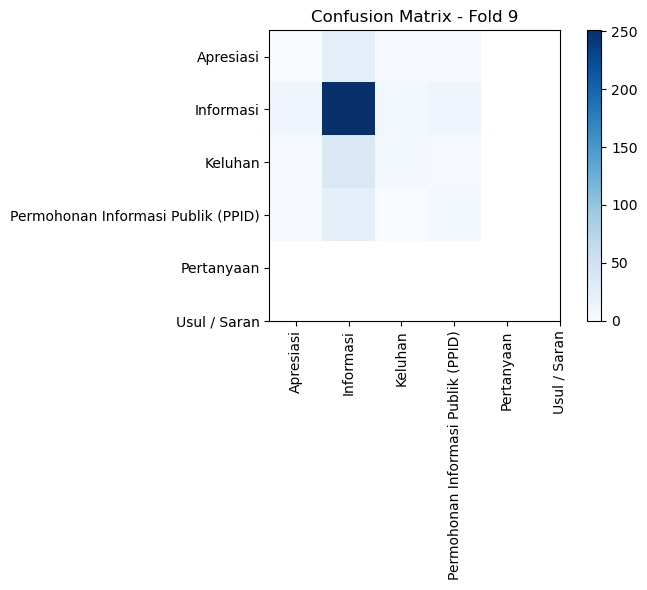

=========Fold :  9 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0  24   2   2]
 [ 10 251   6  11]
 [  1  36   5   2]
 [  1  23   0   4]]
Accuracy: 0.6878306878306878
Precision: [0.         0.75149701 0.38461538 0.21052632]
Recall: [0.         0.9028777  0.11363636 0.14285714]
F1-Score: [0.         0.82026144 0.1754386  0.17021277]
Processing time 0.7121319770812988
=========Macro Average=========
Precision Macro Avg : 0.33665967659822055
Recall Macro Avg: 0.2898428010838083
F1-Score Macro Avg: 0.29147820008929287
=========Micro Average=========
Precision Micro Avg: 0.6878306878306878
Recall Micro Avg: 0.6878306878306878
F1-Score Micro Avg: 0.6878306878306878
=========Weighted Average=========
Precision Weighted Avg: 0.6130528609255367
Recall Weighted Avg: 0.6878306878306878
F1-Score Weighted Avg: 0.6362908344735042




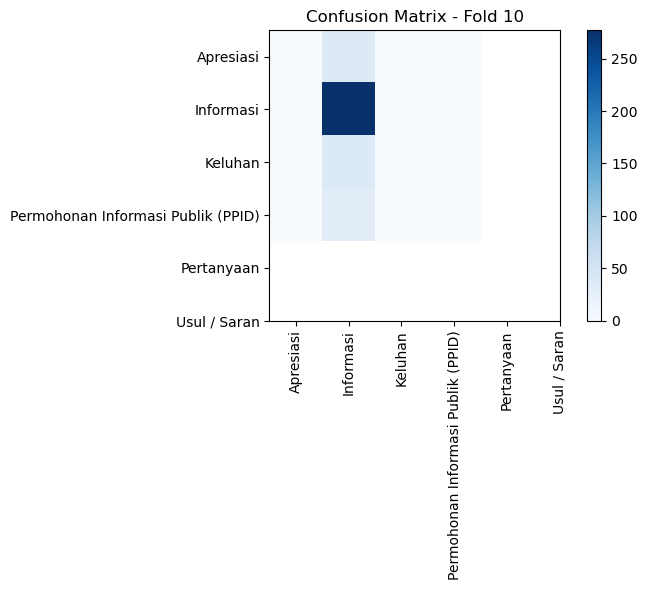

=========Fold :  10 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  35   0   0]
 [  0 277   0   0]
 [  0  37   0   0]
 [  0  29   0   0]]
Accuracy: 0.7328042328042328
Precision: [0.         0.73280423 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.84580153 0.         0.        ]
Processing time 0.006679058074951172
=========Macro Average=========
Precision Macro Avg : 0.1832010582010582
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21145038167938932
=========Micro Average=========
Precision Micro Avg: 0.7328042328042328
Recall Micro Avg: 0.7328042328042328
F1-Score Micro Avg: 0.7328042328042328
=========Weighted Average=========
Precision Weighted Avg: 0.5370020436158002
Recall Weighted Avg: 0.7328042328042328
F1-Score Weighted Avg: 0.6198069388909083




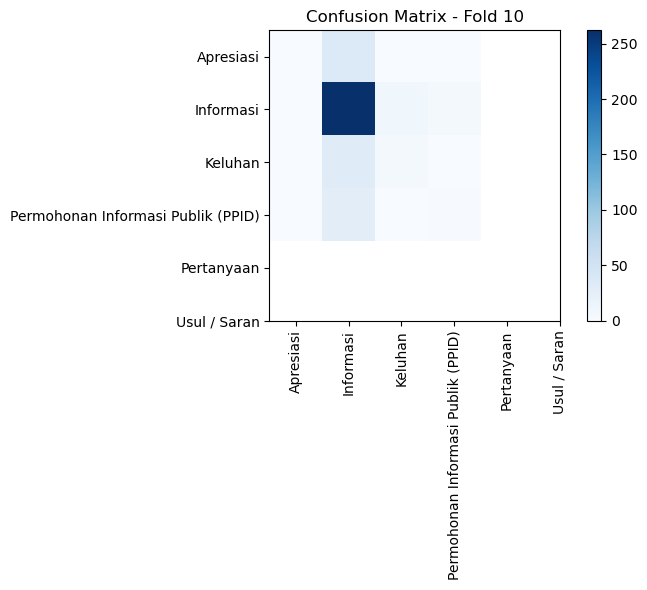

=========Fold :  10 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  35   0   0]
 [  0 262  10   5]
 [  0  31   5   1]
 [  0  27   0   2]]
Accuracy: 0.7116402116402116
Precision: [0.         0.73802817 0.33333333 0.25      ]
Recall: [0.         0.94584838 0.13513514 0.06896552]
F1-Score: [0.         0.82911392 0.19230769 0.10810811]
Processing time 0.008054018020629883
=========Macro Average=========
Precision Macro Avg : 0.3303403755868545
Recall Macro Avg: 0.2874872569569445
F1-Score Macro Avg: 0.2823824311166084
=========Micro Average=========
Precision Micro Avg: 0.7116402116402116
Recall Micro Avg: 0.7116402116402116
F1-Score Micro Avg: 0.7116402116402116
=========Weighted Average=========
Precision Weighted Avg: 0.5926379263233724
Recall Weighted Avg: 0.7116402116402116
F1-Score Weighted Avg: 0.6346959701390081




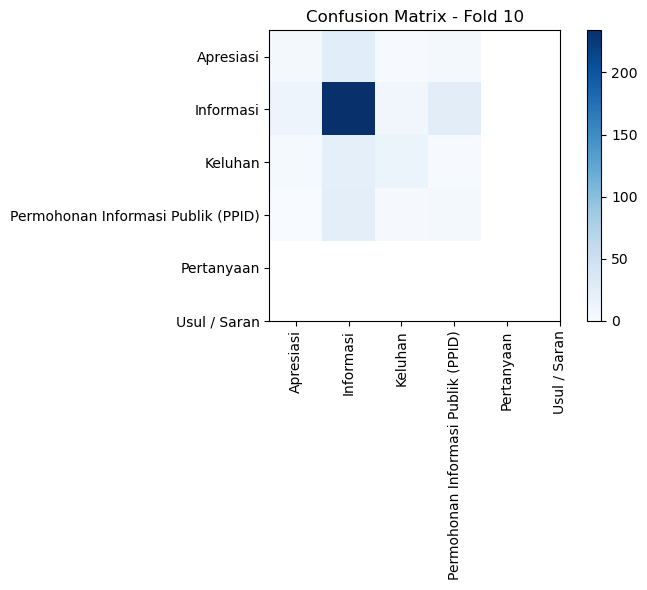

=========Fold :  10 =========
Classifier: GaussianNB
Confusion Matrix:
[[  5  25   1   4]
 [ 11 234   8  24]
 [  3  21  12   1]
 [  0  23   2   4]]
Accuracy: 0.6746031746031746
Precision: [0.26315789 0.77227723 0.52173913 0.12121212]
Recall: [0.14285714 0.84476534 0.32432432 0.13793103]
F1-Score: [0.18518519 0.80689655 0.4        0.12903226]
Processing time 0.6297917366027832
=========Macro Average=========
Precision Macro Avg : 0.4195965935266295
Recall Macro Avg: 0.36246946115612866
F1-Score Macro Avg: 0.3802784987434598
=========Micro Average=========
Precision Micro Avg: 0.6746031746031746
Recall Micro Avg: 0.6746031746031746
F1-Score Micro Avg: 0.6746031746031746
=========Weighted Average=========
Precision Weighted Avg: 0.650663538984751
Recall Weighted Avg: 0.6746031746031746
F1-Score Weighted Avg: 0.6574967243199435


======5-FOLD CROSS VALIDATION FOR 50% DATA======
K-Fold = 5
Data Deskripsi Array Len = 7573
Data Pre-process Array Len = 7573


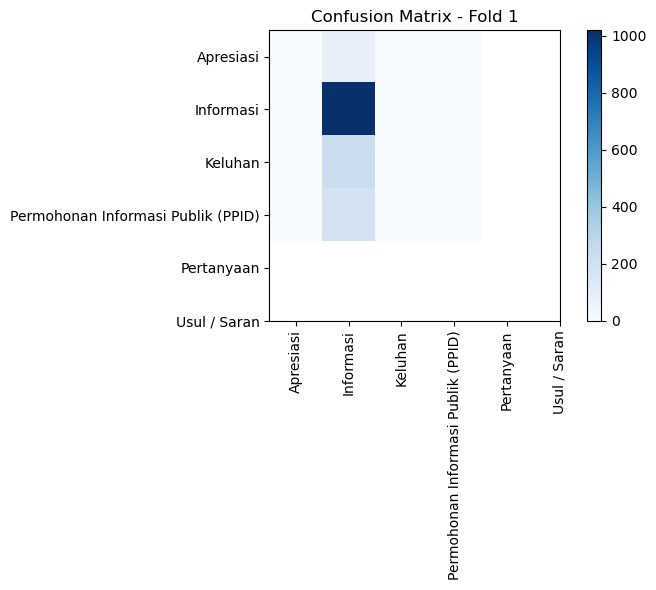

=========Fold :  1 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0   82    0    0]
 [   0 1019    0    0]
 [   0  227    0    0]
 [   0  187    0    0]]
Accuracy: 0.6726072607260726
Precision: [0.         0.67260726 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.80426204 0.         0.        ]
Processing time 0.012935876846313477
=========Macro Average=========
Precision Macro Avg : 0.16815181518151814
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.20106550907655882
=========Micro Average=========
Precision Micro Avg: 0.6726072607260726
Recall Micro Avg: 0.6726072607260726
F1-Score Micro Avg: 0.6726072607260726
=========Weighted Average=========
Precision Weighted Avg: 0.45240052718143103
Recall Weighted Avg: 0.6726072607260726
F1-Score Weighted Avg: 0.5409524851459101




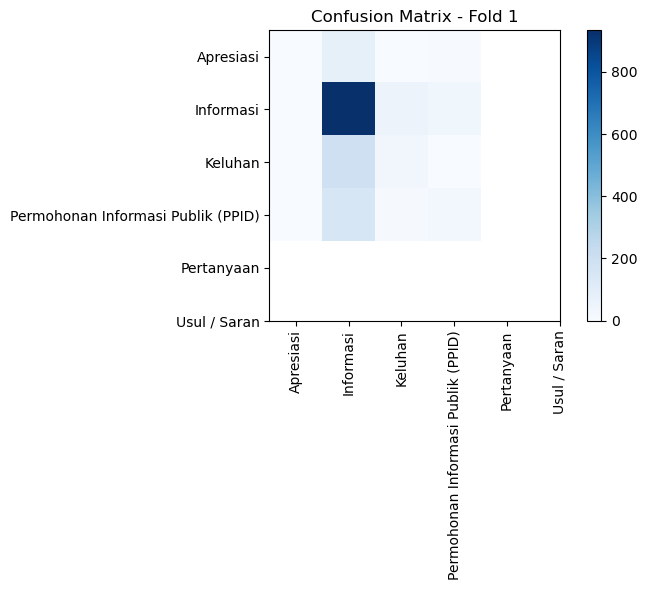

=========Fold :  1 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  77   1   4]
 [  0 934  52  33]
 [  0 195  30   2]
 [  0 153   8  26]]
Accuracy: 0.6534653465346535
Precision: [0.         0.68727005 0.32967033 0.4       ]
Recall: [0.         0.91658489 0.13215859 0.13903743]
F1-Score: [0.         0.78553406 0.18867925 0.20634921]
Processing time 0.014323949813842773
=========Macro Average=========
Precision Macro Avg : 0.354235095294698
Recall Macro Avg: 0.2969452276519273
F1-Score Macro Avg: 0.2951406284673498
=========Micro Average=========
Precision Micro Avg: 0.6534653465346535
Recall Micro Avg: 0.6534653465346535
F1-Score Micro Avg: 0.6534653465346535
=========Weighted Average=========
Precision Weighted Avg: 0.5610319124239522
Recall Weighted Avg: 0.6534653465346535
F1-Score Weighted Avg: 0.5820968314760575




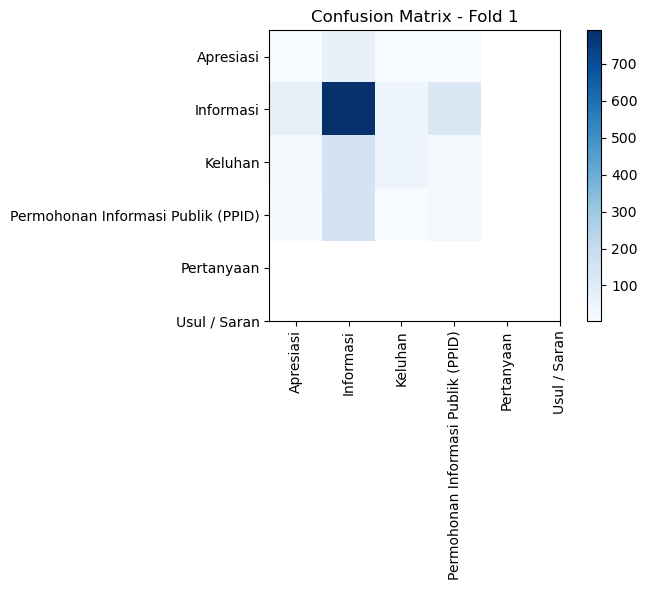

=========Fold :  1 =========
Classifier: GaussianNB
Confusion Matrix:
[[  8  63   5   6]
 [ 70 791  38 120]
 [ 20 148  42  17]
 [ 10 148   6  23]]
Accuracy: 0.5702970297029702
Precision: [0.07407407 0.68782609 0.46153846 0.13855422]
Recall: [0.09756098 0.77625123 0.18502203 0.12299465]
F1-Score: [0.08421053 0.72936837 0.26415094 0.13031161]
Processing time 2.625460386276245
=========Macro Average=========
Precision Macro Avg : 0.3404982098591318
Recall Macro Avg: 0.29545722028518184
F1-Score Macro Avg: 0.3020103642411984
=========Micro Average=========
Precision Micro Avg: 0.5702970297029702
Recall Micro Avg: 0.5702970297029702
F1-Score Micro Avg: 0.5702970297029702
=========Weighted Average=========
Precision Weighted Avg: 0.5529027894430477
Recall Weighted Avg: 0.5702970297029702
F1-Score Weighted Avg: 0.5508001127810747




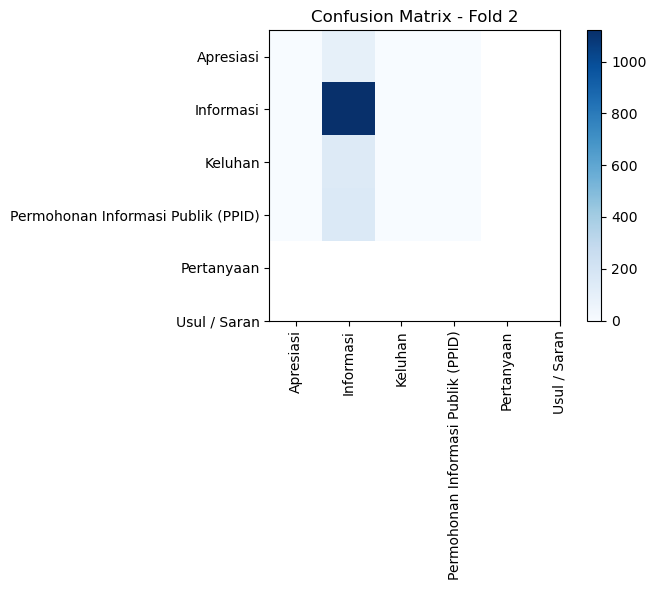

=========Fold :  2 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0   94    0    0]
 [   0 1121    0    0]
 [   0  143    0    0]
 [   0  157    0    0]]
Accuracy: 0.73993399339934
Precision: [0.         0.73993399 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.85053111 0.         0.        ]
Processing time 0.012408018112182617
=========Macro Average=========
Precision Macro Avg : 0.184983498349835
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21263277693474963
=========Micro Average=========
Precision Micro Avg: 0.73993399339934
Recall Micro Avg: 0.73993399339934
F1-Score Micro Avg: 0.73993399339934
=========Weighted Average=========
Precision Weighted Avg: 0.5475023145878944
Recall Weighted Avg: 0.73993399339934
F1-Score Weighted Avg: 0.6293368790596814




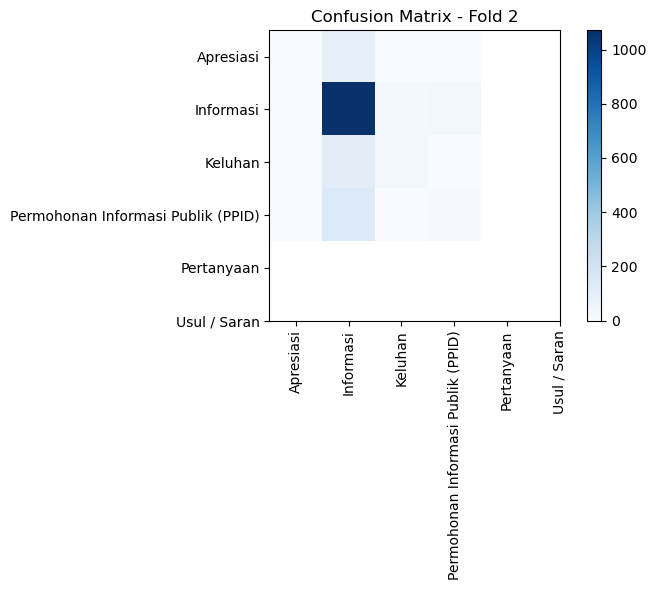

=========Fold :  2 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0   88    4    2]
 [   0 1071   23   27]
 [   0  110   32    1]
 [   0  143    2   12]]
Accuracy: 0.735973597359736
Precision: [0.         0.75849858 0.52459016 0.28571429]
Recall: [0.         0.95539697 0.22377622 0.07643312]
F1-Score: [0.         0.84563758 0.31372549 0.12060302]
Processing time 0.02039504051208496
=========Macro Average=========
Precision Macro Avg : 0.3922007583045293
Recall Macro Avg: 0.3139015779472719
F1-Score Macro Avg: 0.31999152229101824
=========Micro Average=========
Precision Micro Avg: 0.735973597359736
Recall Micro Avg: 0.735973597359736
F1-Score Micro Avg: 0.735973597359736
=========Weighted Average=========
Precision Weighted Avg: 0.6403633323307386
Recall Weighted Avg: 0.735973597359736
F1-Score Weighted Avg: 0.667826501655774




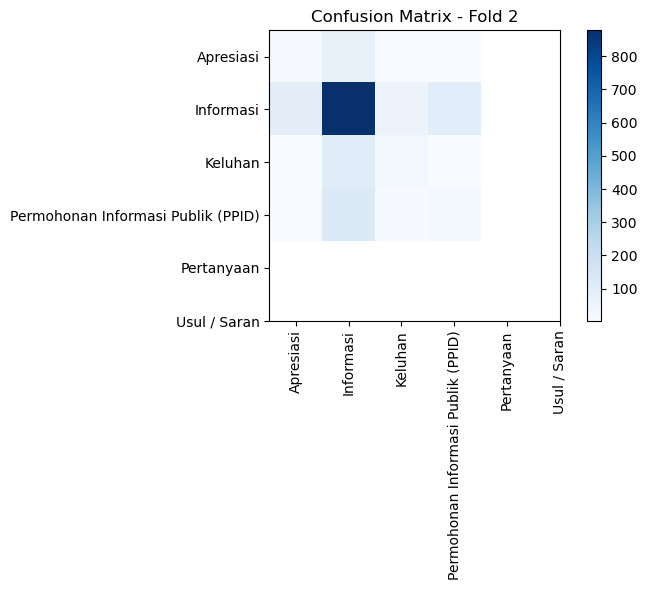

=========Fold :  2 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 11  70   6   7]
 [ 91 878  55  97]
 [  6 104  26   7]
 [  4 122   9  22]]
Accuracy: 0.6184818481848184
Precision: [0.09821429 0.74787053 0.27083333 0.16541353]
Recall: [0.11702128 0.78322926 0.18181818 0.14012739]
F1-Score: [0.10679612 0.76514161 0.21757322 0.15172414]
Processing time 3.0220279693603516
=========Macro Average=========
Precision Macro Avg : 0.32058292024780866
Recall Macro Avg: 0.3055490266346526
F1-Score Macro Avg: 0.3103087720984117
=========Micro Average=========
Precision Micro Avg: 0.6184818481848184
Recall Micro Avg: 0.6184818481848184
F1-Score Micro Avg: 0.6184818481848184
=========Weighted Average=========
Precision Weighted Avg: 0.6021743210205024
Recall Weighted Avg: 0.6184818481848184
F1-Score Weighted Avg: 0.6090404241548608




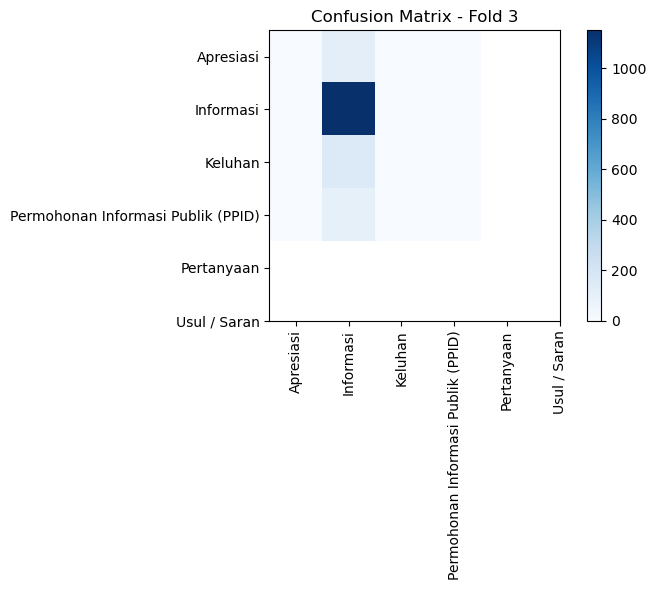

=========Fold :  3 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  114    0    0]
 [   0 1151    0    0]
 [   0  154    0    0]
 [   0   96    0    0]]
Accuracy: 0.7597359735973598
Precision: [0.         0.75973597 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.86346587 0.         0.        ]
Processing time 0.01397085189819336
=========Macro Average=========
Precision Macro Avg : 0.18993399339933995
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21586646661665418
=========Micro Average=========
Precision Micro Avg: 0.7597359735973598
Recall Micro Avg: 0.7597359735973598
F1-Score Micro Avg: 0.7597359735973598
=========Weighted Average=========
Precision Weighted Avg: 0.577198749577928
Recall Weighted Avg: 0.7597359735973598
F1-Score Weighted Avg: 0.6560060807281028




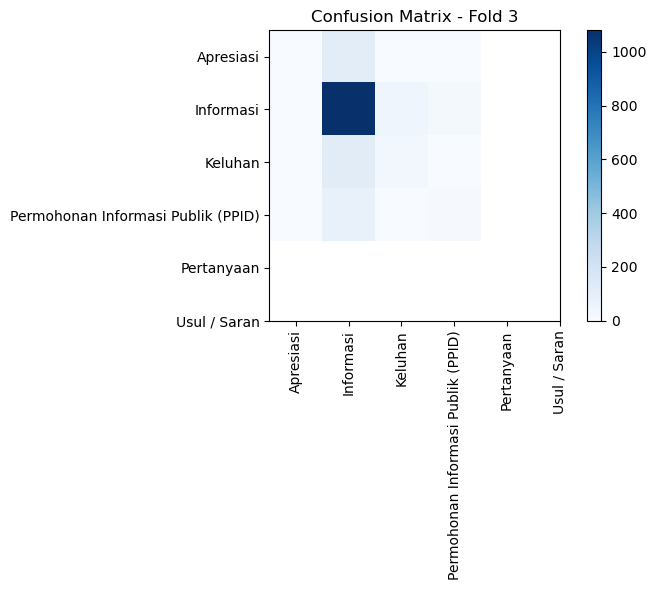

=========Fold :  3 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0  110    3    1]
 [   0 1080   46   25]
 [   0  119   32    3]
 [   0   81    3   12]]
Accuracy: 0.7419141914191419
Precision: [0.         0.77697842 0.38095238 0.29268293]
Recall: [0.         0.93831451 0.20779221 0.125     ]
F1-Score: [0.         0.85005903 0.26890756 0.17518248]
Processing time 0.0174710750579834
=========Macro Average=========
Precision Macro Avg : 0.3626534312619591
Recall Macro Avg: 0.31777667922867747
F1-Score Macro Avg: 0.3235372691635622
=========Micro Average=========
Precision Micro Avg: 0.7419141914191419
Recall Micro Avg: 0.7419141914191419
F1-Score Micro Avg: 0.7419141914191419
=========Weighted Average=========
Precision Weighted Avg: 0.6475685715614903
Recall Weighted Avg: 0.7419141914191419
F1-Score Weighted Avg: 0.6842555964651688




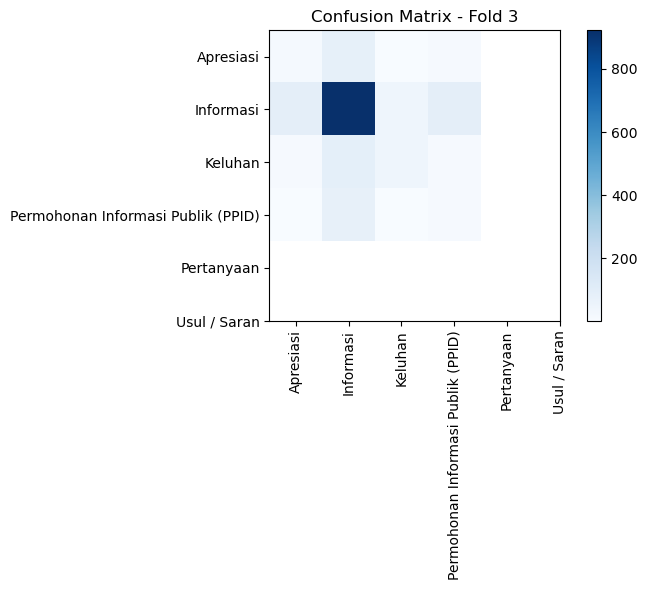

=========Fold :  3 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 15  80   6  13]
 [ 92 922  46  91]
 [ 12  86  43  13]
 [  5  77   3  11]]
Accuracy: 0.6541254125412541
Precision: [0.12096774 0.79141631 0.43877551 0.0859375 ]
Recall: [0.13157895 0.80104257 0.27922078 0.11458333]
F1-Score: [0.12605042 0.79620035 0.34126984 0.09821429]
Processing time 3.0899410247802734
=========Macro Average=========
Precision Macro Avg : 0.35927426528811024
Recall Macro Avg: 0.3316064078998341
F1-Score Macro Avg: 0.3404337231438344
=========Micro Average=========
Precision Micro Avg: 0.6541254125412541
Recall Micro Avg: 0.6541254125412541
F1-Score Micro Avg: 0.6541254125412541
=========Weighted Average=========
Precision Weighted Avg: 0.6604171107761673
Recall Weighted Avg: 0.6541254125412541
F1-Score Weighted Avg: 0.6553006418913034




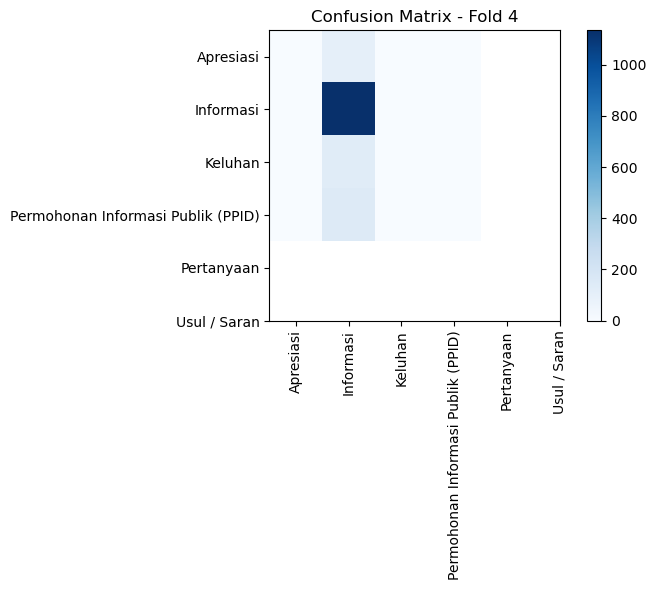

=========Fold :  4 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  100    0    0]
 [   0 1135    0    0]
 [   0  131    0    0]
 [   0  148    0    0]]
Accuracy: 0.749669749009247
Precision: [0.         0.74966975 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.85692714 0.         0.        ]
Processing time 0.013721227645874023
=========Macro Average=========
Precision Macro Avg : 0.18741743725231175
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21423178557946393
=========Micro Average=========
Precision Micro Avg: 0.749669749009247
Recall Micro Avg: 0.749669749009247
F1-Score Micro Avg: 0.749669749009247
=========Weighted Average=========
Precision Weighted Avg: 0.5620047325795874
Recall Weighted Avg: 0.749669749009247
F1-Score Weighted Avg: 0.6424123557006381




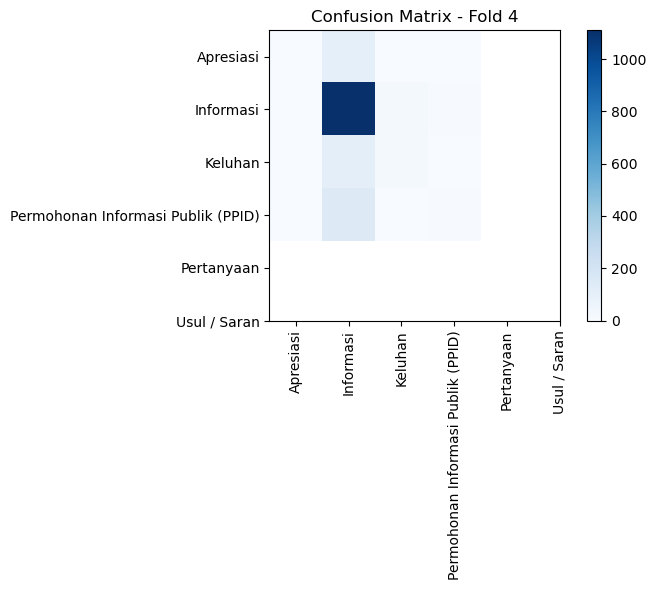

=========Fold :  4 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0   96    3    1]
 [   0 1110   18    7]
 [   0  108   22    1]
 [   0  139    3    6]]
Accuracy: 0.7516512549537648
Precision: [0.         0.76393668 0.47826087 0.4       ]
Recall: [0.         0.97797357 0.16793893 0.04054054]
F1-Score: [0.         0.85780526 0.24858757 0.07361963]
Processing time 0.018687963485717773
=========Macro Average=========
Precision Macro Avg : 0.4105493880726533
Recall Macro Avg: 0.29661326003004723
F1-Score Macro Avg: 0.29500311438662336
=========Micro Average=========
Precision Micro Avg: 0.7516512549537648
Recall Micro Avg: 0.7516512549537648
F1-Score Micro Avg: 0.7516512549537648
=========Weighted Average=========
Precision Weighted Avg: 0.6531838235180764
Recall Weighted Avg: 0.7516512549537648
F1-Score Weighted Avg: 0.6717765136883742




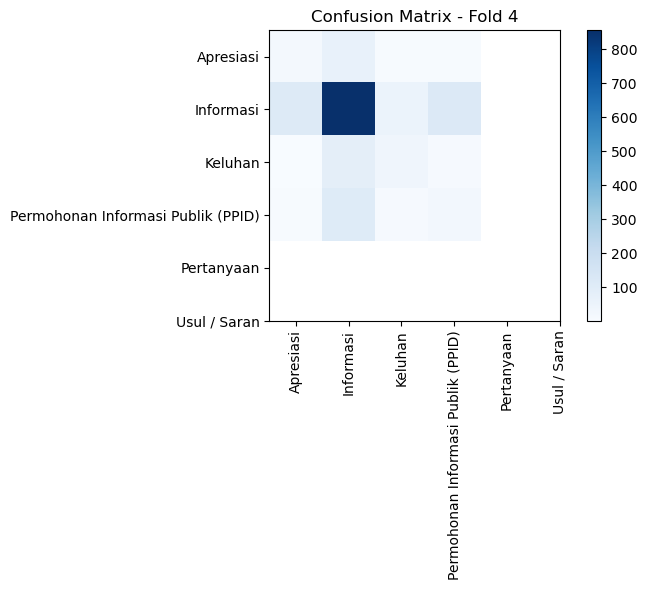

=========Fold :  4 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 20  67   7   6]
 [110 856  53 116]
 [  2  84  36   9]
 [  8 106   9  25]]
Accuracy: 0.6188903566710701
Precision: [0.14285714 0.76909254 0.34285714 0.16025641]
Recall: [0.2        0.75418502 0.27480916 0.16891892]
F1-Score: [0.16666667 0.76156584 0.30508475 0.16447368]
Processing time 3.0614490509033203
=========Macro Average=========
Precision Macro Avg : 0.35376580966203613
Recall Macro Avg: 0.3494782753126735
F1-Score Macro Avg: 0.3494477332347093
=========Micro Average=========
Precision Micro Avg: 0.6188903566710701
Recall Micro Avg: 0.6188903566710701
F1-Score Micro Avg: 0.6188903566710701
=========Weighted Average=========
Precision Weighted Avg: 0.6313328828644997
Recall Weighted Avg: 0.6188903566710701
F1-Score Weighted Avg: 0.624406933833572




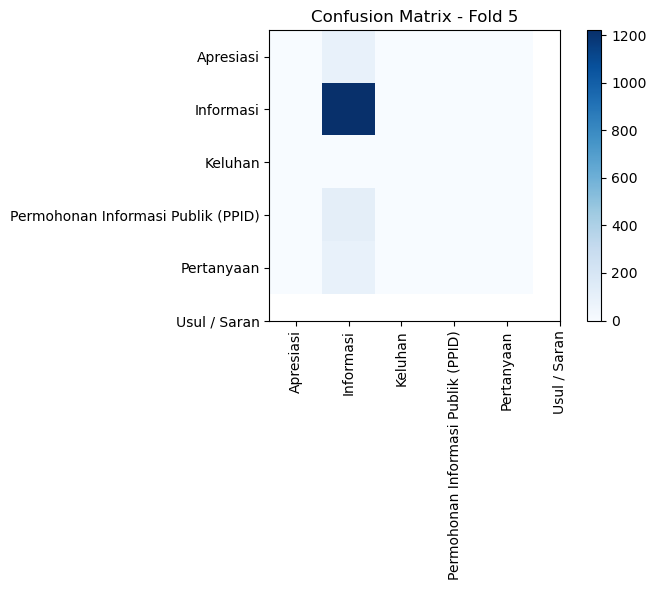

=========Fold :  5 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0   86    0    0    0]
 [   0 1220    0    0    0]
 [   0    1    0    0    0]
 [   0  118    0    0    0]
 [   0   89    0    0    0]]
Accuracy: 0.8058124174372523
Precision: [0.         0.80581242 0.         0.         0.        ]
Recall: [0. 1. 0. 0. 0.]
F1-Score: [0.         0.89246525 0.         0.         0.        ]
Processing time 0.012557744979858398
=========Macro Average=========
Precision Macro Avg : 0.16116248348745046
Recall Macro Avg: 0.2
F1-Score Macro Avg: 0.17849305047549377
=========Micro Average=========
Precision Micro Avg: 0.8058124174372523
Recall Micro Avg: 0.8058124174372523
F1-Score Micro Avg: 0.8058124174372523
=========Weighted Average=========
Precision Weighted Avg: 0.6493336520960686
Recall Weighted Avg: 0.8058124174372523
F1-Score Weighted Avg: 0.7191595824970357




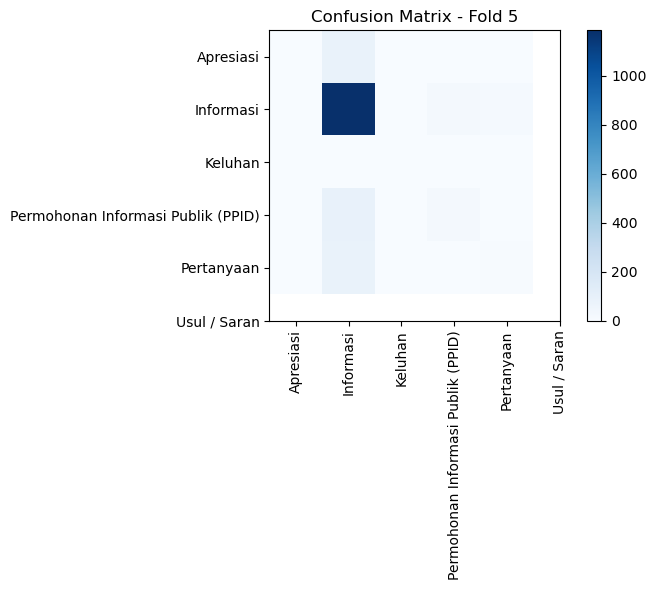

=========Fold :  5 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0   83    0    3    0]
 [   0 1186    0   19   15]
 [   0    0    0    1    0]
 [   0   89    0   27    2]
 [   0   81    0    1    7]]
Accuracy: 0.8058124174372523
Precision: [0.         0.82418346 0.         0.52941176 0.29166667]
Recall: [0.         0.97213115 0.         0.22881356 0.07865169]
F1-Score: [0.         0.89206469 0.         0.31952663 0.12389381]
Processing time 0.01395106315612793
=========Macro Average=========
Precision Macro Avg : 0.3290523784218343
Recall Macro Avg: 0.25591927845125517
F1-Score Macro Avg: 0.26709702370016786
=========Micro Average=========
Precision Micro Avg: 0.8058124174372523
Recall Micro Avg: 0.8058124174372523
F1-Score Micro Avg: 0.8058124174372523
=========Weighted Average=========
Precision Weighted Avg: 0.7225447448264908
Recall Weighted Avg: 0.8058124174372523
F1-Score Weighted Avg: 0.7510235188708376




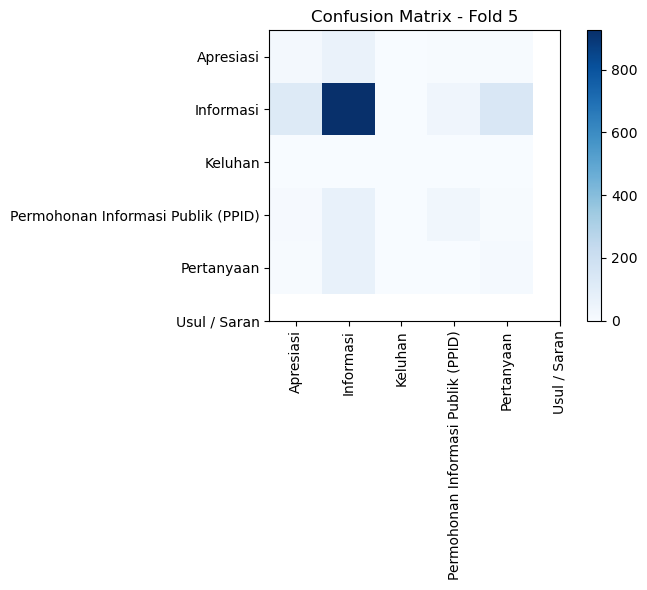

=========Fold :  5 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 15  59   0   5   7]
 [118 926   0  38 138]
 [  0   1   0   0   0]
 [  9  72   0  32   5]
 [  7  69   0   2  11]]
Accuracy: 0.6499339498018494
Precision: [0.10067114 0.8216504  0.         0.41558442 0.06832298]
Recall: [0.1744186  0.75901639 0.         0.27118644 0.12359551]
F1-Score: [0.12765957 0.78909246 0.         0.32820513 0.088     ]
Processing time 2.9082281589508057
=========Macro Average=========
Precision Macro Avg : 0.28124578743612466
Recall Macro Avg: 0.26564338887794586
F1-Score Macro Avg: 0.26659143222616377
=========Micro Average=========
Precision Micro Avg: 0.6499339498018494
Recall Micro Avg: 0.6499339498018494
F1-Score Micro Avg: 0.6499339498018494
=========Weighted Average=========
Precision Weighted Avg: 0.7042212097987881
Recall Weighted Avg: 0.6499339498018494
F1-Score Weighted Avg: 0.6738650778406466


======10-FOLD CROSS VALIDATION FOR 50% DATA======
K-Fold = 10
Data Deskripsi Array Len =

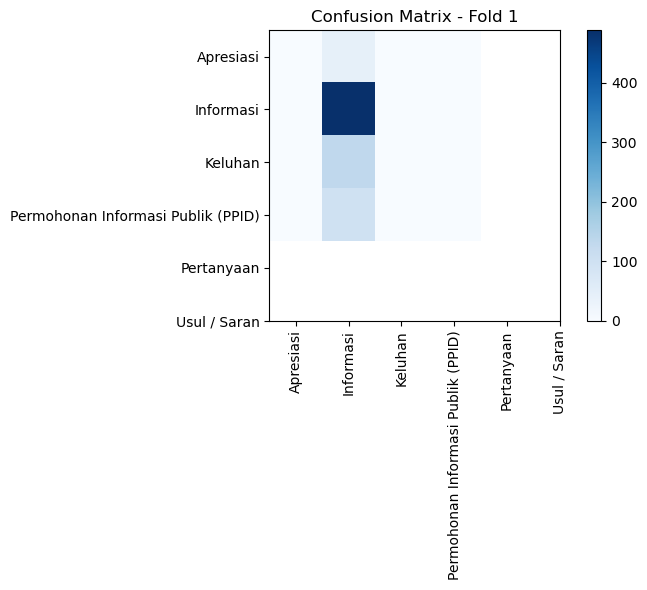

=========Fold :  1 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  41   0   0]
 [  0 488   0   0]
 [  0 130   0   0]
 [  0  99   0   0]]
Accuracy: 0.6437994722955145
Precision: [0.         0.64379947 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.78330658 0.         0.        ]
Processing time 0.013917922973632812
=========Macro Average=========
Precision Macro Avg : 0.16094986807387862
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.1958266452648475
=========Micro Average=========
Precision Micro Avg: 0.6437994722955145
Recall Micro Avg: 0.6437994722955145
F1-Score Micro Avg: 0.6437994722955145
=========Weighted Average=========
Precision Weighted Avg: 0.4144777605279829
Recall Weighted Avg: 0.6437994722955145
F1-Score Weighted Avg: 0.504292363531639




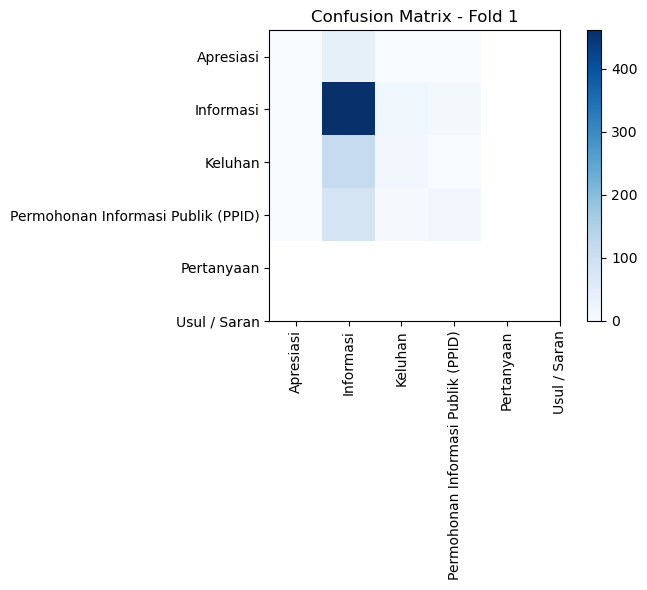

=========Fold :  1 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  39   1   1]
 [  0 461  17  10]
 [  0 115  14   1]
 [  0  80   4  15]]
Accuracy: 0.6464379947229552
Precision: [0.         0.66330935 0.38888889 0.55555556]
Recall: [0.         0.94467213 0.10769231 0.15151515]
F1-Score: [0.         0.77937447 0.1686747  0.23809524]
Processing time 0.018344879150390625
=========Macro Average=========
Precision Macro Avg : 0.4019384492406075
Recall Macro Avg: 0.3009698975887501
F1-Score Macro Avg: 0.2965361021431457
=========Micro Average=========
Precision Micro Avg: 0.6464379947229552
Recall Micro Avg: 0.6464379947229552
F1-Score Micro Avg: 0.6464379947229552
=========Weighted Average=========
Precision Weighted Avg: 0.5662935614569031
Recall Weighted Avg: 0.6464379947229552
F1-Score Weighted Avg: 0.5617861234771743




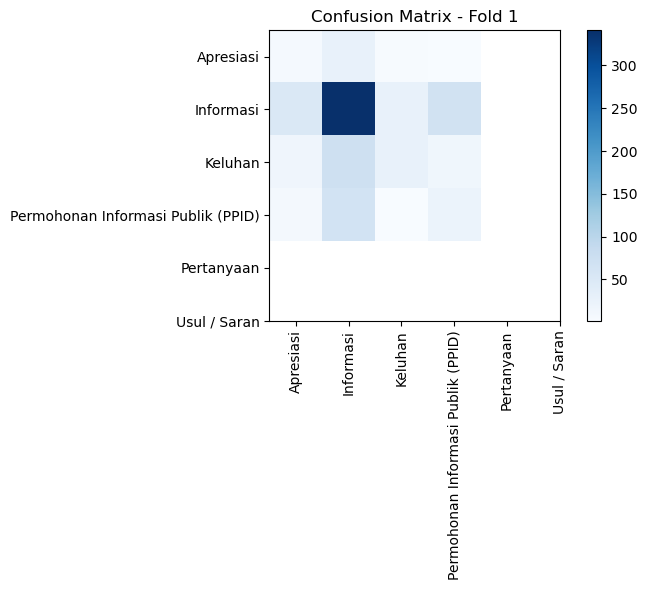

=========Fold :  1 =========
Classifier: GaussianNB
Confusion Matrix:
[[  7  28   4   2]
 [ 51 341  28  68]
 [ 16  73  27  14]
 [  9  65   2  23]]
Accuracy: 0.525065963060686
Precision: [0.08433735 0.67258383 0.44262295 0.21495327]
Recall: [0.17073171 0.69877049 0.20769231 0.23232323]
F1-Score: [0.11290323 0.68542714 0.28272251 0.22330097]
Processing time 2.7524988651275635
=========Macro Average=========
Precision Macro Avg : 0.35362434941882004
Recall Macro Avg: 0.32737943478397297
F1-Score Macro Avg: 0.32608846136190883
=========Micro Average=========
Precision Micro Avg: 0.525065963060686
Recall Micro Avg: 0.525065963060686
F1-Score Micro Avg: 0.525065963060686
=========Weighted Average=========
Precision Weighted Avg: 0.5415568549623544
Recall Weighted Avg: 0.525065963060686
F1-Score Weighted Avg: 0.5250371995873289




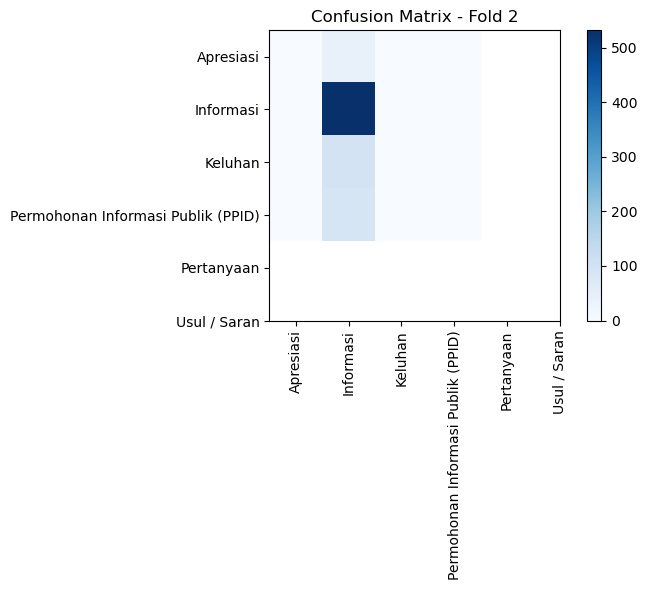

=========Fold :  2 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  41   0   0]
 [  0 532   0   0]
 [  0  97   0   0]
 [  0  88   0   0]]
Accuracy: 0.7018469656992085
Precision: [0.         0.70184697 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.        0.8248062 0.        0.       ]
Processing time 0.014378070831298828
=========Macro Average=========
Precision Macro Avg : 0.17546174142480211
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2062015503875969
=========Micro Average=========
Precision Micro Avg: 0.7018469656992085
Recall Micro Avg: 0.7018469656992085
F1-Score Micro Avg: 0.7018469656992085
=========Weighted Average=========
Precision Weighted Avg: 0.4925891632611859
Recall Weighted Avg: 0.7018469656992085
F1-Score Weighted Avg: 0.5788877298480293




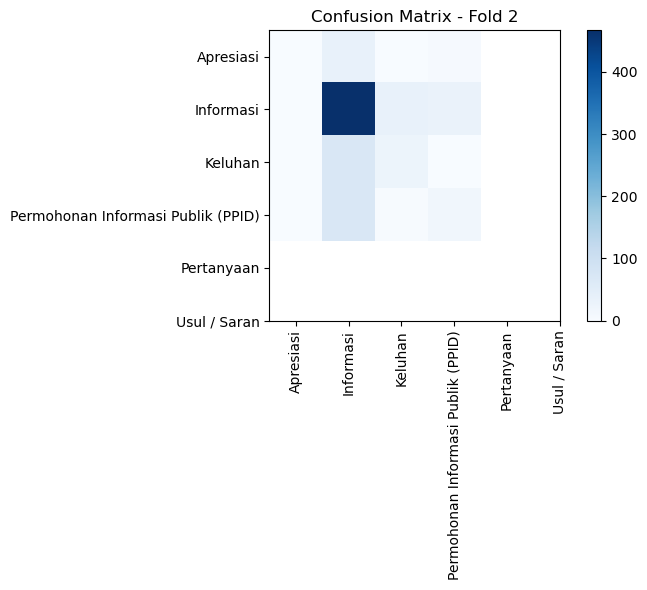

=========Fold :  2 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  36   1   4]
 [  0 467  35  30]
 [  0  71  25   1]
 [  0  71   2  15]]
Accuracy: 0.6688654353562006
Precision: [0.         0.72403101 0.3968254  0.3       ]
Recall: [0.         0.87781955 0.25773196 0.17045455]
F1-Score: [0.         0.79354291 0.3125     0.2173913 ]
Processing time 0.017247915267944336
=========Macro Average=========
Precision Macro Avg : 0.3552141011443337
Recall Macro Avg: 0.3265015132724031
F1-Score Macro Avg: 0.33085855251006613
=========Micro Average=========
Precision Micro Avg: 0.6688654353562006
Recall Micro Avg: 0.6688654353562006
F1-Score Micro Avg: 0.6688654353562006
=========Weighted Average=========
Precision Weighted Avg: 0.5937685483061932
Recall Weighted Avg: 0.6688654353562006
F1-Score Weighted Avg: 0.6221738266635697




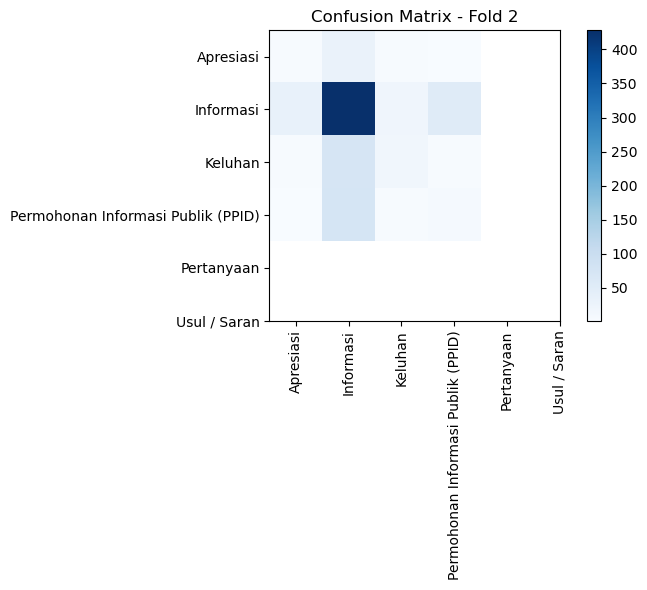

=========Fold :  2 =========
Classifier: GaussianNB
Confusion Matrix:
[[  4  29   5   3]
 [ 32 428  20  52]
 [  4  72  16   5]
 [  2  75   4   7]]
Accuracy: 0.600263852242744
Precision: [0.0952381  0.70860927 0.35555556 0.10447761]
Recall: [0.09756098 0.80451128 0.16494845 0.07954545]
F1-Score: [0.09638554 0.75352113 0.22535211 0.09032258]
Processing time 2.960994005203247
=========Macro Average=========
Precision Macro Avg : 0.31597013356428205
Recall Macro Avg: 0.2866415404897367
F1-Score Macro Avg: 0.2913953405626139
=========Micro Average=========
Precision Micro Avg: 0.600263852242744
Recall Micro Avg: 0.600263852242744
F1-Score Micro Avg: 0.600263852242744
=========Weighted Average=========
Precision Weighted Avg: 0.5601158484099317
Recall Weighted Avg: 0.600263852242744
F1-Score Weighted Avg: 0.573393916480062




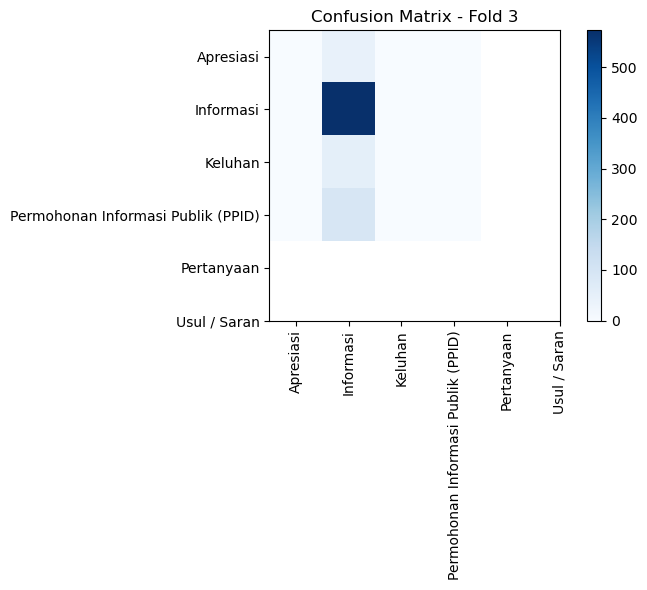

=========Fold :  3 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  41   0   0]
 [  0 573   0   0]
 [  0  53   0   0]
 [  0  91   0   0]]
Accuracy: 0.7559366754617414
Precision: [0.         0.75593668 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.86100676 0.         0.        ]
Processing time 0.015027999877929688
=========Macro Average=========
Precision Macro Avg : 0.18898416886543534
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21525169045830203
=========Micro Average=========
Precision Micro Avg: 0.7559366754617414
Recall Micro Avg: 0.7559366754617414
F1-Score Micro Avg: 0.7559366754617414
=========Weighted Average=========
Precision Weighted Avg: 0.5714402573081502
Recall Weighted Avg: 0.7559366754617414
F1-Score Weighted Avg: 0.6508665890902747




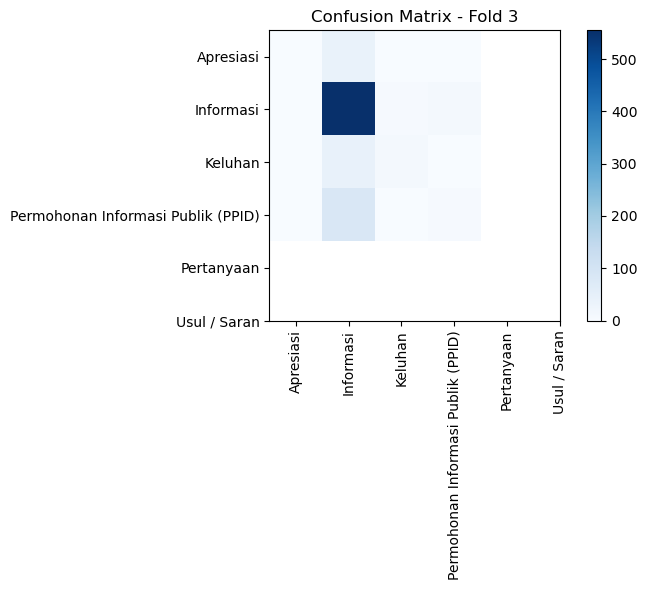

=========Fold :  3 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  38   2   1]
 [  0 555   5  13]
 [  0  43   9   1]
 [  0  84   1   6]]
Accuracy: 0.7519788918205804
Precision: [0.         0.77083333 0.52941176 0.28571429]
Recall: [0.         0.96858639 0.16981132 0.06593407]
F1-Score: [0.         0.85846868 0.25714286 0.10714286]
Processing time 0.016651153564453125
=========Macro Average=========
Precision Macro Avg : 0.39648984593837533
Recall Macro Avg: 0.3010829435308345
F1-Score Macro Avg: 0.3056885979449785
=========Micro Average=========
Precision Micro Avg: 0.7519788918205804
Recall Micro Avg: 0.7519788918205804
F1-Score Micro Avg: 0.7519788918205805
=========Weighted Average=========
Precision Weighted Avg: 0.6540188964767966
Recall Weighted Avg: 0.7519788918205804
F1-Score Weighted Avg: 0.6797904005709073




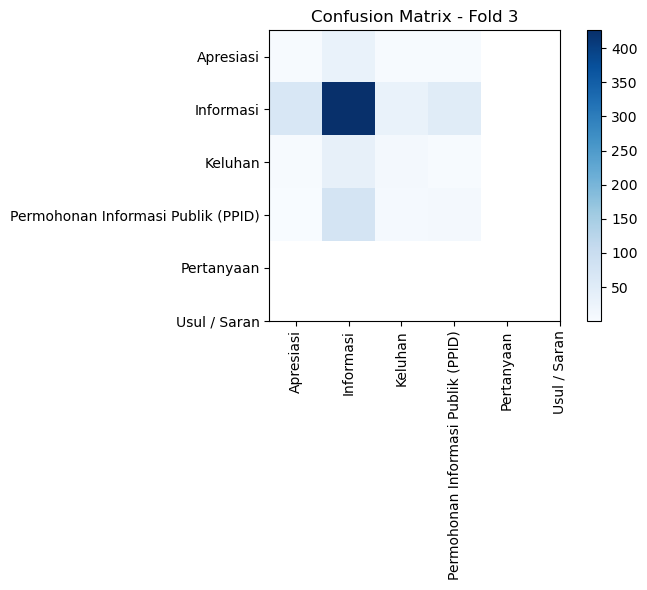

=========Fold :  3 =========
Classifier: GaussianNB
Confusion Matrix:
[[  4  30   4   3]
 [ 67 426  30  50]
 [  4  35  10   4]
 [  1  75   7   8]]
Accuracy: 0.5910290237467019
Precision: [0.05263158 0.75265018 0.19607843 0.12307692]
Recall: [0.09756098 0.7434555  0.18867925 0.08791209]
F1-Score: [0.06837607 0.74802458 0.19230769 0.1025641 ]
Processing time 3.8426339626312256
=========Macro Average=========
Precision Macro Avg : 0.2811092775188214
Recall Macro Avg: 0.27940195154676545
F1-Score Macro Avg: 0.27781811155384467
=========Micro Average=========
Precision Micro Avg: 0.5910290237467019
Recall Micro Avg: 0.5910290237467019
F1-Score Micro Avg: 0.5910290237467019
=========Weighted Average=========
Precision Weighted Avg: 0.6002883942431877
Recall Weighted Avg: 0.5910290237467019
F1-Score Weighted Avg: 0.5949170789834382




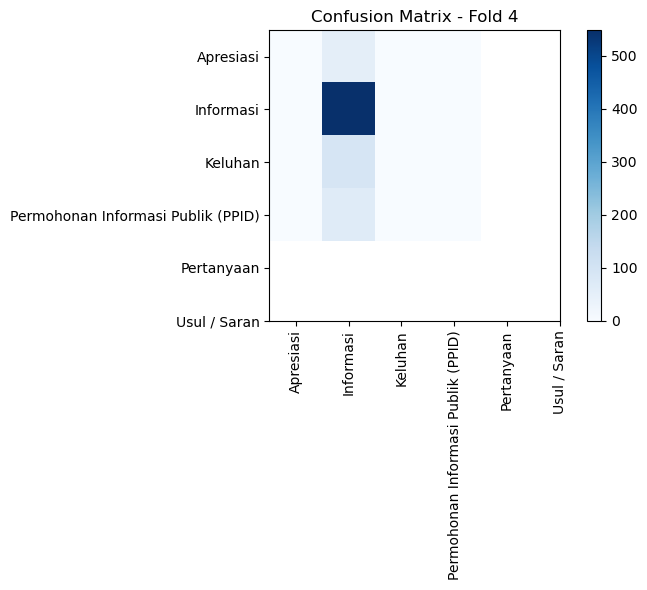

=========Fold :  4 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  53   0   0]
 [  0 548   0   0]
 [  0  90   0   0]
 [  0  66   0   0]]
Accuracy: 0.7239101717305152
Precision: [0.         0.72391017 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.83984674 0.         0.        ]
Processing time 0.014538049697875977
=========Macro Average=========
Precision Macro Avg : 0.1809775429326288
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2099616858237548
=========Micro Average=========
Precision Micro Avg: 0.7239101717305152
Recall Micro Avg: 0.7239101717305152
F1-Score Micro Avg: 0.7239101717305152
=========Weighted Average=========
Precision Weighted Avg: 0.524045936734904
Recall Weighted Avg: 0.7239101717305152
F1-Score Weighted Avg: 0.6079736001660112




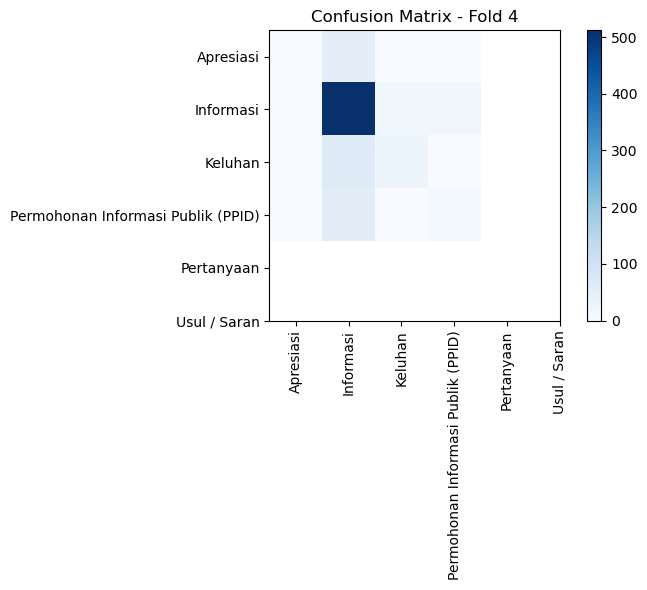

=========Fold :  4 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  50   2   1]
 [  0 512  19  17]
 [  0  63  27   0]
 [  0  57   1   8]]
Accuracy: 0.7225891677675033
Precision: [0.         0.75073314 0.55102041 0.30769231]
Recall: [0.         0.93430657 0.3        0.12121212]
F1-Score: [0.         0.83252033 0.38848921 0.17391304]
Processing time 0.01959824562072754
=========Macro Average=========
Precision Macro Avg : 0.40236146342137125
Recall Macro Avg: 0.3388796726387967
F1-Score Macro Avg: 0.34873064432865164
=========Micro Average=========
Precision Micro Avg: 0.7225891677675033
Recall Micro Avg: 0.7225891677675033
F1-Score Micro Avg: 0.7225891677675034
=========Weighted Average=========
Precision Weighted Avg: 0.6358009096078969
Recall Weighted Avg: 0.7225891677675033
F1-Score Weighted Avg: 0.6640203802614607




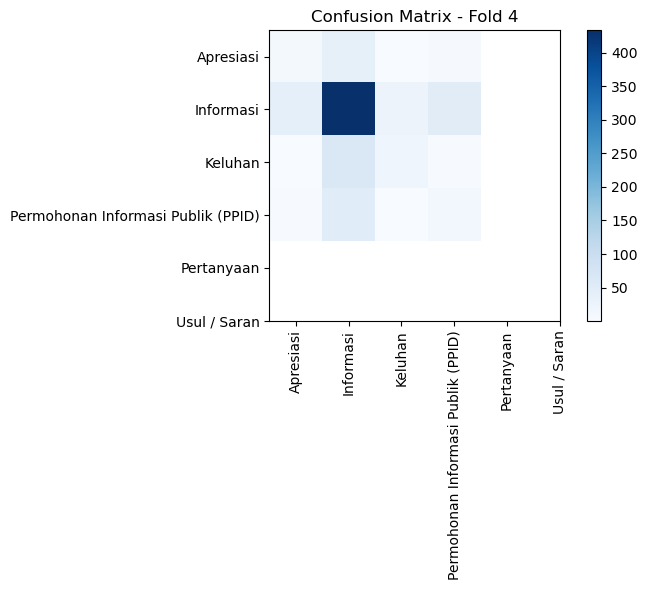

=========Fold :  4 =========
Classifier: GaussianNB
Confusion Matrix:
[[  8  37   2   6]
 [ 41 433  25  49]
 [  2  65  20   3]
 [  3  50   1  12]]
Accuracy: 0.6248348745046235
Precision: [0.14814815 0.74017094 0.41666667 0.17142857]
Recall: [0.1509434  0.79014599 0.22222222 0.18181818]
F1-Score: [0.14953271 0.76434245 0.28985507 0.17647059]
Processing time 2.712480068206787
=========Macro Average=========
Precision Macro Avg : 0.36910358160358164
Recall Macro Avg: 0.3362824464170698
F1-Score Macro Avg: 0.34505020616056953
=========Micro Average=========
Precision Micro Avg: 0.6248348745046235
Recall Micro Avg: 0.6248348745046235
F1-Score Micro Avg: 0.6248348745046235
=========Weighted Average=========
Precision Weighted Avg: 0.6106734647025267
Recall Weighted Avg: 0.6248348745046235
F1-Score Weighted Avg: 0.6136313257560975




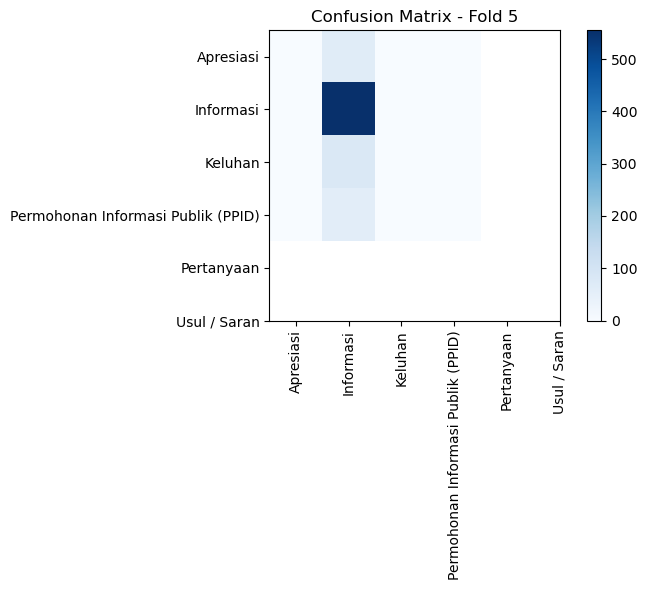

=========Fold :  5 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  63   0   0]
 [  0 555   0   0]
 [  0  82   0   0]
 [  0  57   0   0]]
Accuracy: 0.7331571994715984
Precision: [0.        0.7331572 0.        0.       ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.84603659 0.         0.        ]
Processing time 0.015518903732299805
=========Macro Average=========
Precision Macro Avg : 0.1832892998678996
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21150914634146342
=========Micro Average=========
Precision Micro Avg: 0.7331571994715984
Recall Micro Avg: 0.7331571994715984
F1-Score Micro Avg: 0.7331571994715984
=========Weighted Average=========
Precision Weighted Avg: 0.5375194791370371
Recall Weighted Avg: 0.7331571994715984
F1-Score Weighted Avg: 0.6202778135773432




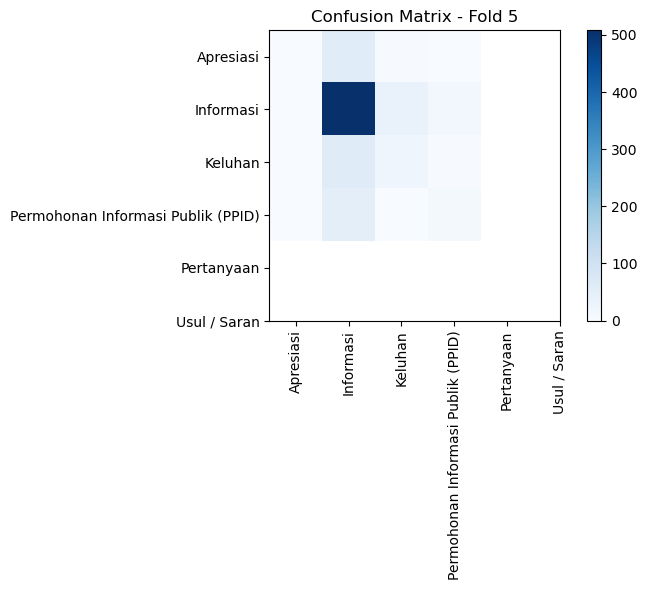

=========Fold :  5 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  59   3   1]
 [  0 508  35  12]
 [  0  60  20   2]
 [  0  48   1   8]]
Accuracy: 0.7080581241743725
Precision: [0.         0.75259259 0.33898305 0.34782609]
Recall: [0.         0.91531532 0.24390244 0.14035088]
F1-Score: [0.         0.82601626 0.28368794 0.2       ]
Processing time 0.018595218658447266
=========Macro Average=========
Precision Macro Avg : 0.359850432599143
Recall Macro Avg: 0.324892157883172
F1-Score Macro Avg: 0.3274260508562532
=========Micro Average=========
Precision Micro Avg: 0.7080581241743725
Recall Micro Avg: 0.7080581241743725
F1-Score Micro Avg: 0.7080581241743725
=========Weighted Average=========
Precision Weighted Avg: 0.6146784491610332
Recall Weighted Avg: 0.7080581241743725
F1-Score Weighted Avg: 0.6513889507764353




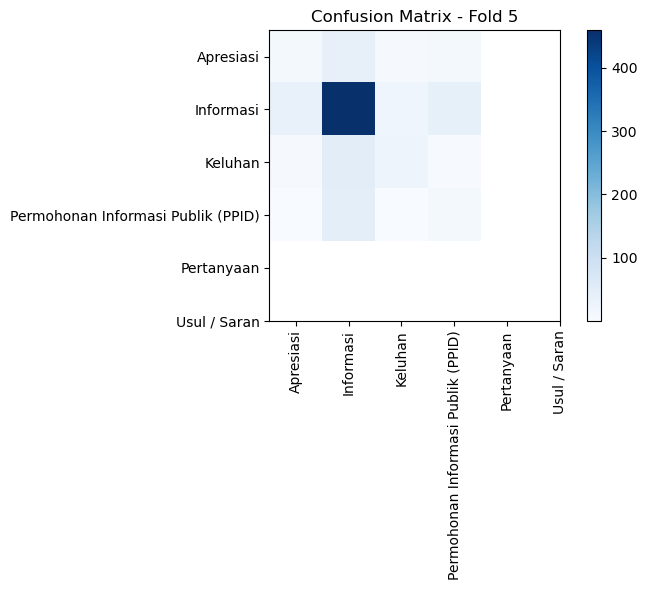

=========Fold :  5 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 11  38   5   9]
 [ 36 459  20  40]
 [  5  49  24   4]
 [  1  45   2   9]]
Accuracy: 0.6644649933949802
Precision: [0.20754717 0.77664975 0.47058824 0.14516129]
Recall: [0.17460317 0.82702703 0.29268293 0.15789474]
F1-Score: [0.18965517 0.80104712 0.36090226 0.1512605 ]
Processing time 2.705556869506836
=========Macro Average=========
Precision Macro Avg : 0.39998661040522815
Recall Macro Avg: 0.3630519663253938
F1-Score Macro Avg: 0.3757162631683549
=========Micro Average=========
Precision Micro Avg: 0.6644649933949802
Recall Micro Avg: 0.6644649933949802
F1-Score Micro Avg: 0.6644649933949802
=========Weighted Average=========
Precision Weighted Avg: 0.6485845570378781
Recall Weighted Avg: 0.6644649933949802
F1-Score Weighted Avg: 0.653560450986039




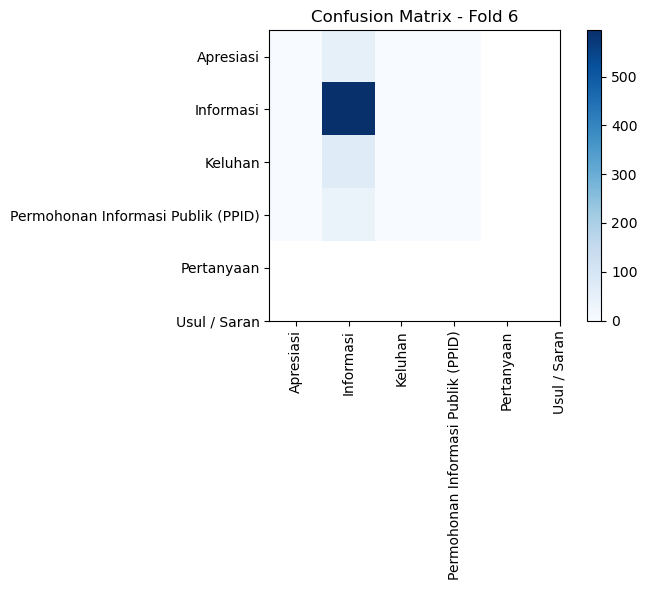

=========Fold :  6 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  51   0   0]
 [  0 595   0   0]
 [  0  72   0   0]
 [  0  39   0   0]]
Accuracy: 0.7859973579920739
Precision: [0.         0.78599736 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.88017751 0.         0.        ]
Processing time 0.015049934387207031
=========Macro Average=========
Precision Macro Avg : 0.19649933949801848
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.22004437869822485
=========Micro Average=========
Precision Micro Avg: 0.7859973579920739
Recall Micro Avg: 0.7859973579920739
F1-Score Micro Avg: 0.7859973579920739
=========Weighted Average=========
Precision Weighted Avg: 0.6177918467705205
Recall Weighted Avg: 0.7859973579920739
F1-Score Weighted Avg: 0.6918172011912486




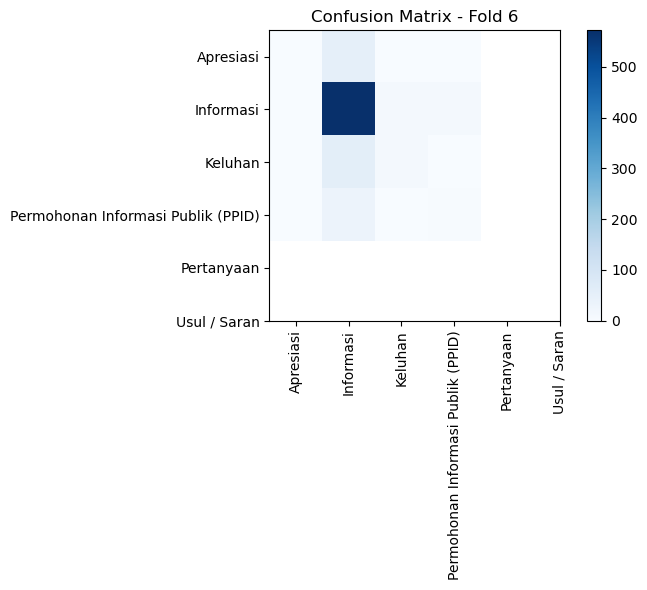

=========Fold :  6 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  51   0   0]
 [  0 572  12  11]
 [  0  58  13   1]
 [  0  33   2   4]]
Accuracy: 0.7780713342140027
Precision: [0.         0.80112045 0.48148148 0.25      ]
Recall: [0.         0.96134454 0.18055556 0.1025641 ]
F1-Score: [0.         0.87394958 0.26262626 0.14545455]
Processing time 0.021576881408691406
=========Macro Average=========
Precision Macro Avg : 0.3831504824151883
Recall Macro Avg: 0.31111604898369605
F1-Score Macro Avg: 0.32050759697818526
=========Micro Average=========
Precision Micro Avg: 0.7780713342140027
Recall Micro Avg: 0.7780713342140027
F1-Score Micro Avg: 0.7780713342140027
=========Weighted Average=========
Precision Weighted Avg: 0.6883531483927786
Recall Weighted Avg: 0.7780713342140027
F1-Score Weighted Avg: 0.7193947400024019




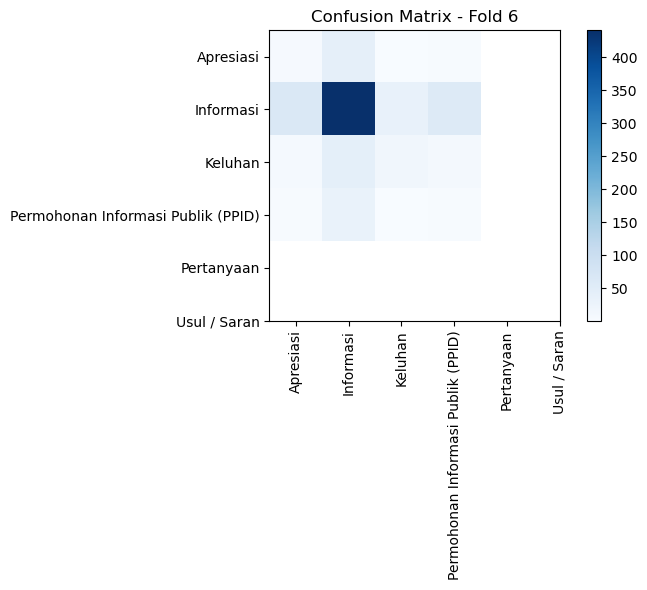

=========Fold :  6 =========
Classifier: GaussianNB
Confusion Matrix:
[[  6  40   2   3]
 [ 63 441  32  59]
 [  7  41  15   9]
 [  3  31   1   4]]
Accuracy: 0.6155878467635403
Precision: [0.07594937 0.79746835 0.3        0.05333333]
Recall: [0.11764706 0.74117647 0.20833333 0.1025641 ]
F1-Score: [0.09230769 0.76829268 0.24590164 0.07017544]
Processing time 3.4614267349243164
=========Macro Average=========
Precision Macro Avg : 0.30668776371308015
Recall Macro Avg: 0.29243024132730017
F1-Score Macro Avg: 0.29416936329381876
=========Micro Average=========
Precision Micro Avg: 0.6155878467635403
Recall Micro Avg: 0.6155878467635403
F1-Score Micro Avg: 0.6155878467635403
=========Weighted Average=========
Precision Weighted Avg: 0.663206193669214
Recall Weighted Avg: 0.6155878467635403
F1-Score Weighted Avg: 0.6370985452935347




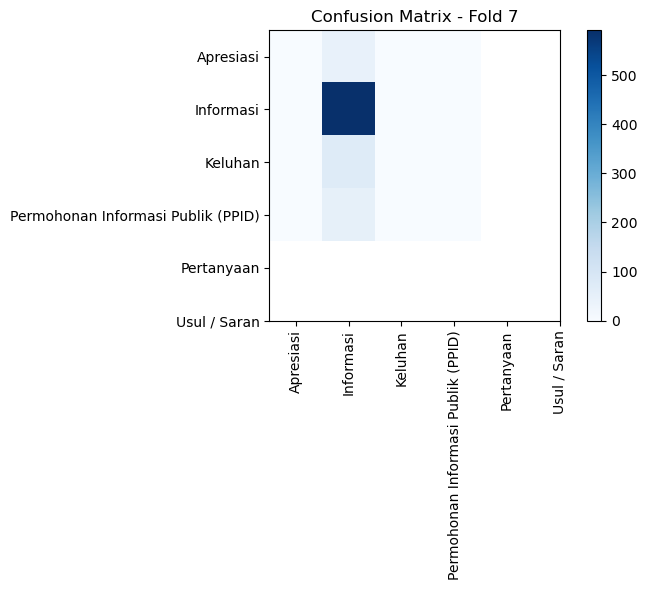

=========Fold :  7 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  43   0   0]
 [  0 592   0   0]
 [  0  72   0   0]
 [  0  50   0   0]]
Accuracy: 0.7820343461030383
Precision: [0.         0.78203435 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.87768718 0.         0.        ]
Processing time 0.014492034912109375
=========Macro Average=========
Precision Macro Avg : 0.1955085865257596
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21942179392142327
=========Micro Average=========
Precision Micro Avg: 0.7820343461030383
Recall Micro Avg: 0.7820343461030383
F1-Score Micro Avg: 0.7820343461030383
=========Weighted Average=========
Precision Weighted Avg: 0.6115777184848067
Recall Weighted Avg: 0.7820343461030383
F1-Score Weighted Avg: 0.6863815165203835




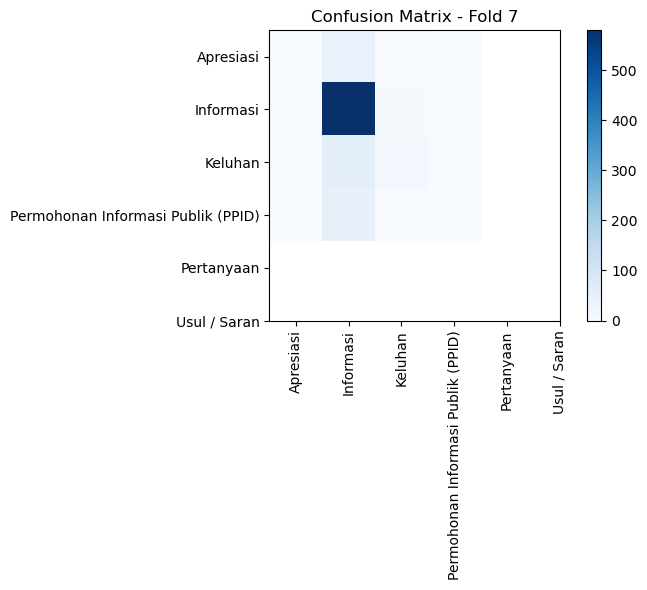

=========Fold :  7 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  39   3   1]
 [  0 580   9   3]
 [  0  58  14   0]
 [  0  47   3   0]]
Accuracy: 0.7846763540290621
Precision: [0.         0.80110497 0.48275862 0.        ]
Recall: [0.         0.97972973 0.19444444 0.        ]
F1-Score: [0.         0.88145897 0.27722772 0.        ]
Processing time 0.016618967056274414
=========Macro Average=========
Precision Macro Avg : 0.3209658982663364
Recall Macro Avg: 0.29354354354354356
F1-Score Macro Avg: 0.28967167233440666
=========Micro Average=========
Precision Micro Avg: 0.7846763540290621
Recall Micro Avg: 0.7846763540290621
F1-Score Micro Avg: 0.7846763540290621
=========Weighted Average=========
Precision Weighted Avg: 0.6724078789115773
Recall Weighted Avg: 0.7846763540290621
F1-Score Weighted Avg: 0.7156989488061967




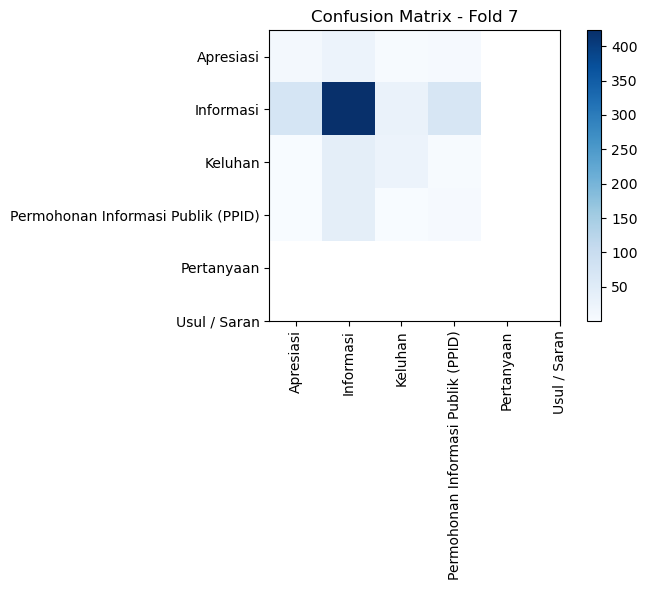

=========Fold :  7 =========
Classifier: GaussianNB
Confusion Matrix:
[[  9  25   4   5]
 [ 73 423  28  68]
 [  1  42  25   4]
 [  2  41   2   5]]
Accuracy: 0.6103038309114928
Precision: [0.10588235 0.79661017 0.42372881 0.06097561]
Recall: [0.20930233 0.71452703 0.34722222 0.1       ]
F1-Score: [0.140625   0.75333927 0.38167939 0.07575758]
Processing time 2.8636457920074463
=========Macro Average=========
Precision Macro Avg : 0.34679923643703037
Recall Macro Avg: 0.34276289370766116
F1-Score Macro Avg: 0.3378503087208884
=========Micro Average=========
Precision Micro Avg: 0.6103038309114928
Recall Micro Avg: 0.6103038309114928
F1-Score Micro Avg: 0.6103038309114928
=========Weighted Average=========
Precision Weighted Avg: 0.6733202332622585
Recall Weighted Avg: 0.6103038309114927
F1-Score Weighted Avg: 0.6384313309745174




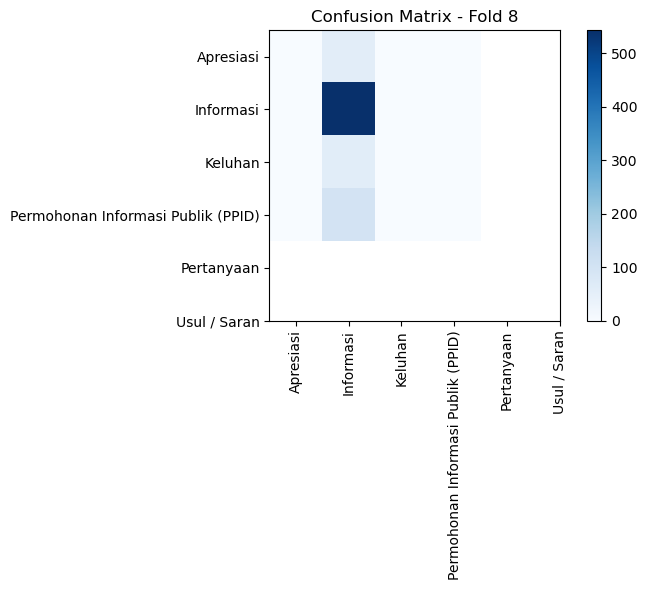

=========Fold :  8 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  57   0   0]
 [  0 543   0   0]
 [  0  59   0   0]
 [  0  98   0   0]]
Accuracy: 0.7173051519154557
Precision: [0.         0.71730515 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.83538462 0.         0.        ]
Processing time 0.015220165252685547
=========Macro Average=========
Precision Macro Avg : 0.17932628797886394
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.20884615384615382
=========Micro Average=========
Precision Micro Avg: 0.7173051519154557
Recall Micro Avg: 0.7173051519154557
F1-Score Micro Avg: 0.7173051519154559
=========Weighted Average=========
Precision Weighted Avg: 0.5145266809644551
Recall Weighted Avg: 0.7173051519154557
F1-Score Weighted Avg: 0.5992256884462961




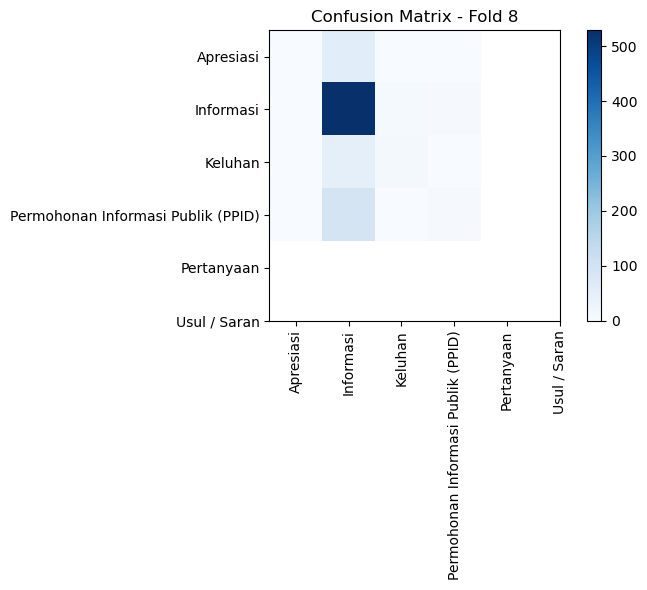

=========Fold :  8 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  56   1   0]
 [  0 529   8   6]
 [  0  49   9   1]
 [  0  92   0   6]]
Accuracy: 0.7186261558784677
Precision: [0.         0.72865014 0.5        0.46153846]
Recall: [0.         0.97421731 0.15254237 0.06122449]
F1-Score: [0.         0.83372734 0.23376623 0.10810811]
Processing time 0.02071404457092285
=========Macro Average=========
Precision Macro Avg : 0.42254714981987707
Recall Macro Avg: 0.29699604347779
F1-Score Macro Avg: 0.293900421559996
=========Micro Average=========
Precision Micro Avg: 0.7186261558784677
Recall Micro Avg: 0.7186261558784677
F1-Score Micro Avg: 0.7186261558784677
=========Weighted Average=========
Precision Weighted Avg: 0.6213841400583324
Recall Weighted Avg: 0.7186261558784677
F1-Score Weighted Avg: 0.6302519820044201




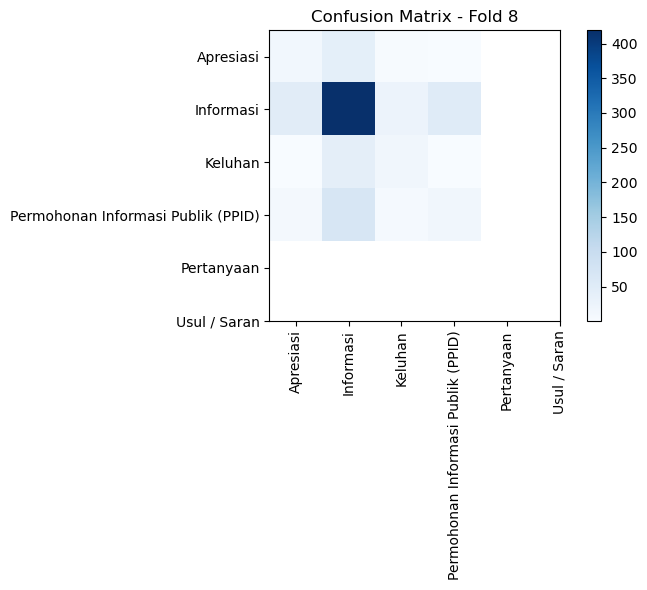

=========Fold :  8 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 13  39   3   2]
 [ 48 419  25  51]
 [  1  41  15   2]
 [  8  69   6  15]]
Accuracy: 0.6103038309114928
Precision: [0.18571429 0.73767606 0.30612245 0.21428571]
Recall: [0.22807018 0.77163904 0.25423729 0.15306122]
F1-Score: [0.20472441 0.75427543 0.27777778 0.17857143]
Processing time 2.944797992706299
=========Macro Average=========
Precision Macro Avg : 0.36094962632940497
Recall Macro Avg: 0.351751932605315
F1-Score Macro Avg: 0.3538372608351949
=========Micro Average=========
Precision Micro Avg: 0.6103038309114928
Recall Micro Avg: 0.6103038309114928
F1-Score Micro Avg: 0.6103038309114928
=========Weighted Average=========
Precision Weighted Avg: 0.5947226385298011
Recall Weighted Avg: 0.6103038309114928
F1-Score Weighted Avg: 0.6012281867677506




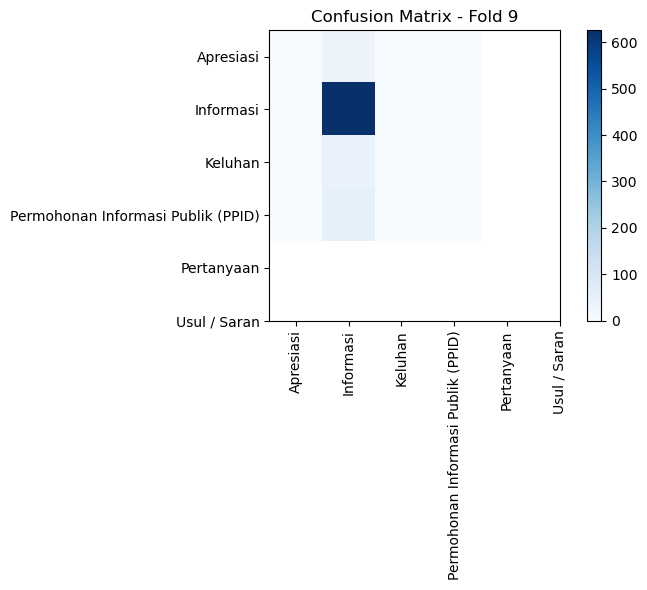

=========Fold :  9 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  36   0   0]
 [  0 626   0   0]
 [  0  43   0   0]
 [  0  52   0   0]]
Accuracy: 0.8269484808454426
Precision: [0.         0.82694848 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.90527838 0.         0.        ]
Processing time 0.014438152313232422
=========Macro Average=========
Precision Macro Avg : 0.20673712021136065
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.22631959508315258
=========Micro Average=========
Precision Micro Avg: 0.8269484808454426
Recall Micro Avg: 0.8269484808454426
F1-Score Micro Avg: 0.8269484808454426
=========Weighted Average=========
Precision Weighted Avg: 0.6838437899725853
Recall Weighted Avg: 0.8269484808454426
F1-Score Weighted Avg: 0.7486185813582747




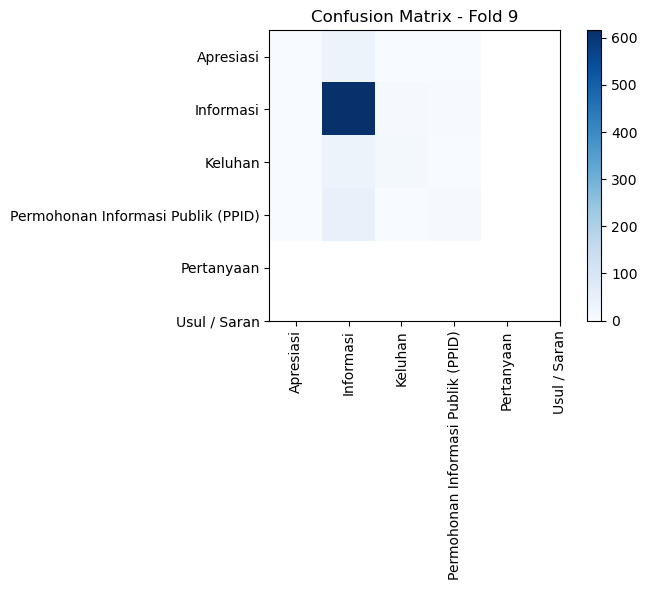

=========Fold :  9 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  36   0   0]
 [  0 616   7   3]
 [  0  33  10   0]
 [  0  46   1   5]]
Accuracy: 0.8335535006605019
Precision: [0.         0.84268126 0.55555556 0.625     ]
Recall: [0.         0.98402556 0.23255814 0.09615385]
F1-Score: [0.         0.90788504 0.32786885 0.16666667]
Processing time 0.01858210563659668
=========Macro Average=========
Precision Macro Avg : 0.5058092035263718
Recall Macro Avg: 0.32818438619854035
F1-Score Macro Avg: 0.35060513991406633
=========Micro Average=========
Precision Micro Avg: 0.8335535006605019
Recall Micro Avg: 0.8335535006605019
F1-Score Micro Avg: 0.833553500660502
=========Weighted Average=========
Precision Weighted Avg: 0.7713439322868509
Recall Weighted Avg: 0.8335535006605019
F1-Score Weighted Avg: 0.780846846360038




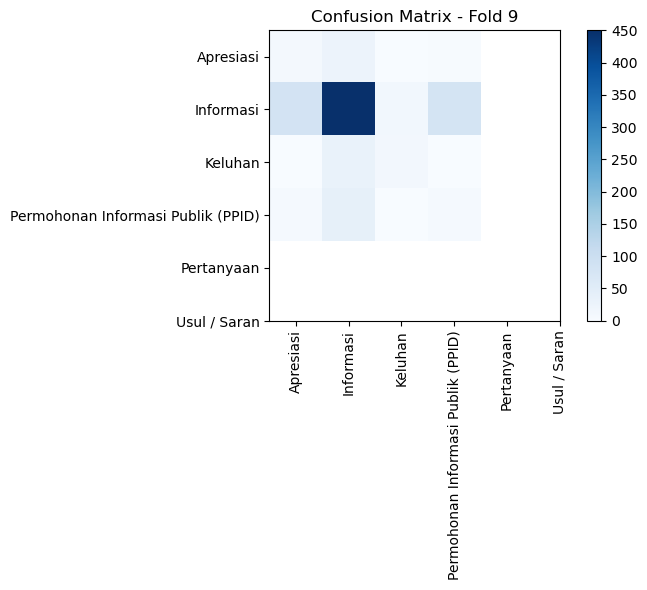

=========Fold :  9 =========
Classifier: GaussianNB
Confusion Matrix:
[[  8  25   0   3]
 [ 82 450  14  80]
 [  1  30  11   1]
 [  7  38   1   6]]
Accuracy: 0.6274768824306473
Precision: [0.08163265 0.82872928 0.42307692 0.06666667]
Recall: [0.22222222 0.71884984 0.25581395 0.11538462]
F1-Score: [0.11940299 0.76988879 0.31884058 0.08450704]
Processing time 3.416684150695801
=========Macro Average=========
Precision Macro Avg : 0.3500263811431925
Recall Macro Avg: 0.3280676578377002
F1-Score Macro Avg: 0.32315985021979565
=========Micro Average=========
Precision Micro Avg: 0.6274768824306473
Recall Micro Avg: 0.6274768824306473
F1-Score Micro Avg: 0.6274768824306473
=========Weighted Average=========
Precision Weighted Avg: 0.7178101456485058
Recall Weighted Avg: 0.6274768824306473
F1-Score Weighted Avg: 0.666252844824046




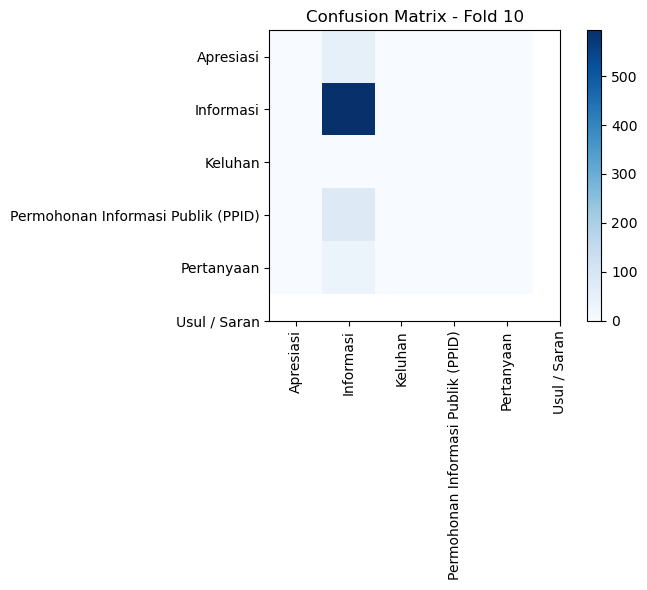

=========Fold :  10 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  50   0   0   0]
 [  0 594   0   0   0]
 [  0   1   0   0   0]
 [  0  75   0   0   0]
 [  0  37   0   0   0]]
Accuracy: 0.7846763540290621
Precision: [0.         0.78467635 0.         0.         0.        ]
Recall: [0. 1. 0. 0. 0.]
F1-Score: [0.         0.87934863 0.         0.         0.        ]
Processing time 0.020225048065185547
=========Macro Average=========
Precision Macro Avg : 0.15693527080581243
Recall Macro Avg: 0.2
F1-Score Macro Avg: 0.17586972612879348
=========Micro Average=========
Precision Micro Avg: 0.7846763540290621
Recall Micro Avg: 0.7846763540290621
F1-Score Micro Avg: 0.7846763540290621
=========Weighted Average=========
Precision Weighted Avg: 0.615716980572342
Recall Weighted Avg: 0.7846763540290621
F1-Score Weighted Avg: 0.6900040774141568




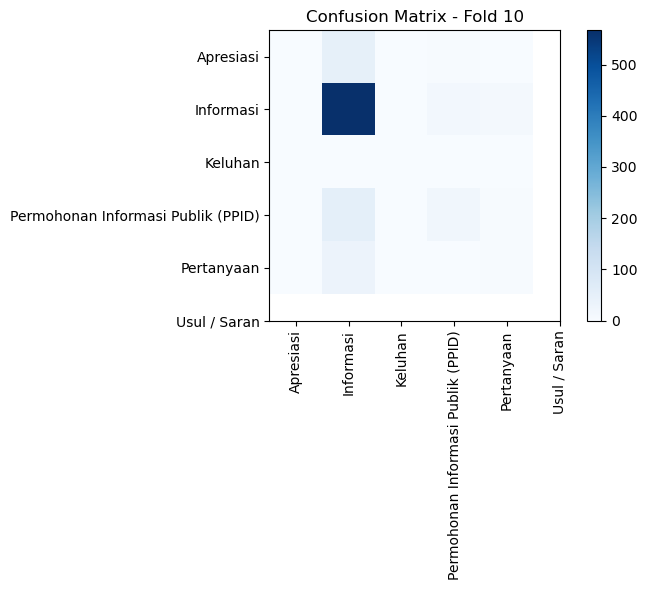

=========Fold :  10 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  47   0   3   0]
 [  0 567   0  15  12]
 [  0   0   0   1   0]
 [  0  53   0  19   3]
 [  0  33   0   0   4]]
Accuracy: 0.7793923381770145
Precision: [0.         0.81       0.         0.5        0.21052632]
Recall: [0.         0.95454545 0.         0.25333333 0.10810811]
F1-Score: [0.         0.8763524  0.         0.33628319 0.14285714]
Processing time 0.01959395408630371
=========Macro Average=========
Precision Macro Avg : 0.30410526315789477
Recall Macro Avg: 0.26319737919737923
F1-Score Macro Avg: 0.27109854487403695
=========Micro Average=========
Precision Micro Avg: 0.7793923381770145
Recall Micro Avg: 0.7793923381770145
F1-Score Micro Avg: 0.7793923381770145
=========Weighted Average=========
Precision Weighted Avg: 0.6954154209831052
Recall Weighted Avg: 0.7793923381770145
F1-Score Weighted Avg: 0.7279528087888161




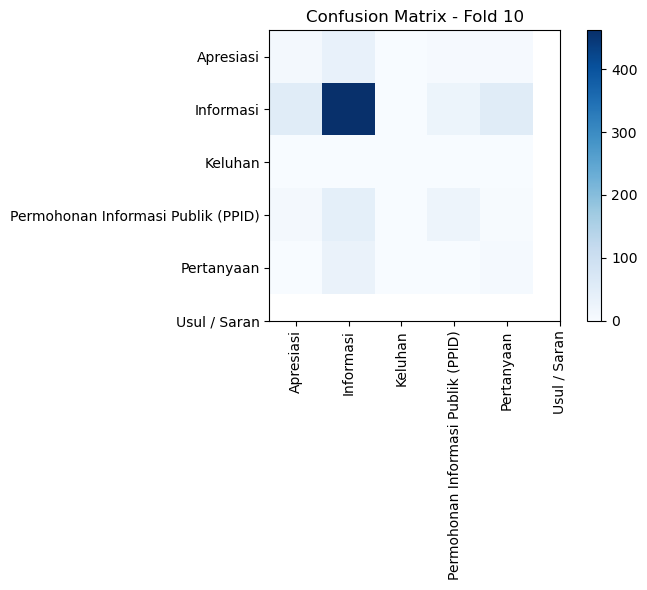

=========Fold :  10 =========
Classifier: GaussianNB
Confusion Matrix:
[[  8  33   0   4   5]
 [ 53 462   0  25  54]
 [  0   1   0   0   0]
 [  8  42   0  22   3]
 [  0  30   0   1   6]]
Accuracy: 0.6578599735799208
Precision: [0.11594203 0.81338028 0.         0.42307692 0.08823529]
Recall: [0.16       0.77777778 0.         0.29333333 0.16216216]
F1-Score: [0.13445378 0.79518072 0.         0.34645669 0.11428571]
Processing time 3.239388942718506
=========Macro Average=========
Precision Macro Avg : 0.28812690557404363
Recall Macro Avg: 0.2786546546546547
F1-Score Macro Avg: 0.2780753823206543
=========Micro Average=========
Precision Micro Avg: 0.6578599735799208
Recall Micro Avg: 0.6578599735799208
F1-Score Micro Avg: 0.6578599735799208
=========Weighted Average=========
Precision Weighted Avg: 0.6921274291761443
Recall Weighted Avg: 0.6578599735799208
F1-Score Weighted Avg: 0.6727514687850675


======5-FOLD CROSS VALIDATION FOR 75% DATA======
K-Fold = 5
Data Deskripsi Array Len = 113

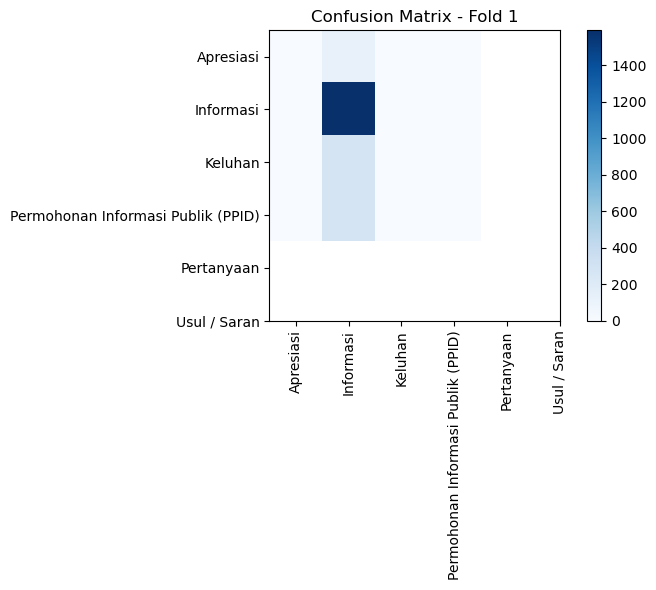

=========Fold :  1 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  123    0    0]
 [   0 1592    0    0]
 [   0  280    0    0]
 [   0  277    0    0]]
Accuracy: 0.7007042253521126
Precision: [0.         0.70070423 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.82401656 0.         0.        ]
Processing time 0.0190279483795166
=========Macro Average=========
Precision Macro Avg : 0.17517605633802816
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2060041407867495
=========Micro Average=========
Precision Micro Avg: 0.7007042253521126
Recall Micro Avg: 0.7007042253521126
F1-Score Micro Avg: 0.7007042253521126
=========Weighted Average=========
Precision Weighted Avg: 0.4909864114263042
Recall Weighted Avg: 0.7007042253521126
F1-Score Weighted Avg: 0.5773918875572275




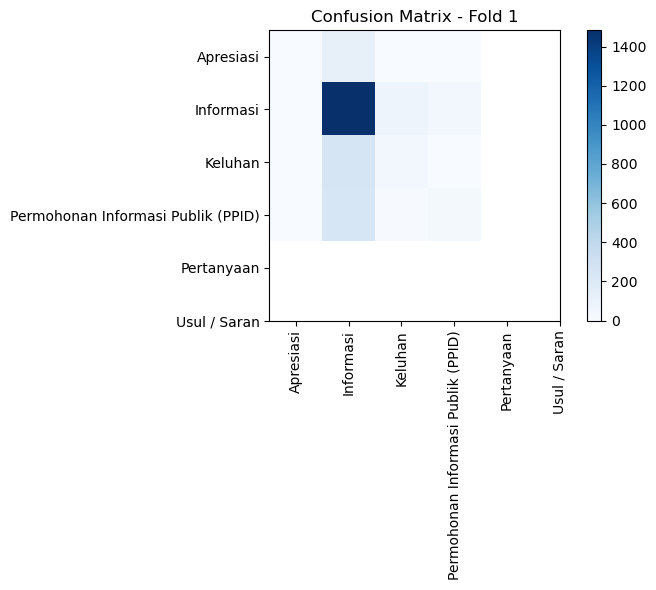

=========Fold :  1 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0  116    3    4]
 [   0 1483   72   37]
 [   0  244   35    1]
 [   0  235    9   33]]
Accuracy: 0.6826584507042254
Precision: [0.         0.71366699 0.29411765 0.44      ]
Recall: [0.         0.93153266 0.125      0.11913357]
F1-Score: [0.         0.80817439 0.1754386  0.1875    ]
Processing time 0.023770809173583984
=========Macro Average=========
Precision Macro Avg : 0.36194615863669816
Recall Macro Avg: 0.29391655933095073
F1-Score Macro Avg: 0.29277824585305223
=========Micro Average=========
Precision Micro Avg: 0.6826584507042254
Recall Micro Avg: 0.6826584507042254
F1-Score Micro Avg: 0.6826584507042254
=========Weighted Average=========
Precision Weighted Avg: 0.589960732947763
Recall Weighted Avg: 0.6826584507042254
F1-Score Weighted Avg: 0.6107719766706626




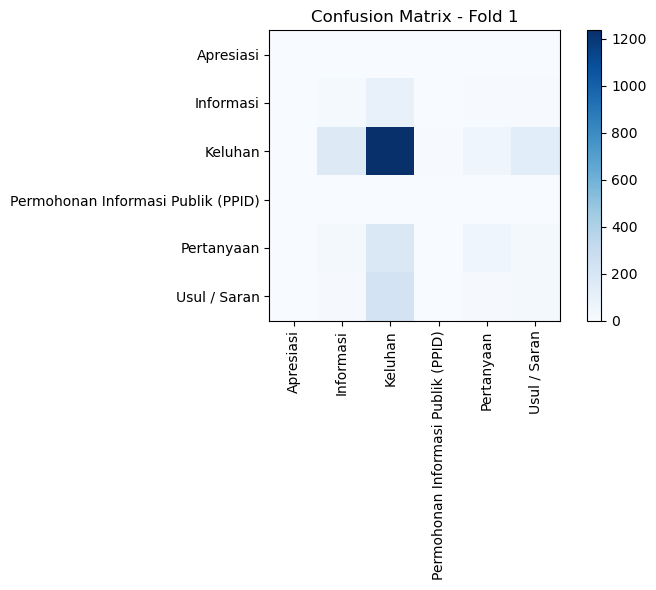

=========Fold :  1 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    0    0    0    0]
 [   0   16   95    0    7    5]
 [   1  164 1236    5   54  132]
 [   0    0    0    0    0    0]
 [   0   25  180    0   49   26]
 [   0   13  223    4   10   27]]
Accuracy: 0.5845070422535211
Precision: [0.         0.0733945  0.71280277 0.         0.40833333 0.14210526]
Recall: [0.         0.1300813  0.77638191 0.         0.175      0.09747292]
F1-Score: [0.         0.09384164 0.74323512 0.         0.245      0.11563169]
Processing time 7.42005181312561
=========Macro Average=========
Precision Macro Avg : 0.22277264334502703
Recall Macro Avg: 0.19648935575807877
F1-Score Macro Avg: 0.1996180751892548
=========Micro Average=========
Precision Micro Avg: 0.5845070422535211
Recall Micro Avg: 0.5845070422535211
F1-Score Micro Avg: 0.5845070422535211
=========Weighted Average=========
Precision Weighted Avg: 0.57108539660399
Recall Weighted Avg: 0.5845070422535211
F1-Score Weighted Avg

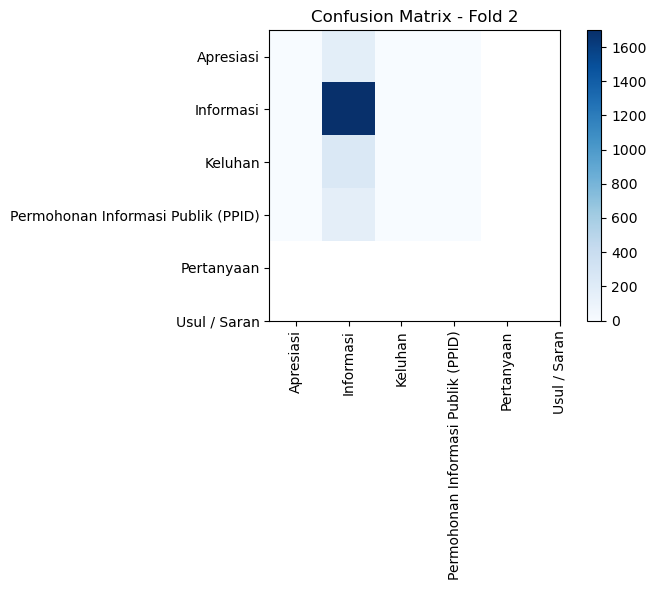

=========Fold :  2 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  167    0    0]
 [   0 1698    0    0]
 [   0  244    0    0]
 [   0  163    0    0]]
Accuracy: 0.7473591549295775
Precision: [0.         0.74735915 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.85541562 0.         0.        ]
Processing time 0.020437002182006836
=========Macro Average=========
Precision Macro Avg : 0.18683978873239437
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21385390428211587
=========Micro Average=========
Precision Micro Avg: 0.7473591549295775
Recall Micro Avg: 0.7473591549295775
F1-Score Micro Avg: 0.7473591549295775
=========Weighted Average=========
Precision Weighted Avg: 0.5585457064570521
Recall Weighted Avg: 0.7473591549295775
F1-Score Weighted Avg: 0.6393026927306914




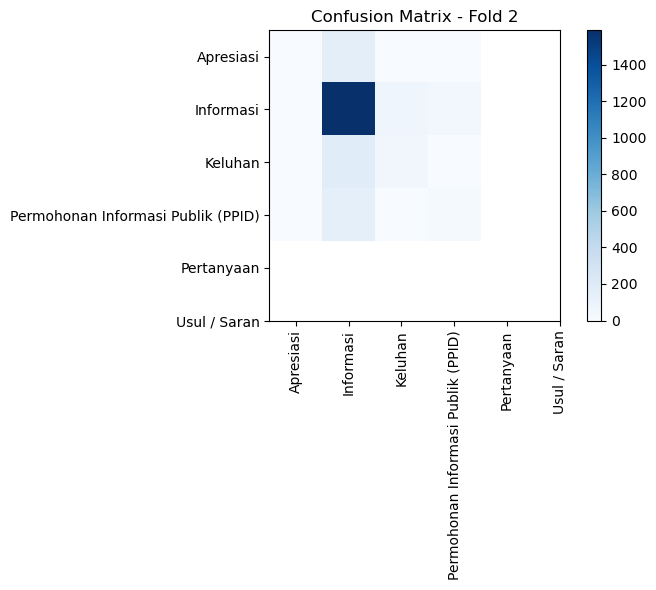

=========Fold :  2 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0  161    3    3]
 [   2 1587   69   40]
 [   0  185   55    4]
 [   0  138    4   21]]
Accuracy: 0.7319542253521126
Precision: [0.         0.76629648 0.41984733 0.30882353]
Recall: [0.         0.93462898 0.22540984 0.12883436]
F1-Score: [0.         0.84213319 0.29333333 0.18181818]
Processing time 0.02535700798034668
=========Macro Average=========
Precision Macro Avg : 0.3737418331972064
Recall Macro Avg: 0.32221829178970307
F1-Score Macro Avg: 0.3293211767448966
=========Micro Average=========
Precision Micro Avg: 0.7319542253521126
Recall Micro Avg: 0.7319542253521126
F1-Score Micro Avg: 0.7319542253521126
=========Weighted Average=========
Precision Weighted Avg: 0.6399438372188343
Recall Weighted Avg: 0.7319542253521126
F1-Score Weighted Avg: 0.6739224721363388




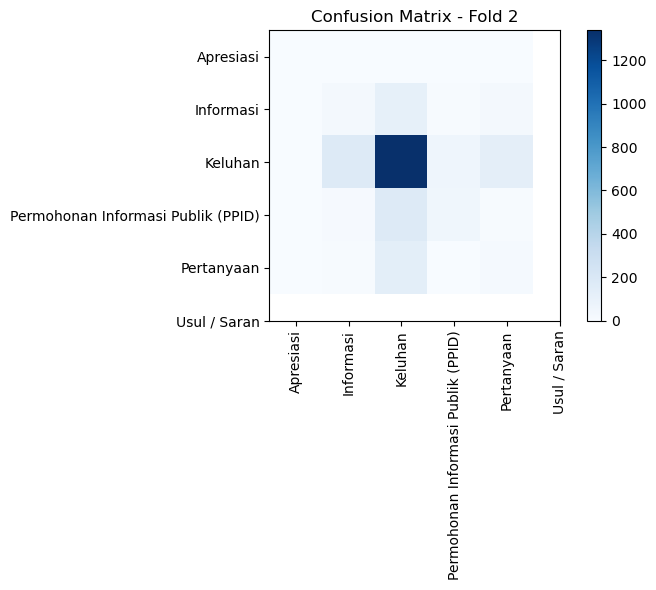

=========Fold :  2 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    0    0    0]
 [   0   26  114    6   21]
 [   1  172 1338   60  127]
 [   0   13  171   51    9]
 [   0    6  134    3   20]]
Accuracy: 0.6316021126760564
Precision: [0.         0.11981567 0.76152533 0.425      0.11299435]
Recall: [0.         0.15568862 0.78798587 0.20901639 0.12269939]
F1-Score: [0.         0.13541667 0.77452967 0.28021978 0.11764706]
Processing time 6.531035900115967
=========Macro Average=========
Precision Macro Avg : 0.28386706914952603
Recall Macro Avg: 0.2550780536849126
F1-Score Macro Avg: 0.2615626345718072
=========Micro Average=========
Precision Micro Avg: 0.6316021126760564
Recall Micro Avg: 0.6316021126760564
F1-Score Micro Avg: 0.6316021126760564
=========Weighted Average=========
Precision Weighted Avg: 0.6316889530710506
Recall Weighted Avg: 0.6316021126760564
F1-Score Weighted Avg: 0.627339812990448




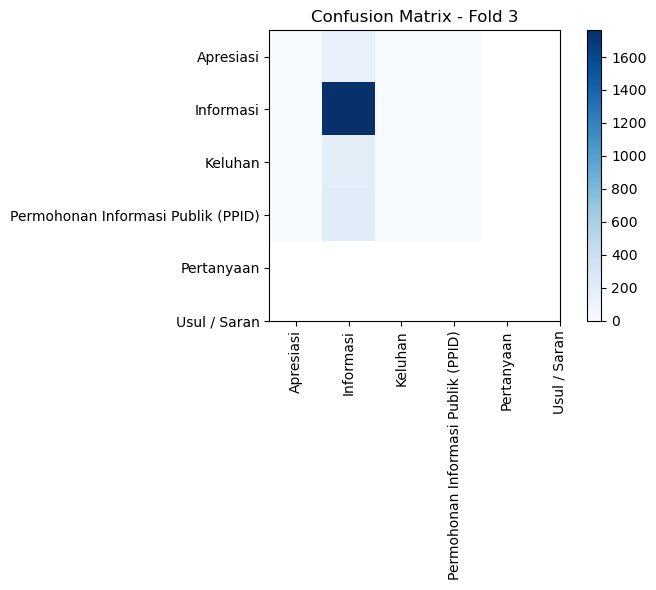

=========Fold :  3 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  136    0    0]
 [   0 1762    0    0]
 [   0  174    0    0]
 [   0  200    0    0]]
Accuracy: 0.7755281690140845
Precision: [0.         0.77552817 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.87357462 0.         0.        ]
Processing time 0.0227510929107666
=========Macro Average=========
Precision Macro Avg : 0.19388204225352113
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21839365394149726
=========Micro Average=========
Precision Micro Avg: 0.7755281690140845
Recall Micro Avg: 0.7755281690140845
F1-Score Micro Avg: 0.7755281690140845
=========Weighted Average=========
Precision Weighted Avg: 0.6014439409343384
Recall Weighted Avg: 0.7755281690140845
F1-Score Weighted Avg: 0.6774817222621798




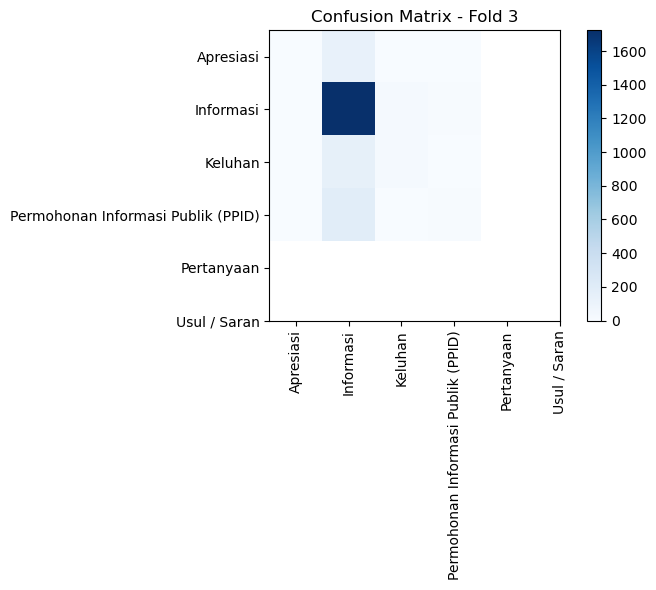

=========Fold :  3 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0  130    3    3]
 [   0 1723   26   13]
 [   0  147   26    1]
 [   0  184    6   10]]
Accuracy: 0.7742077464788732
Precision: [0.         0.78891941 0.42622951 0.37037037]
Recall: [0.         0.97786606 0.14942529 0.05      ]
F1-Score: [0.         0.87328941 0.2212766  0.08810573]
Processing time 0.025274038314819336
=========Macro Average=========
Precision Macro Avg : 0.39637982312162634
Recall Macro Avg: 0.2943228371625765
F1-Score Macro Avg: 0.29566793240283806
=========Micro Average=========
Precision Micro Avg: 0.7742077464788732
Recall Micro Avg: 0.7742077464788732
F1-Score Micro Avg: 0.7742077464788732
=========Weighted Average=========
Precision Weighted Avg: 0.677074830909468
Recall Weighted Avg: 0.7742077464788732
F1-Score Weighted Avg: 0.7019626796470951




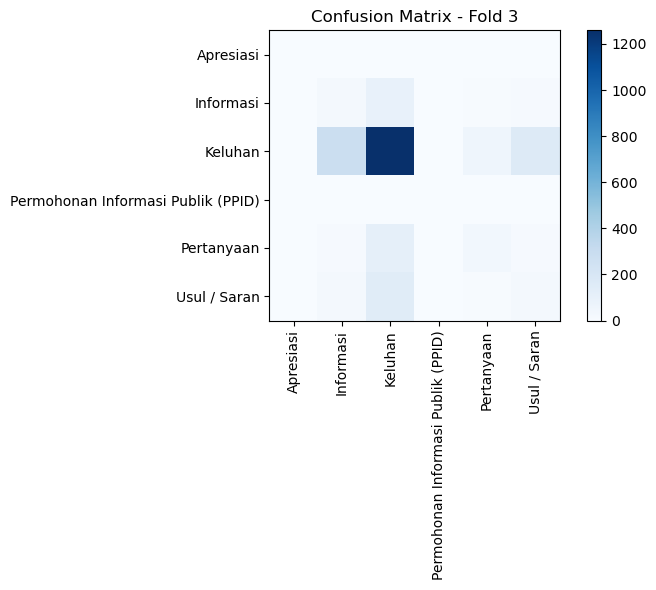

=========Fold :  3 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    0    0    0    0]
 [   0   23   94    0    8   11]
 [   1  277 1259    1   58  166]
 [   0    0    0    0    0    0]
 [   0   13  111    0   37   13]
 [   0   23  146    0    8   23]]
Accuracy: 0.590669014084507
Precision: [0.         0.06845238 0.78198758 0.         0.33333333 0.10798122]
Recall: [0.         0.16911765 0.71452894 0.         0.21264368 0.115     ]
F1-Score: [0.         0.09745763 0.74673784 0.         0.25964912 0.11138015]
Processing time 6.936482191085815
=========Macro Average=========
Precision Macro Avg : 0.21529241876379046
Recall Macro Avg: 0.20188171160018797
F1-Score Macro Avg: 0.2025374560413338
=========Micro Average=========
Precision Micro Avg: 0.590669014084507
Recall Micro Avg: 0.590669014084507
F1-Score Micro Avg: 0.590669014084507
=========Weighted Average=========
Precision Weighted Avg: 0.6455844541118932
Recall Weighted Avg: 0.590669014084507
F1-Score Weighted Avg: 

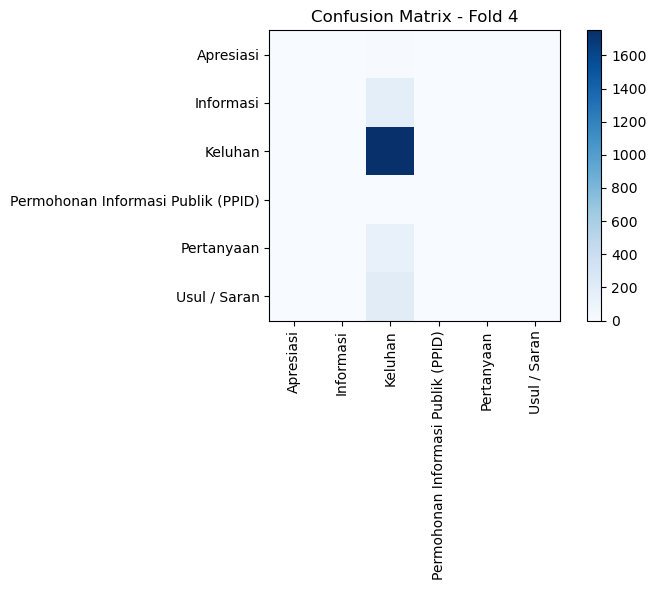

=========Fold :  4 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0   10    0    0    0]
 [   0    0  172    0    0    0]
 [   0    0 1751    0    0    0]
 [   0    0    6    0    0    0]
 [   0    0  135    0    0    0]
 [   0    0  198    0    0    0]]
Accuracy: 0.7706866197183099
Precision: [0.         0.         0.77068662 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.87049466 0.         0.         0.        ]
Processing time 0.019219160079956055
=========Macro Average=========
Precision Macro Avg : 0.12844776995305165
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.1450824426215925
=========Micro Average=========
Precision Micro Avg: 0.7706866197183099
Recall Micro Avg: 0.7706866197183099
F1-Score Micro Avg: 0.77068661971831
=========Weighted Average=========
Precision Weighted Avg: 0.5939578658128348
Recall Weighted Avg: 0.7706866197183099
F1-Score Weighted Avg: 0.6708785837070645




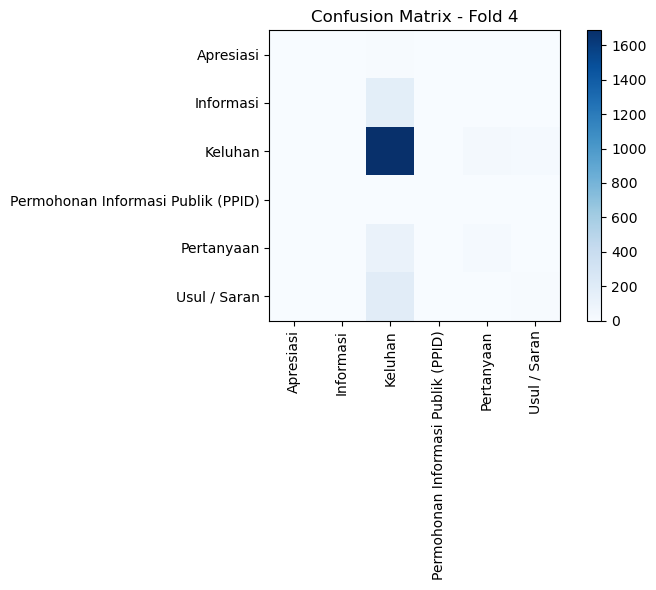

=========Fold :  4 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0   10    0    0    0]
 [   0    0  166    0    5    1]
 [   0    0 1688    0   38   25]
 [   0    0    2    0    4    0]
 [   0    0  109    0   23    3]
 [   0    0  185    0    3   10]]
Accuracy: 0.7574823943661971
Precision: [0.         0.         0.78148148 0.         0.31506849 0.25641026]
Recall: [0.         0.         0.96402056 0.         0.17037037 0.05050505]
F1-Score: [0.         0.         0.86320634 0.         0.22115385 0.08438819]
Processing time 0.024553775787353516
=========Macro Average=========
Precision Macro Avg : 0.22549337184040377
Recall Macro Avg: 0.19748266342593393
F1-Score Macro Avg: 0.19479139548284838
=========Micro Average=========
Precision Micro Avg: 0.7574823943661971
Recall Micro Avg: 0.7574823943661971
F1-Score Micro Avg: 0.7574823943661971
=========Weighted Average=========
Precision Weighted Avg: 0.6433439927018694
Recall Weighted Avg: 0.7574823943661971
F1-Score Weig

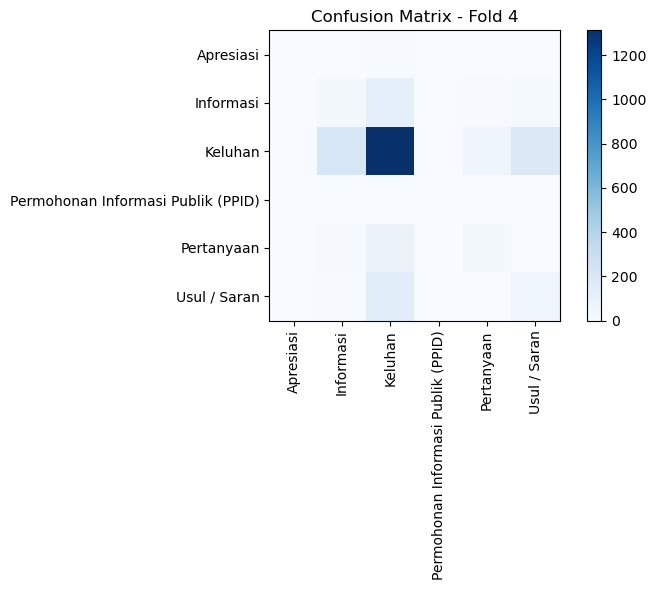

=========Fold :  4 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    2    7    0    0    1]
 [   0   23  121    0   10   18]
 [   0  202 1312    1   55  181]
 [   0    1    5    0    0    0]
 [   0   15   86    0   30    4]
 [   0    8  139    0    3   48]]
Accuracy: 0.621919014084507
Precision: [0.         0.09163347 0.78562874 0.         0.30612245 0.19047619]
Recall: [0.         0.13372093 0.74928612 0.         0.22222222 0.24242424]
F1-Score: [0.         0.10874704 0.76702719 0.         0.25751073 0.21333333]
Processing time 7.0309178829193115
=========Macro Average=========
Precision Macro Avg : 0.22897680801770173
Recall Macro Avg: 0.22460891951581655
F1-Score Macro Avg: 0.2244363821496568
=========Micro Average=========
Precision Micro Avg: 0.621919014084507
Recall Micro Avg: 0.621919014084507
F1-Score Micro Avg: 0.621919014084507
=========Weighted Average=========
Precision Weighted Avg: 0.6471996921855379
Recall Weighted Avg: 0.621919014084507
F1-Score Weighted Avg:

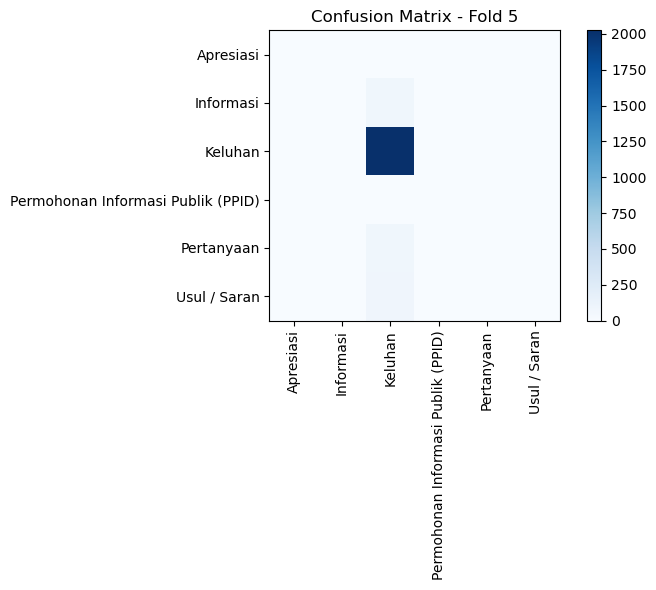

=========Fold :  5 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0    3    0    0    0]
 [   0    0   78    0    0    0]
 [   0    0 2025    0    0    0]
 [   0    0    7    0    0    0]
 [   0    0   76    0    0    0]
 [   0    0   83    0    0    0]]
Accuracy: 0.8912852112676056
Precision: [0.         0.         0.89128521 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.94251804 0.         0.         0.        ]
Processing time 0.01960611343383789
=========Macro Average=========
Precision Macro Avg : 0.1485475352112676
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.1570863393064929
=========Micro Average=========
Precision Micro Avg: 0.8912852112676056
Recall Micro Avg: 0.8912852112676056
F1-Score Micro Avg: 0.8912852112676056
=========Weighted Average=========
Precision Weighted Avg: 0.7943893278243404
Recall Weighted Avg: 0.8912852112676056
F1-Score Weighted Avg: 0.8400523866962538




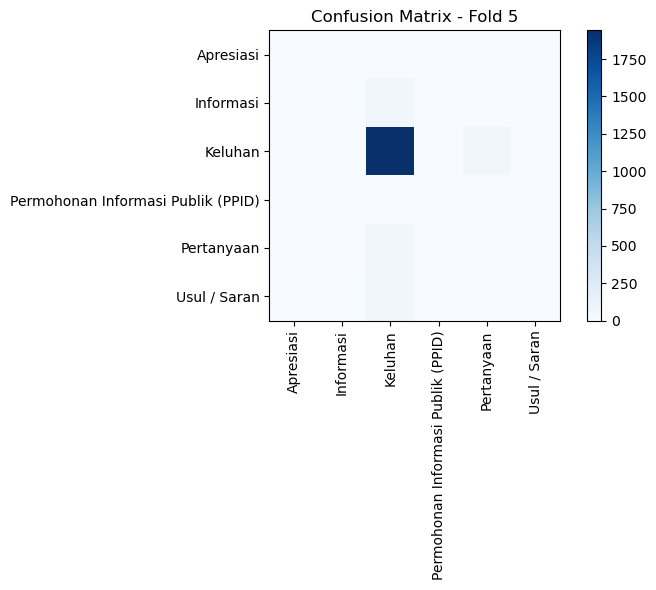

=========Fold :  5 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0    3    0    0    0]
 [   0    0   71    0    5    2]
 [   0    0 1943    0   68   14]
 [   0    0    6    0    1    0]
 [   0    0   61    0   15    0]
 [   0    0   71    0    4    8]]
Accuracy: 0.8653169014084507
Precision: [0.         0.         0.90162413 0.         0.16129032 0.33333333]
Recall: [0.         0.         0.95950617 0.         0.19736842 0.09638554]
F1-Score: [0.         0.         0.92966507 0.         0.17751479 0.14953271]
Processing time 0.02873516082763672
=========Macro Average=========
Precision Macro Avg : 0.2327079643073955
Recall Macro Avg: 0.20887668934346873
F1-Score Macro Avg: 0.20945209582501947
=========Micro Average=========
Precision Micro Avg: 0.8653169014084507
Recall Micro Avg: 0.8653169014084507
F1-Score Micro Avg: 0.8653169014084507
=========Weighted Average=========
Precision Weighted Avg: 0.8211767580509879
Recall Weighted Avg: 0.8653169014084507
F1-Score Weight

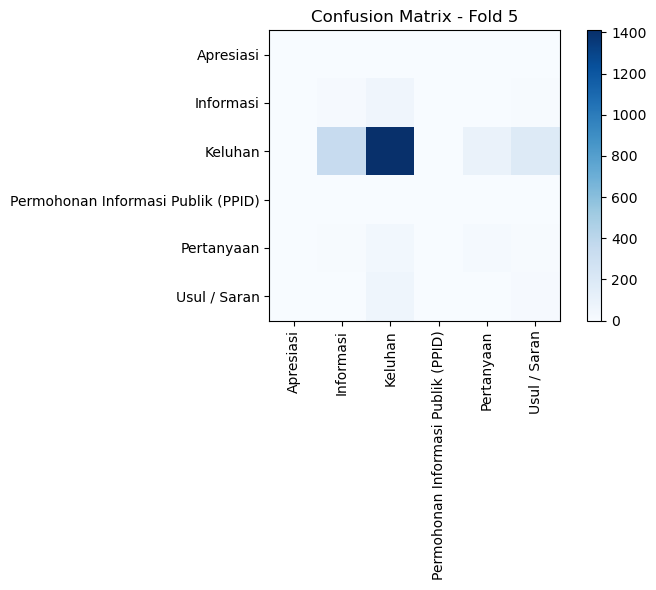

=========Fold :  5 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    2    0    0    1]
 [   1   13   56    0    0    8]
 [   1  345 1410    0   91  178]
 [   0    2    3    0    2    0]
 [   0    7   43    0   17    9]
 [   0    5   62    0    1   15]]
Accuracy: 0.6404049295774648
Precision: [0.         0.03494624 0.89467005 0.         0.15315315 0.07109005]
Recall: [0.         0.16666667 0.6962963  0.         0.22368421 0.18072289]
F1-Score: [0.         0.05777778 0.7831158  0.         0.18181818 0.10204082]
Processing time 6.142481803894043
=========Macro Average=========
Precision Macro Avg : 0.1923099146445132
Recall Macro Avg: 0.21122834417592395
F1-Score Macro Avg: 0.18745876284813887
=========Micro Average=========
Precision Micro Avg: 0.6404049295774648
Recall Micro Avg: 0.6404049295774648
F1-Score Micro Avg: 0.6404049295774648
=========Weighted Average=========
Precision Weighted Avg: 0.8063260443735827
Recall Weighted Avg: 0.6404049295774648
F1-Score Weighted 

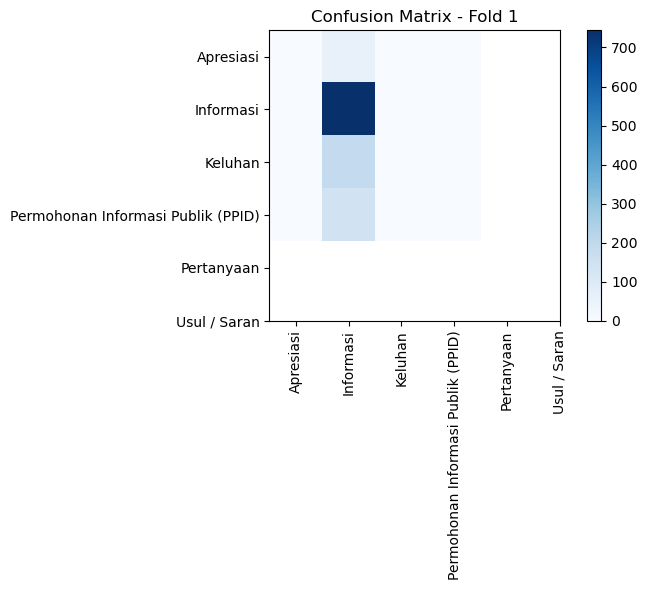

=========Fold :  1 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  58   0   0]
 [  0 744   0   0]
 [  0 189   0   0]
 [  0 145   0   0]]
Accuracy: 0.6549295774647887
Precision: [0.         0.65492958 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.79148936 0.         0.        ]
Processing time 0.021019935607910156
=========Macro Average=========
Precision Macro Avg : 0.1637323943661972
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.19787234042553192
=========Micro Average=========
Precision Micro Avg: 0.6549295774647887
Recall Micro Avg: 0.6549295774647887
F1-Score Micro Avg: 0.6549295774647887
=========Weighted Average=========
Precision Weighted Avg: 0.4289327514382067
Recall Weighted Avg: 0.6549295774647887
F1-Score Weighted Avg: 0.5183697932274498




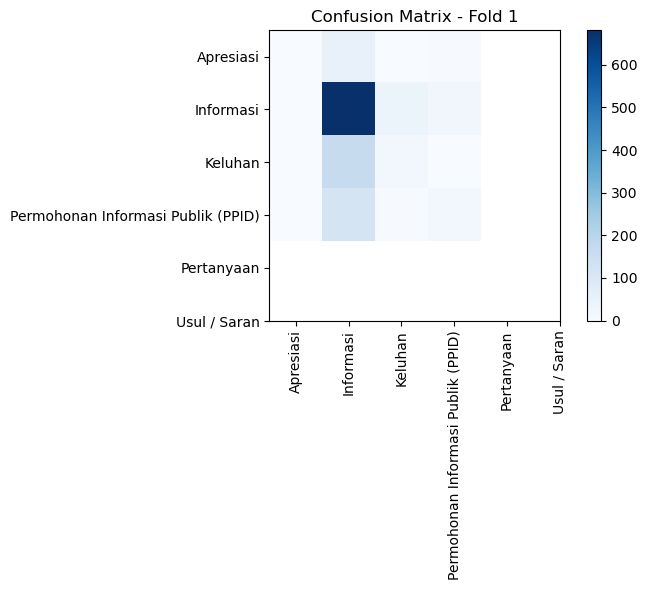

=========Fold :  1 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  53   1   4]
 [  0 681  40  23]
 [  0 166  21   2]
 [  0 120   5  20]]
Accuracy: 0.6355633802816901
Precision: [0.         0.66764706 0.31343284 0.40816327]
Recall: [0.         0.91532258 0.11111111 0.13793103]
F1-Score: [0.         0.77210884 0.1640625  0.20618557]
Processing time 0.02635502815246582
=========Macro Average=========
Precision Macro Avg : 0.34731078998763687
Recall Macro Avg: 0.2910911815597578
F1-Score Macro Avg: 0.28558922763693106
=========Micro Average=========
Precision Micro Avg: 0.6355633802816901
Recall Micro Avg: 0.6355633802816901
F1-Score Micro Avg: 0.6355633802816901
=========Weighted Average=========
Precision Weighted Avg: 0.5415069464826081
Recall Weighted Avg: 0.6355633802816901
F1-Score Weighted Avg: 0.5592902282643764




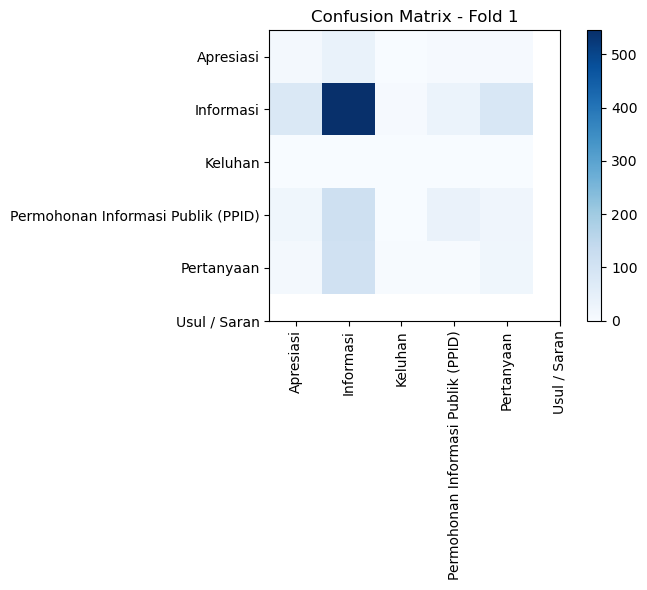

=========Fold :  1 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 11  37   0   5   5]
 [ 77 545   5  33  84]
 [  0   0   0   0   0]
 [ 20 112   0  35  22]
 [  9 107   4   4  21]]
Accuracy: 0.5387323943661971
Precision: [0.09401709 0.6803995  0.         0.45454545 0.15909091]
Recall: [0.18965517 0.73252688 0.         0.18518519 0.14482759]
F1-Score: [0.12571429 0.70550162 0.         0.26315789 0.15162455]
Processing time 7.950084924697876
=========Macro Average=========
Precision Macro Avg : 0.2776105916555355
Recall Macro Avg: 0.250438965105261
F1-Score Macro Avg: 0.24919966946211342
=========Micro Average=========
Precision Micro Avg: 0.5387323943661971
Recall Micro Avg: 0.5387323943661971
F1-Score Micro Avg: 0.5387323943661971
=========Weighted Average=========
Precision Weighted Avg: 0.5463446238069398
Recall Weighted Avg: 0.5387323943661971
F1-Score Weighted Avg: 0.5316083046892375




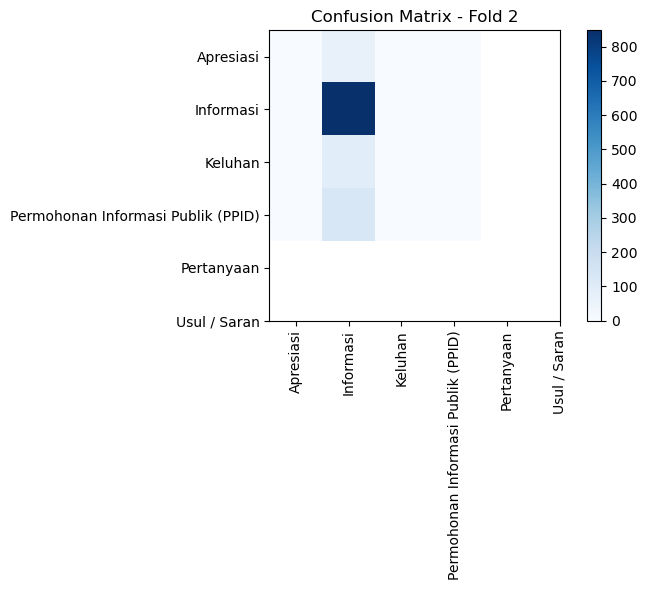

=========Fold :  2 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  65   0   0]
 [  0 848   0   0]
 [  0  91   0   0]
 [  0 132   0   0]]
Accuracy: 0.7464788732394366
Precision: [0.         0.74647887 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.85483871 0.         0.        ]
Processing time 0.020750045776367188
=========Macro Average=========
Precision Macro Avg : 0.18661971830985916
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21370967741935484
=========Micro Average=========
Precision Micro Avg: 0.7464788732394366
Recall Micro Avg: 0.7464788732394366
F1-Score Micro Avg: 0.7464788732394367
=========Weighted Average=========
Precision Weighted Avg: 0.557230708192819
Recall Weighted Avg: 0.7464788732394366
F1-Score Weighted Avg: 0.6381190368014539




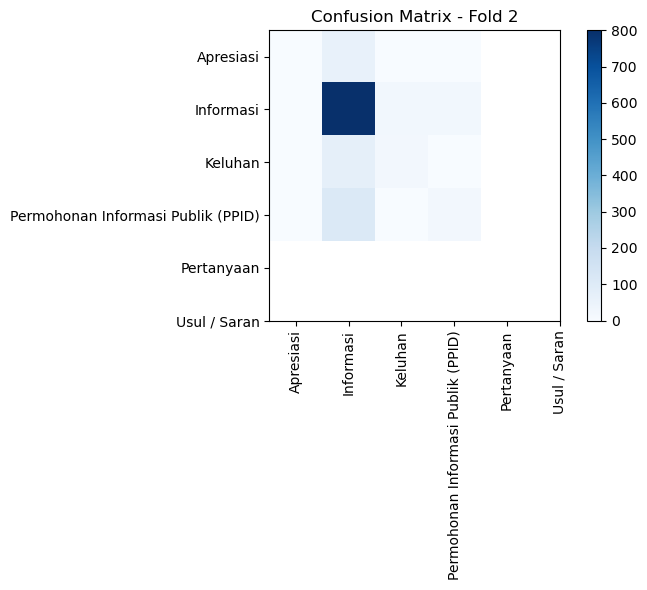

=========Fold :  2 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  60   3   2]
 [  0 800  23  25]
 [  0  71  19   1]
 [  0 111   2  19]]
Accuracy: 0.7376760563380281
Precision: [0.         0.76775432 0.40425532 0.40425532]
Recall: [0.         0.94339623 0.20879121 0.14393939]
F1-Score: [0.         0.84656085 0.27536232 0.2122905 ]
Processing time 0.0265963077545166
=========Macro Average=========
Precision Macro Avg : 0.39406623922897865
Recall Macro Avg: 0.3240317072864243
F1-Score Macro Avg: 0.3335534170486806
=========Micro Average=========
Precision Micro Avg: 0.7376760563380281
Recall Micro Avg: 0.7376760563380281
F1-Score Micro Avg: 0.7376760563380281
=========Weighted Average=========
Precision Weighted Avg: 0.6524688365830217
Recall Weighted Avg: 0.7376760563380281
F1-Score Weighted Avg: 0.678665418368667




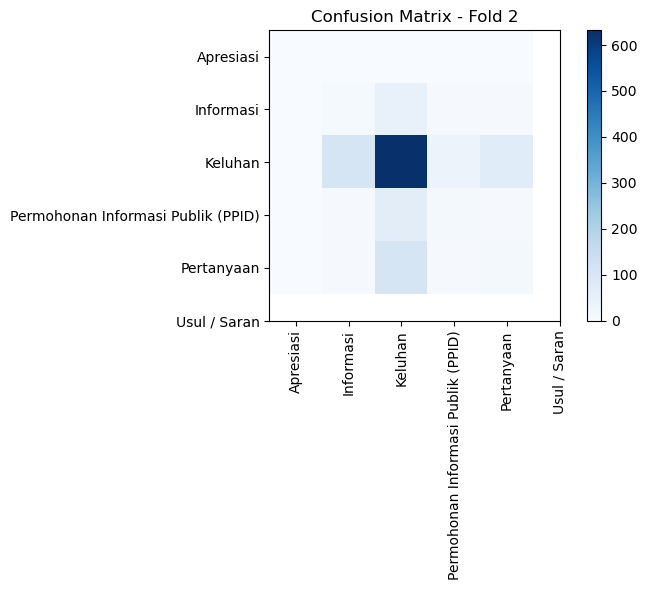

=========Fold :  2 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   0   0   0]
 [  0   8  47   5   5]
 [  1 105 632  37  73]
 [  0   7  65  14   5]
 [  0   6 105   7  14]]
Accuracy: 0.5880281690140845
Precision: [0.         0.06349206 0.74440518 0.22222222 0.1443299 ]
Recall: [0.         0.12307692 0.74528302 0.15384615 0.10606061]
F1-Score: [0.         0.08376963 0.74484384 0.18181818 0.12227074]
Processing time 6.7068772315979
=========Macro Average=========
Precision Macro Avg : 0.23488987303784575
Recall Macro Avg: 0.2256533403703215
F1-Score Macro Avg: 0.2265404799516725
=========Micro Average=========
Precision Micro Avg: 0.5880281690140845
Recall Micro Avg: 0.5880281690140845
F1-Score Micro Avg: 0.5880281690140845
=========Weighted Average=========
Precision Weighted Avg: 0.5938876298929499
Recall Weighted Avg: 0.5880281690140845
F1-Score Weighted Avg: 0.5895755253465618




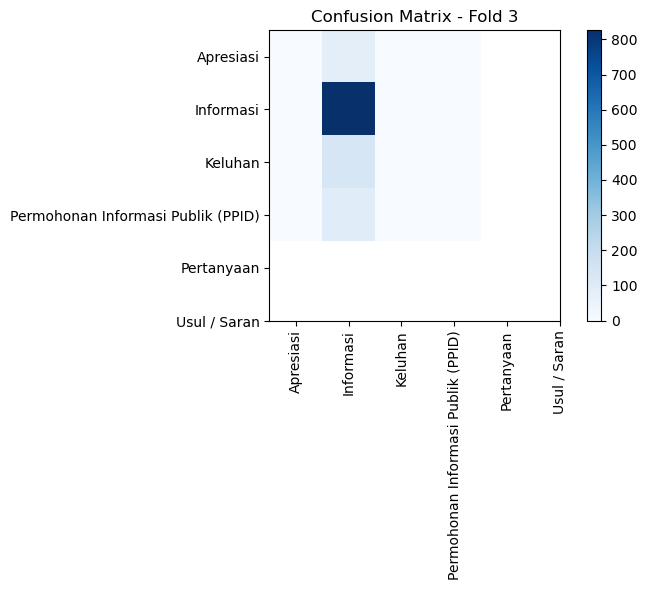

=========Fold :  3 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  81   0   0]
 [  0 826   0   0]
 [  0 134   0   0]
 [  0  95   0   0]]
Accuracy: 0.727112676056338
Precision: [0.         0.72711268 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.84199796 0.         0.        ]
Processing time 0.020594120025634766
=========Macro Average=========
Precision Macro Avg : 0.1817781690140845
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21049949031600407
=========Micro Average=========
Precision Micro Avg: 0.727112676056338
Recall Micro Avg: 0.727112676056338
F1-Score Micro Avg: 0.727112676056338
=========Weighted Average=========
Precision Weighted Avg: 0.5286928436818091
Recall Weighted Avg: 0.727112676056338
F1-Score Weighted Avg: 0.6122273908486596




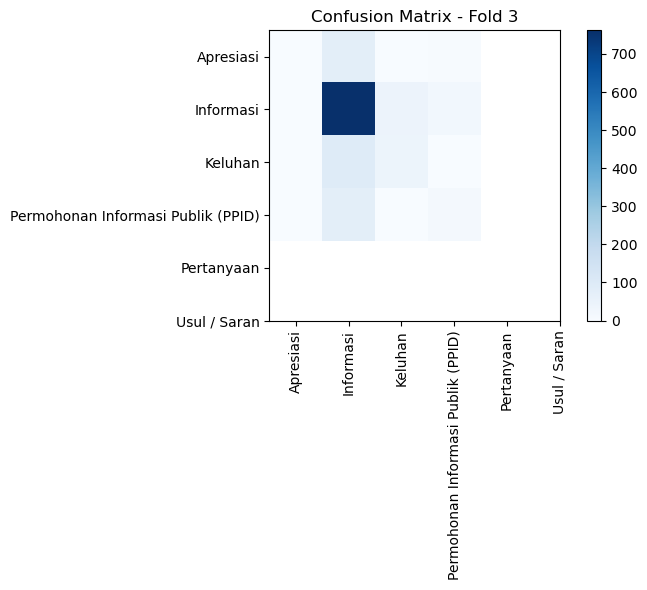

=========Fold :  3 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  76   2   3]
 [  0 762  42  22]
 [  0  94  39   1]
 [  0  76   2  17]]
Accuracy: 0.7200704225352113
Precision: [0.         0.75595238 0.45882353 0.39534884]
Recall: [0.         0.92251816 0.29104478 0.17894737]
F1-Score: [0.         0.83097056 0.35616438 0.24637681]
Processing time 0.025239944458007812
=========Macro Average=========
Precision Macro Avg : 0.402531186893362
Recall Macro Avg: 0.34812757608668776
F1-Score Macro Avg: 0.35837793782931066
=========Micro Average=========
Precision Micro Avg: 0.7200704225352113
Recall Micro Avg: 0.7200704225352113
F1-Score Micro Avg: 0.7200704225352113
=========Weighted Average=========
Precision Weighted Avg: 0.6368460907946539
Recall Weighted Avg: 0.7200704225352113
F1-Score Weighted Avg: 0.6668252675070621




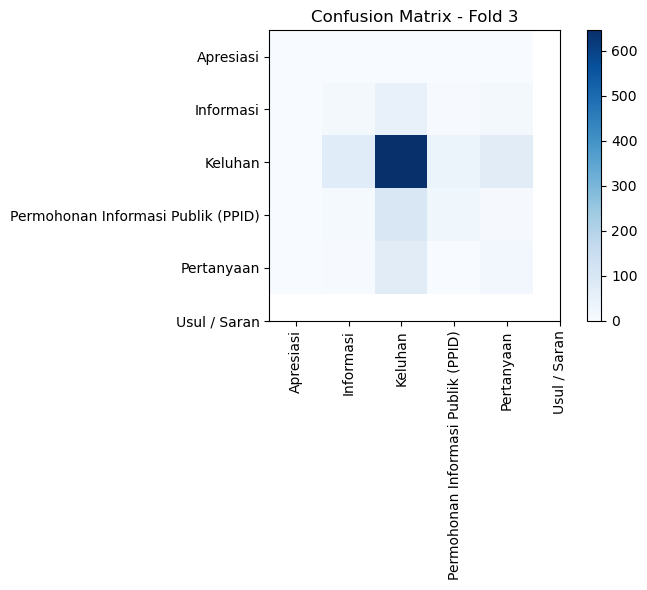

=========Fold :  3 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   0   0   0]
 [  0  15  50   3  13]
 [  1  74 645  34  72]
 [  0   8  97  23   6]
 [  0   3  72   2  18]]
Accuracy: 0.6170774647887324
Precision: [0.         0.15       0.74652778 0.37096774 0.16513761]
Recall: [0.         0.18518519 0.78087167 0.17164179 0.18947368]
F1-Score: [0.         0.16574586 0.76331361 0.23469388 0.17647059]
Processing time 7.099467992782593
=========Macro Average=========
Precision Macro Avg : 0.2865266268784321
Recall Macro Avg: 0.26543446622853334
F1-Score Macro Avg: 0.2680447863214722
=========Micro Average=========
Precision Micro Avg: 0.6170774647887324
Recall Micro Avg: 0.6170774647887324
F1-Score Micro Avg: 0.6170774647887324
=========Weighted Average=========
Precision Weighted Avg: 0.6110736754034285
Recall Weighted Avg: 0.6170774647887324
F1-Score Weighted Avg: 0.6092747722349903




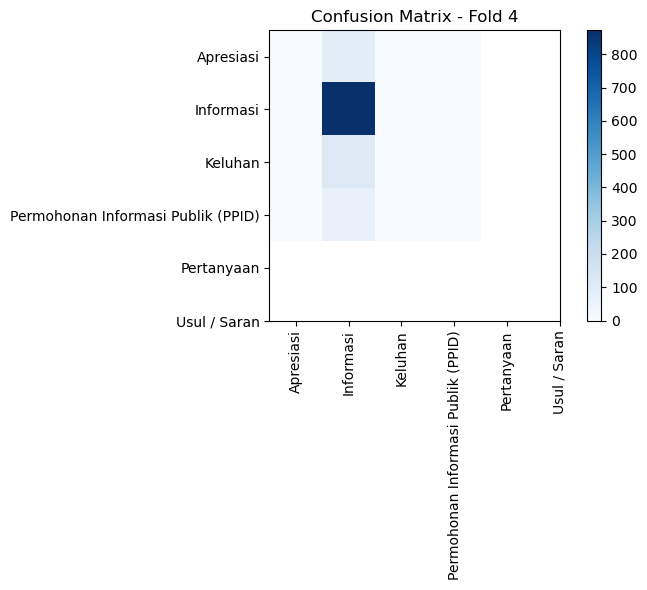

=========Fold :  4 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  86   0   0]
 [  0 872   0   0]
 [  0 110   0   0]
 [  0  68   0   0]]
Accuracy: 0.7676056338028169
Precision: [0.         0.76760563 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.        0.8685259 0.        0.       ]
Processing time 0.021322965621948242
=========Macro Average=========
Precision Macro Avg : 0.19190140845070422
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21713147410358563
=========Micro Average=========
Precision Micro Avg: 0.7676056338028169
Recall Micro Avg: 0.7676056338028169
F1-Score Micro Avg: 0.7676056338028169
=========Weighted Average=========
Precision Weighted Avg: 0.5892184090458242
Recall Weighted Avg: 0.7676056338028169
F1-Score Weighted Avg: 0.6666853711912911




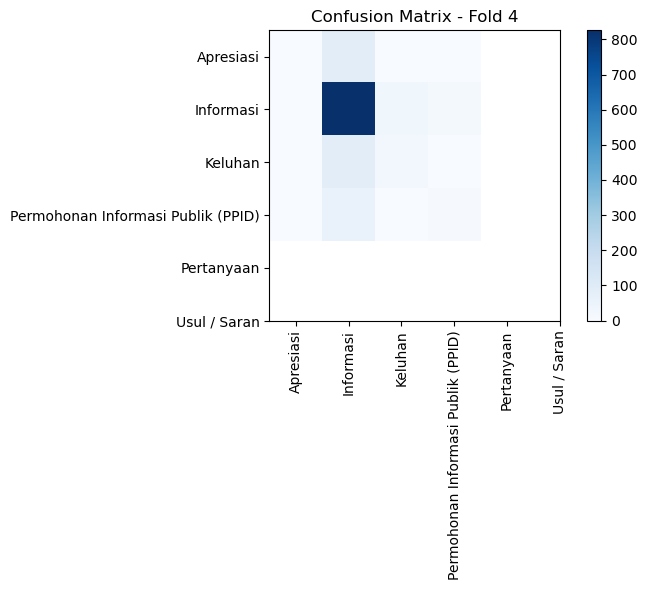

=========Fold :  4 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  85   1   0]
 [  1 826  30  15]
 [  0  84  23   3]
 [  0  58   3   7]]
Accuracy: 0.7535211267605634
Precision: [0.         0.78442545 0.40350877 0.28      ]
Recall: [0.         0.94724771 0.20909091 0.10294118]
F1-Score: [0.         0.85818182 0.2754491  0.15053763]
Processing time 0.060364723205566406
=========Macro Average=========
Precision Macro Avg : 0.3669835557554856
Recall Macro Avg: 0.3148199479958789
F1-Score Macro Avg: 0.32104213859670694
=========Micro Average=========
Precision Micro Avg: 0.7535211267605634
Recall Micro Avg: 0.7535211267605634
F1-Score Micro Avg: 0.7535211267605635
=========Weighted Average=========
Precision Weighted Avg: 0.657962111148422
Recall Weighted Avg: 0.7535211267605634
F1-Score Weighted Avg: 0.694428262140788




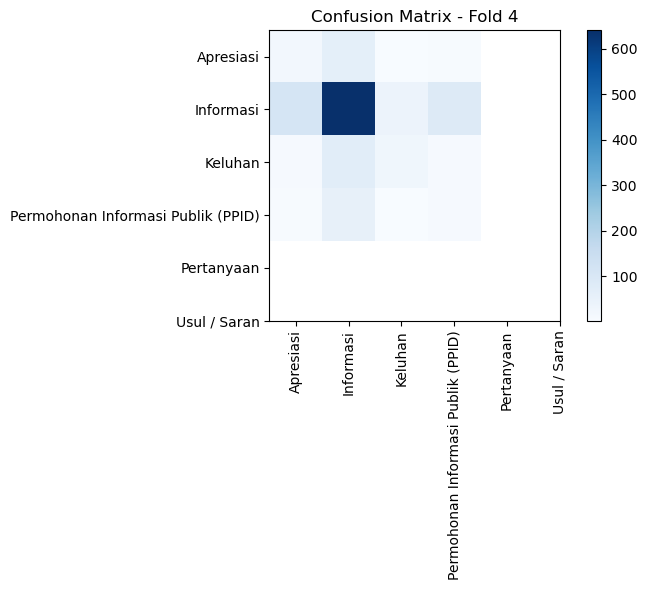

=========Fold :  4 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 18  60   2   6]
 [111 641  38  82]
 [  7  71  25   7]
 [  6  53   2   7]]
Accuracy: 0.608274647887324
Precision: [0.12676056 0.7769697  0.37313433 0.06862745]
Recall: [0.20930233 0.73509174 0.22727273 0.10294118]
F1-Score: [0.15789474 0.7554508  0.28248588 0.08235294]
Processing time 8.220627069473267
=========Macro Average=========
Precision Macro Avg : 0.3363730099221449
Recall Macro Avg: 0.31865199311099424
F1-Score Macro Avg: 0.31954608731157474
=========Micro Average=========
Precision Micro Avg: 0.608274647887324
Recall Micro Avg: 0.608274647887324
F1-Score Micro Avg: 0.608274647887324
=========Weighted Average=========
Precision Weighted Avg: 0.6462415730584063
Recall Weighted Avg: 0.608274647887324
F1-Score Weighted Avg: 0.62412454875956




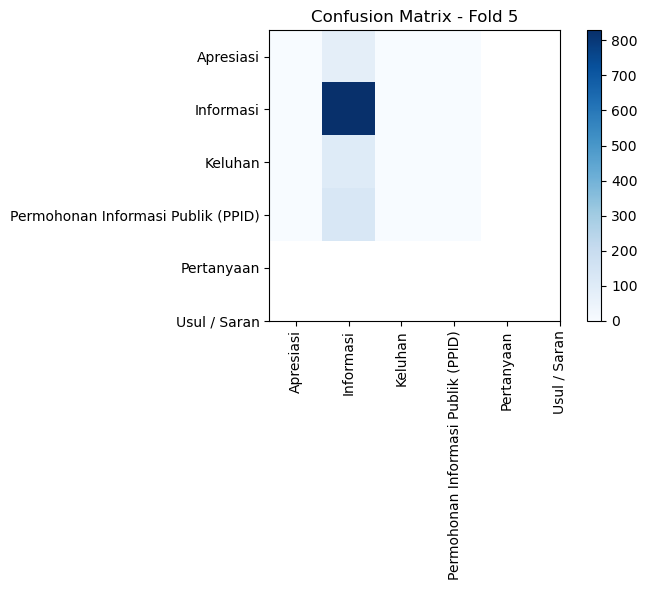

=========Fold :  5 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  78   0   0]
 [  0 829   0   0]
 [  0 102   0   0]
 [  0 127   0   0]]
Accuracy: 0.7297535211267606
Precision: [0.         0.72975352 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.        0.8437659 0.        0.       ]
Processing time 0.0210878849029541
=========Macro Average=========
Precision Macro Avg : 0.18243838028169015
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21094147582697204
=========Micro Average=========
Precision Micro Avg: 0.7297535211267606
Recall Micro Avg: 0.7297535211267606
F1-Score Micro Avg: 0.7297535211267605
=========Weighted Average=========
Precision Weighted Avg: 0.5325402015969054
Recall Weighted Avg: 0.7297535211267606
F1-Score Weighted Avg: 0.6157411389456332




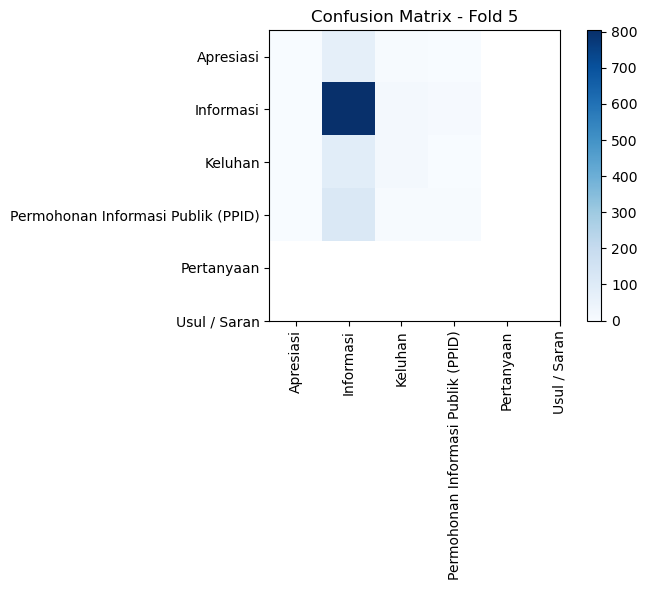

=========Fold :  5 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  71   4   3]
 [  0 804  17   8]
 [  0  86  15   1]
 [  0 118   5   4]]
Accuracy: 0.7244718309859155
Precision: [0.         0.74513438 0.36585366 0.25      ]
Recall: [0.         0.96984318 0.14705882 0.03149606]
F1-Score: [0.         0.8427673  0.20979021 0.05594406]
Processing time 0.025727033615112305
=========Macro Average=========
Precision Macro Avg : 0.34024701055629647
Recall Macro Avg: 0.28709951777031206
F1-Score Macro Avg: 0.27712539033293754
=========Micro Average=========
Precision Micro Avg: 0.7244718309859155
Recall Micro Avg: 0.7244718309859155
F1-Score Micro Avg: 0.7244718309859155
=========Weighted Average=========
Precision Weighted Avg: 0.6045629201131879
Recall Weighted Avg: 0.7244718309859155
F1-Score Weighted Avg: 0.6401035075297632




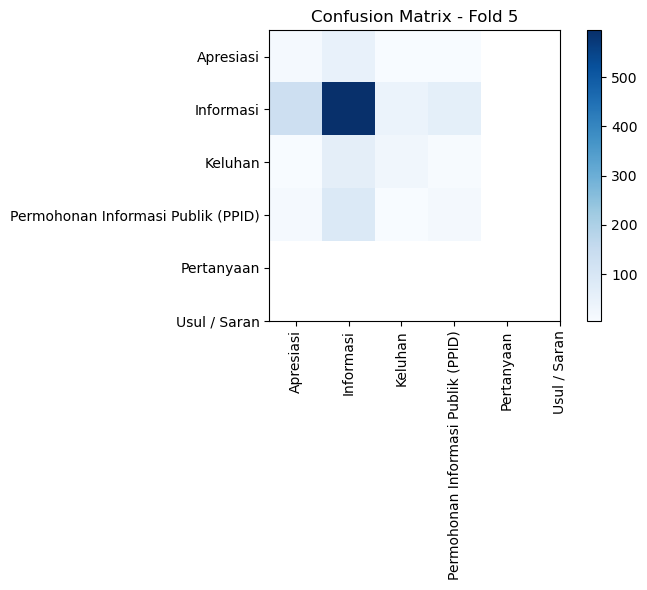

=========Fold :  5 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 13  51   8   6]
 [132 595  42  60]
 [  6  62  25   9]
 [ 14  87   8  18]]
Accuracy: 0.5730633802816901
Precision: [0.07878788 0.74842767 0.30120482 0.19354839]
Recall: [0.16666667 0.71773221 0.24509804 0.14173228]
F1-Score: [0.10699588 0.73275862 0.27027027 0.16363636]
Processing time 6.547155857086182
=========Macro Average=========
Precision Macro Avg : 0.33049218952943404
Recall Macro Avg: 0.3178072992064525
F1-Score Macro Avg: 0.3184152848424879
=========Micro Average=========
Precision Micro Avg: 0.5730633802816901
Recall Micro Avg: 0.5730633802816901
F1-Score Micro Avg: 0.5730633802816901
=========Weighted Average=========
Precision Weighted Avg: 0.6002601515435855
Recall Weighted Avg: 0.5730633802816901
F1-Score Weighted Avg: 0.5846408110153658




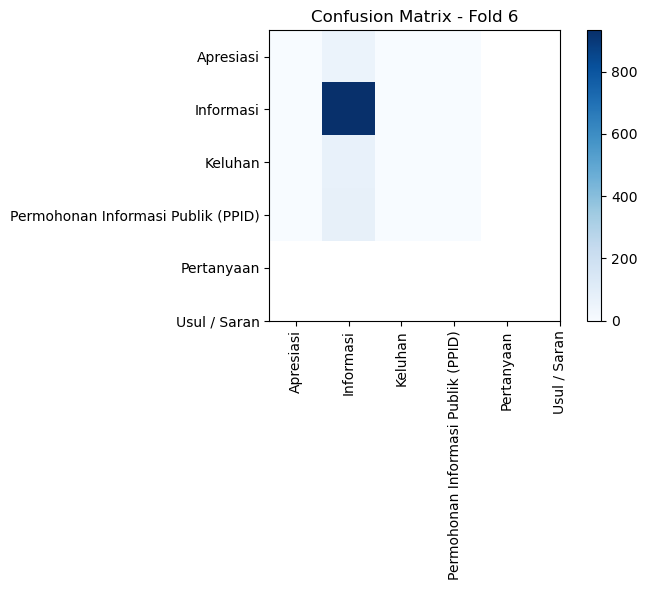

=========Fold :  6 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0  58   0   0]
 [  0 933   0   0]
 [  0  72   0   0]
 [  0  73   0   0]]
Accuracy: 0.8213028169014085
Precision: [0.         0.82130282 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.90188497 0.         0.        ]
Processing time 0.021350860595703125
=========Macro Average=========
Precision Macro Avg : 0.20532570422535212
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.22547124214596423
=========Micro Average=========
Precision Micro Avg: 0.8213028169014085
Recall Micro Avg: 0.8213028169014085
F1-Score Micro Avg: 0.8213028169014085
=========Weighted Average=========
Precision Weighted Avg: 0.6745383170501885
Recall Weighted Avg: 0.8213028169014085
F1-Score Weighted Avg: 0.74072066521896




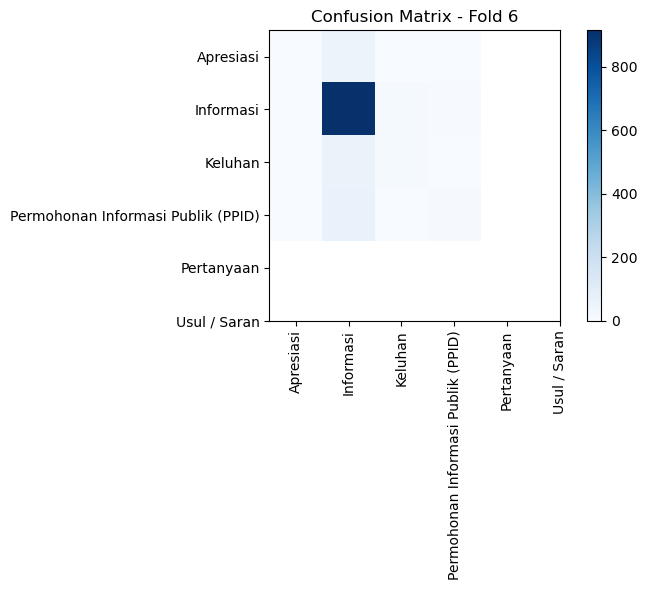

=========Fold :  6 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  57   1   0]
 [  0 915  14   4]
 [  0  58  14   0]
 [  0  64   1   8]]
Accuracy: 0.8248239436619719
Precision: [0.         0.83638026 0.46666667 0.66666667]
Recall: [0.         0.9807074  0.19444444 0.10958904]
F1-Score: [0.         0.90281204 0.2745098  0.18823529]
Processing time 0.026209115982055664
=========Macro Average=========
Precision Macro Avg : 0.49242839731870813
Recall Macro Avg: 0.32118522025968177
F1-Score Macro Avg: 0.34138928388326223
=========Micro Average=========
Precision Micro Avg: 0.8248239436619719
Recall Micro Avg: 0.8248239436619719
F1-Score Micro Avg: 0.8248239436619719
=========Weighted Average=========
Precision Weighted Avg: 0.759339300581061
Recall Weighted Avg: 0.8248239436619719
F1-Score Weighted Avg: 0.7709766842734926




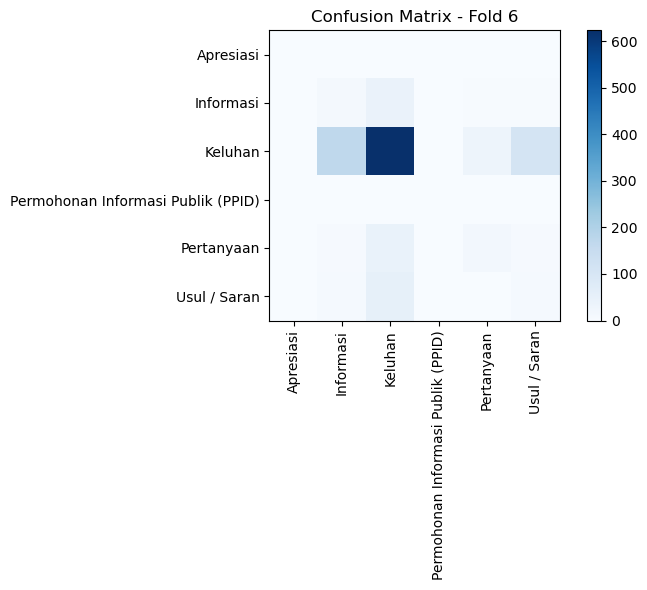

=========Fold :  6 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   0   0   0   0]
 [  0  12  39   0   3   4]
 [  1 169 623   1  30 109]
 [  0   0   0   0   0   0]
 [  0   7  42   0  17   6]
 [  0   9  53   0   2   9]]
Accuracy: 0.5818661971830986
Precision: [0.         0.06091371 0.82298547 0.         0.32692308 0.0703125 ]
Recall: [0.         0.20689655 0.66773848 0.         0.23611111 0.12328767]
F1-Score: [0.         0.09411765 0.73727811 0.         0.27419355 0.08955224]
Processing time 6.431709051132202
=========Macro Average=========
Precision Macro Avg : 0.21352245857720667
Recall Macro Avg: 0.20567230201599881
F1-Score Macro Avg: 0.19919025679346106
=========Micro Average=========
Precision Micro Avg: 0.5818661971830986
Recall Micro Avg: 0.5818661971830986
F1-Score Micro Avg: 0.5818661971830986
=========Weighted Average=========
Precision Weighted Avg: 0.7042691122347244
Recall Weighted Avg: 0.5818661971830986
F1-Score Weighted Avg: 0.6334670297701582




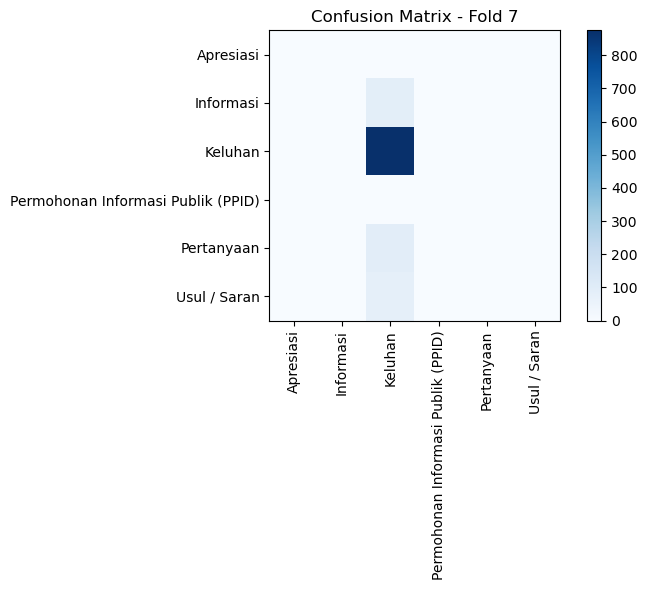

=========Fold :  7 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0   0  88   0   0   0]
 [  0   0 875   0   0   0]
 [  0   0   2   0   0   0]
 [  0   0  92   0   0   0]
 [  0   0  78   0   0   0]]
Accuracy: 0.7702464788732394
Precision: [0.         0.         0.77024648 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.87021382 0.         0.         0.        ]
Processing time 0.022893905639648438
=========Macro Average=========
Precision Macro Avg : 0.1283744131455399
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.14503563732802915
=========Micro Average=========
Precision Micro Avg: 0.7702464788732394
Recall Micro Avg: 0.7702464788732394
F1-Score Micro Avg: 0.7702464788732393
=========Weighted Average=========
Precision Weighted Avg: 0.5932796382166237
Recall Weighted Avg: 0.7702464788732394
F1-Score Weighted Avg: 0.6702791337783037




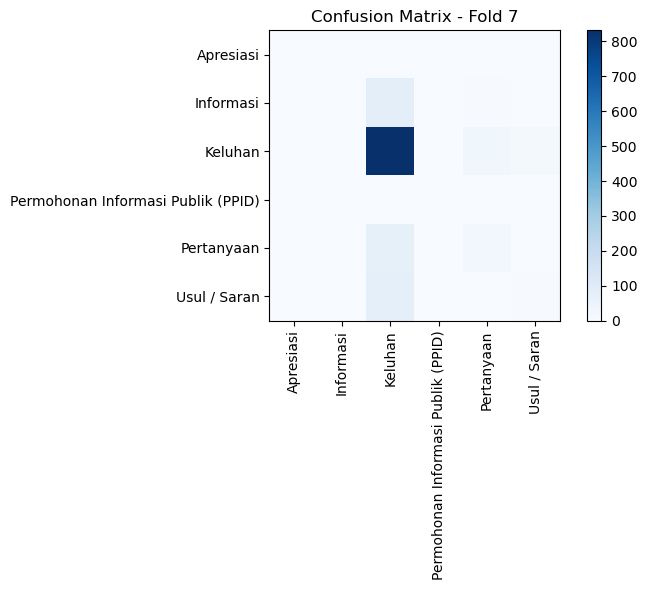

=========Fold :  7 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0   0  83   0   4   1]
 [  0   0 832   0  30  13]
 [  0   0   0   0   2   0]
 [  0   0  69   0  21   2]
 [  0   0  72   0   1   5]]
Accuracy: 0.7552816901408451
Precision: [0.         0.         0.7871334  0.         0.36206897 0.23809524]
Recall: [0.         0.         0.95085714 0.         0.22826087 0.06410256]
F1-Score: [0.         0.         0.86128364 0.         0.28       0.1010101 ]
Processing time 0.02527618408203125
=========Macro Average=========
Precision Macro Avg : 0.23121626666956652
Recall Macro Avg: 0.2072034294208207
F1-Score Macro Avg: 0.20704895748374008
=========Micro Average=========
Precision Micro Avg: 0.7552816901408451
Recall Micro Avg: 0.7552816901408451
F1-Score Micro Avg: 0.7552816901408451
=========Weighted Average=========
Precision Weighted Avg: 0.6519573021596122
Recall Weighted Avg: 0.7552816901408451
F1-Score Weighted Avg: 0.6930123030674163




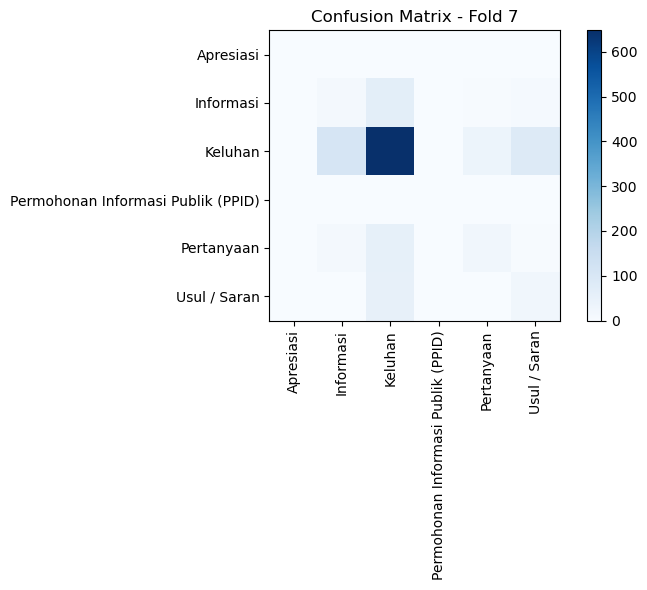

=========Fold :  7 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0  13  64   0   3   8]
 [  0 107 648   0  34  86]
 [  0   0   2   0   0   0]
 [  0  12  55   0  21   4]
 [  0   1  53   0   2  22]]
Accuracy: 0.6197183098591549
Precision: [0.         0.09774436 0.7873633  0.         0.35       0.18333333]
Recall: [0.         0.14772727 0.74057143 0.         0.22826087 0.28205128]
F1-Score: [0.         0.11764706 0.76325088 0.         0.27631579 0.22222222]
Processing time 6.425968885421753
=========Macro Average=========
Precision Macro Avg : 0.2364068332028938
Recall Macro Avg: 0.23310180881920015
F1-Score Macro Avg: 0.22990599231861034
=========Micro Average=========
Precision Micro Avg: 0.6197183098591549
Recall Micro Avg: 0.6197183098591549
F1-Score Micro Avg: 0.6197183098591549
=========Weighted Average=========
Precision Weighted Avg: 0.6549686581148334
Recall Weighted Avg: 0.6197183098591549
F1-Score Weighted Avg: 0.634640713124631




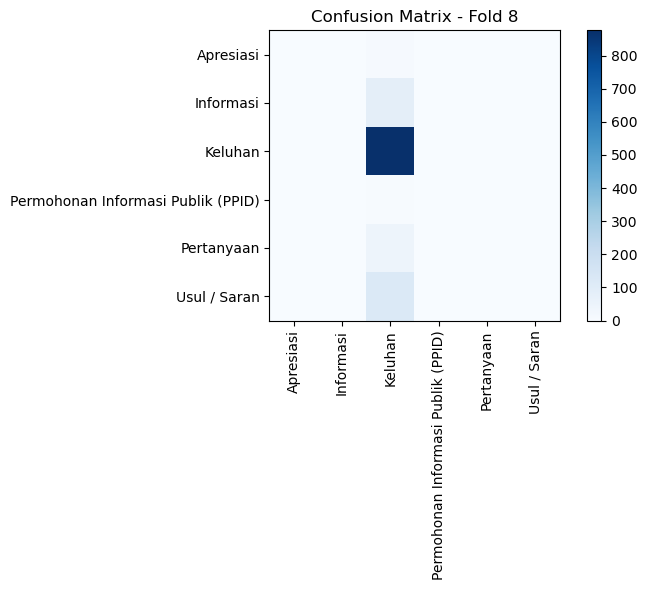

=========Fold :  8 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0   0   9   0   0   0]
 [  0   0  84   0   0   0]
 [  0   0 876   0   0   0]
 [  0   0   4   0   0   0]
 [  0   0  43   0   0   0]
 [  0   0 120   0   0   0]]
Accuracy: 0.7711267605633803
Precision: [0.         0.         0.77112676 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.87077535 0.         0.         0.        ]
Processing time 0.021190166473388672
=========Macro Average=========
Precision Macro Avg : 0.12852112676056338
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.14512922465208747
=========Micro Average=========
Precision Micro Avg: 0.7711267605633803
Recall Micro Avg: 0.7711267605633803
F1-Score Micro Avg: 0.7711267605633803
=========Weighted Average=========
Precision Weighted Avg: 0.5946364808569728
Recall Weighted Avg: 0.7711267605633803
F1-Score Weighted Avg: 0.6714781732142358




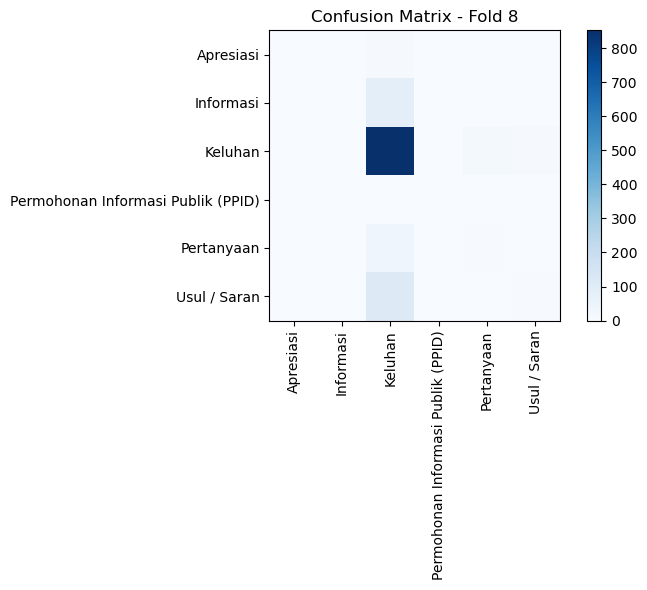

=========Fold :  8 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0   0   8   0   0   1]
 [  0   0  82   0   2   0]
 [  0   0 853   0  14   9]
 [  0   0   2   0   2   0]
 [  0   0  39   0   4   0]
 [  0   0 113   0   2   5]]
Accuracy: 0.7588028169014085
Precision: [0.         0.         0.77757521 0.         0.16666667 0.33333333]
Recall: [0.         0.         0.97374429 0.         0.09302326 0.04166667]
F1-Score: [0.         0.         0.86467309 0.         0.11940299 0.07407407]
Processing time 0.026861906051635742
=========Macro Average=========
Precision Macro Avg : 0.21292920085080522
Recall Macro Avg: 0.18473903578634387
F1-Score Macro Avg: 0.17635835763645777
=========Micro Average=========
Precision Micro Avg: 0.7588028169014085
Recall Micro Avg: 0.7588028169014085
F1-Score Micro Avg: 0.7588028169014086
=========Weighted Average=========
Precision Weighted Avg: 0.6411290020585377
Recall Weighted Avg: 0.7588028169014085
F1-Score Weighted Avg: 0.6791169376496988




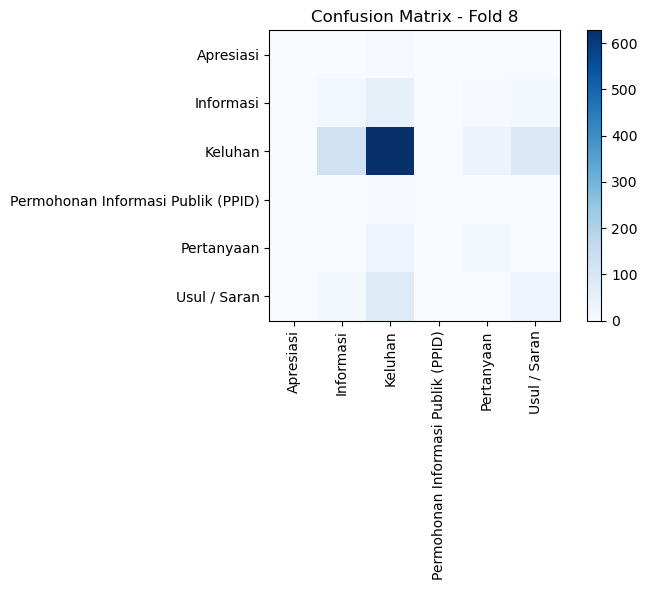

=========Fold :  8 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   2   6   0   0   1]
 [  0  17  52   0   5  10]
 [  0 127 628   1  32  88]
 [  0   1   3   0   0   0]
 [  0   2  30   0  10   1]
 [  0  11  77   0   1  31]]
Accuracy: 0.6038732394366197
Precision: [0.         0.10625    0.78894472 0.         0.20833333 0.23664122]
Recall: [0.         0.20238095 0.71689498 0.         0.23255814 0.25833333]
F1-Score: [0.         0.13934426 0.75119617 0.         0.21978022 0.24701195]
Processing time 6.934138059616089
=========Macro Average=========
Precision Macro Avg : 0.22336154638757824
Recall Macro Avg: 0.23502790040301988
F1-Score Macro Avg: 0.22622210108589005
=========Micro Average=========
Precision Micro Avg: 0.6038732394366197
Recall Micro Avg: 0.6038732394366197
F1-Score Micro Avg: 0.6038732394366197
=========Weighted Average=========
Precision Weighted Avg: 0.6491160719961849
Recall Weighted Avg: 0.6038732394366197
F1-Score Weighted Avg: 0.6239830533769689




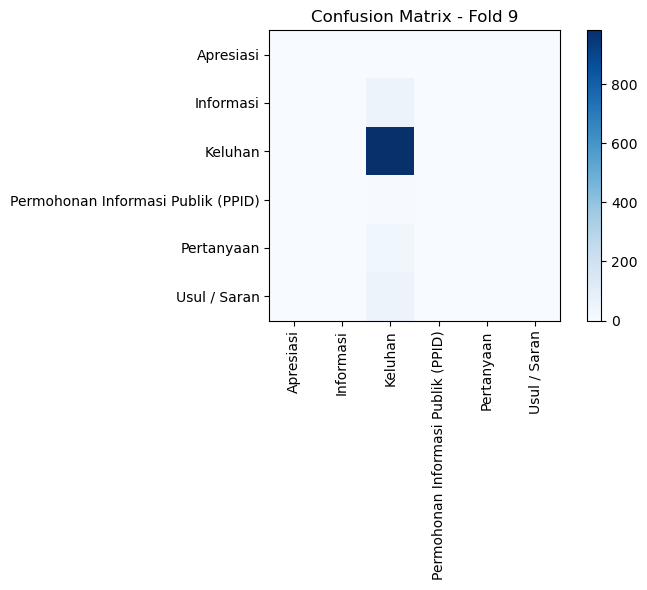

=========Fold :  9 =========
Classifier: MultinomialNB
Confusion Matrix:
[[  0   0   3   0   0   0]
 [  0   0  52   0   0   0]
 [  0   0 983   0   0   0]
 [  0   0   6   0   0   0]
 [  0   0  38   0   0   0]
 [  0   0  54   0   0   0]]
Accuracy: 0.8653169014084507
Precision: [0.        0.        0.8653169 0.        0.        0.       ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.92779613 0.         0.         0.        ]
Processing time 0.0227358341217041
=========Macro Average=========
Precision Macro Avg : 0.14421948356807512
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.15463268837501967
=========Micro Average=========
Precision Micro Avg: 0.8653169014084507
Recall Micro Avg: 0.8653169014084507
F1-Score Micro Avg: 0.8653169014084507
=========Weighted Average=========
Precision Weighted Avg: 0.7487733398631224
Recall Weighted Avg: 0.8653169014084507
F1-Score Weighted Avg: 0.8028376725667834




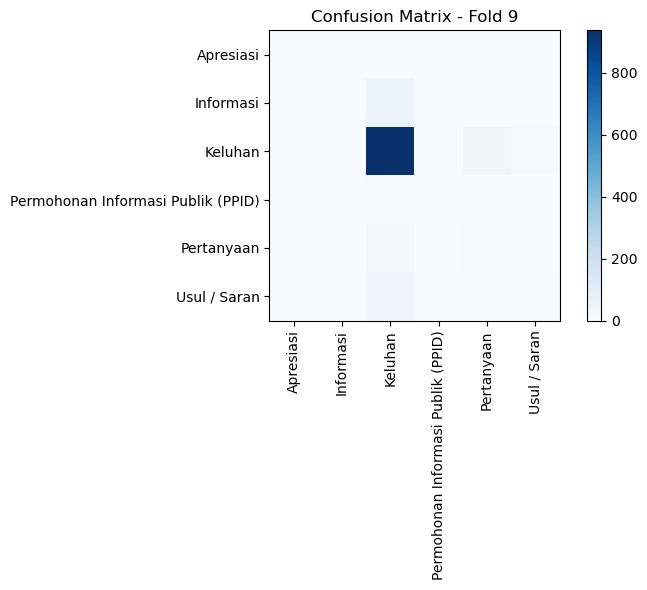

=========Fold :  9 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0   0   3   0   0   0]
 [  0   0  49   0   2   1]
 [  0   0 937   0  35  11]
 [  0   0   5   0   1   0]
 [  0   0  29   0   9   0]
 [  0   0  46   0   1   7]]
Accuracy: 0.8389084507042254
Precision: [0.         0.         0.87652011 0.         0.1875     0.36842105]
Recall: [0.         0.         0.95320448 0.         0.23684211 0.12962963]
F1-Score: [0.         0.         0.91325536 0.         0.20930233 0.19178082]
Processing time 0.02565598487854004
=========Macro Average=========
Precision Macro Avg : 0.23874019414767036
Recall Macro Avg: 0.2199460351643964
F1-Score Macro Avg: 0.21905641802049755
=========Micro Average=========
Precision Micro Avg: 0.8389084507042254
Recall Micro Avg: 0.8389084507042254
F1-Score Micro Avg: 0.8389084507042254
=========Weighted Average=========
Precision Weighted Avg: 0.7822526471727316
Recall Weighted Avg: 0.8389084507042254
F1-Score Weighted Avg: 0.8063729509232677




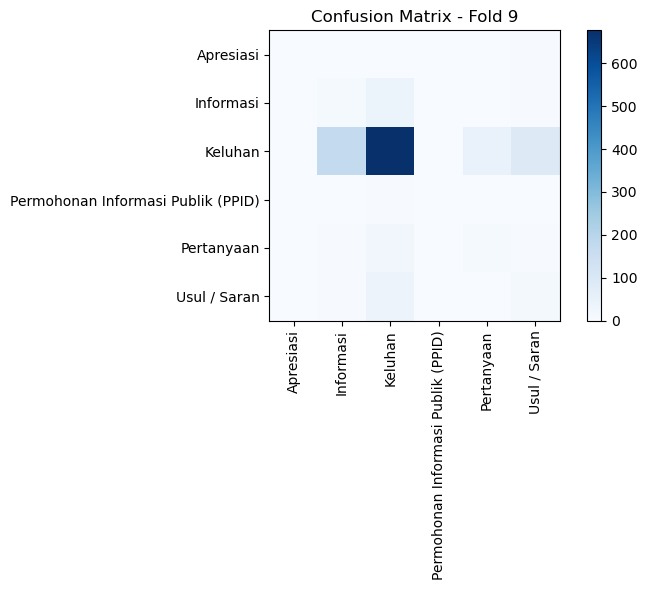

=========Fold :  9 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   0   0   0   3]
 [  1   9  37   0   0   5]
 [  1 173 677   0  45  87]
 [  0   1   3   0   2   0]
 [  0   5  22   0   8   3]
 [  0   5  38   0   0  11]]
Accuracy: 0.6205985915492958
Precision: [0.         0.04663212 0.87129987 0.         0.14545455 0.10091743]
Recall: [0.         0.17307692 0.68870804 0.         0.21052632 0.2037037 ]
F1-Score: [0.         0.07346939 0.76931818 0.         0.17204301 0.13496933]
Processing time 6.7102742195129395
=========Macro Average=========
Precision Macro Avg : 0.1940506620499015
Recall Macro Avg: 0.21266916319878074
F1-Score Macro Avg: 0.19163331757989108
=========Micro Average=========
Precision Micro Avg: 0.6205985915492958
Recall Micro Avg: 0.6205985915492958
F1-Score Micro Avg: 0.6205985915492958
=========Weighted Average=========
Precision Weighted Avg: 0.7657477622938126
Recall Weighted Avg: 0.6205985915492958
F1-Score Weighted Avg: 0.6812378158956183




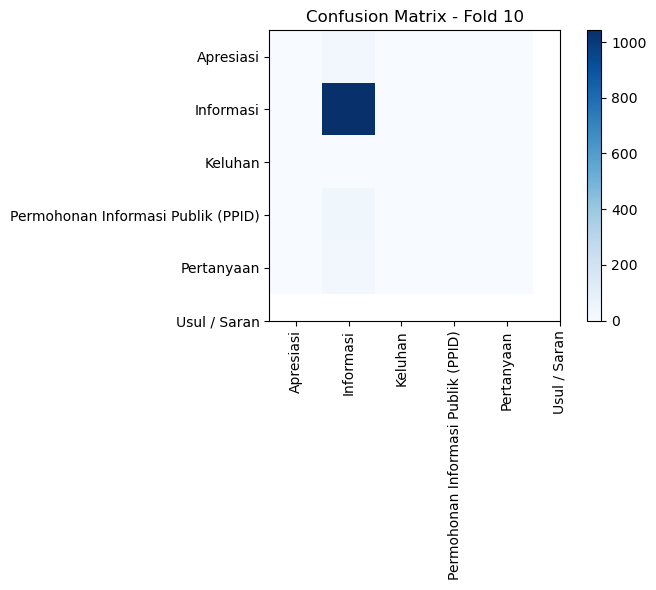

=========Fold :  10 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0   26    0    0    0]
 [   0 1042    0    0    0]
 [   0    1    0    0    0]
 [   0   38    0    0    0]
 [   0   29    0    0    0]]
Accuracy: 0.9172535211267606
Precision: [0.         0.91725352 0.         0.         0.        ]
Recall: [0. 1. 0. 0. 0.]
F1-Score: [0.         0.95684114 0.         0.         0.        ]
Processing time 0.02185988426208496
=========Macro Average=========
Precision Macro Avg : 0.18345070422535212
Recall Macro Avg: 0.2
F1-Score Macro Avg: 0.1913682277318641
=========Micro Average=========
Precision Micro Avg: 0.9172535211267606
Recall Micro Avg: 0.9172535211267606
F1-Score Micro Avg: 0.9172535211267606
=========Weighted Average=========
Precision Weighted Avg: 0.8413540220194407
Recall Weighted Avg: 0.9172535211267606
F1-Score Weighted Avg: 0.8776659035942007




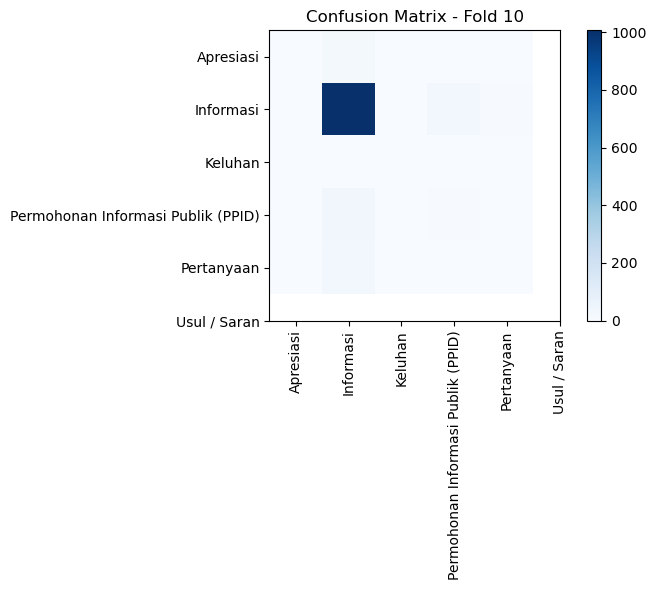

=========Fold :  10 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0   22    0    3    1]
 [   0 1007    0   31    4]
 [   0    1    0    0    0]
 [   0   34    0    4    0]
 [   0   26    0    2    1]]
Accuracy: 0.8908450704225352
Precision: [0.         0.92385321 0.         0.1        0.16666667]
Recall: [0.         0.96641075 0.         0.10526316 0.03448276]
F1-Score: [0.         0.94465291 0.         0.1025641  0.05714286]
Processing time 0.028049945831298828
=========Macro Average=========
Precision Macro Avg : 0.2381039755351682
Recall Macro Avg: 0.22123133301517744
F1-Score Macro Avg: 0.22087197355490037
=========Micro Average=========
Precision Micro Avg: 0.8908450704225352
Recall Micro Avg: 0.8908450704225352
F1-Score Micro Avg: 0.8908450704225352
=========Weighted Average=========
Precision Weighted Avg: 0.8550073760606453
Recall Weighted Avg: 0.8908450704225352
F1-Score Weighted Avg: 0.8713758001416881




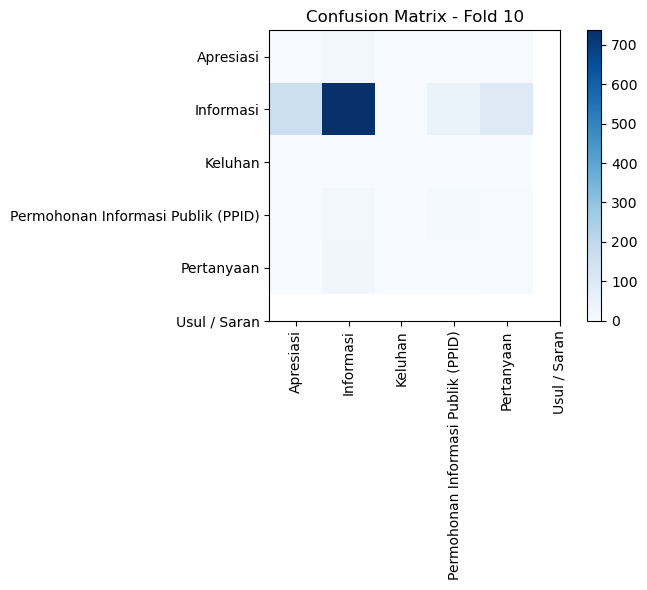

=========Fold :  10 =========
Classifier: GaussianNB
Confusion Matrix:
[[  4  18   0   0   4]
 [160 737   0  48  97]
 [  1   0   0   0   0]
 [  2  22   0   9   5]
 [  0  24   0   1   4]]
Accuracy: 0.6637323943661971
Precision: [0.0239521  0.92009988 0.         0.15517241 0.03636364]
Recall: [0.15384615 0.70729367 0.         0.23684211 0.13793103]
F1-Score: [0.04145078 0.79978296 0.         0.1875     0.05755396]
Processing time 6.530094146728516
=========Macro Average=========
Precision Macro Avg : 0.2271176042242356
Recall Macro Avg: 0.24718259192378836
F1-Score Macro Avg: 0.21725753931952935
=========Micro Average=========
Precision Micro Avg: 0.6637323943661971
Recall Micro Avg: 0.6637323943661971
F1-Score Micro Avg: 0.6637323943661971
=========Weighted Average=========
Precision Weighted Avg: 0.8506319732238649
Recall Weighted Avg: 0.6637323943661971
F1-Score Weighted Avg: 0.7422936900916027


======5-FOLD CROSS VALIDATION FOR 100% DATA======
K-Fold = 5
Data Deskripsi Array Len = 1

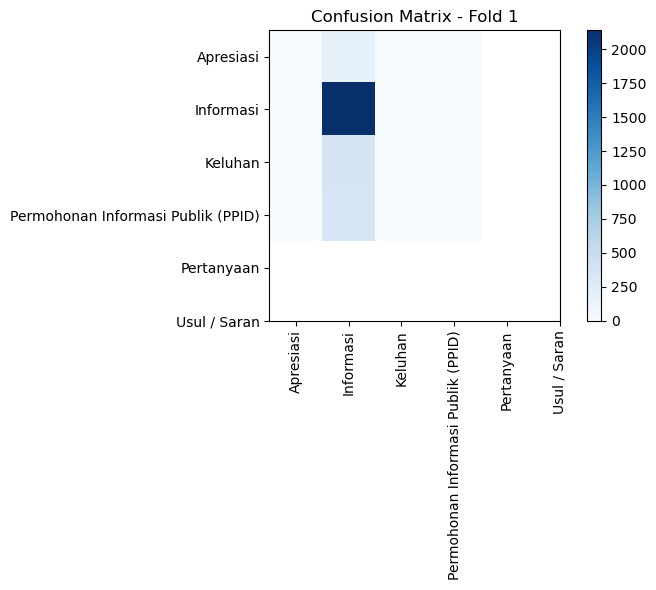

=========Fold :  1 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  176    0    0]
 [   0 2140    0    0]
 [   0  370    0    0]
 [   0  344    0    0]]
Accuracy: 0.7062706270627063
Precision: [0.         0.70627063 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.       0.827853 0.       0.      ]
Processing time 0.025484085083007812
=========Macro Average=========
Precision Macro Avg : 0.17656765676567657
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.20696324951644102
=========Micro Average=========
Precision Micro Avg: 0.7062706270627063
Recall Micro Avg: 0.7062706270627063
F1-Score Micro Avg: 0.7062706270627063
=========Weighted Average=========
Precision Weighted Avg: 0.4988181986515483
Recall Weighted Avg: 0.7062706270627063
F1-Score Weighted Avg: 0.5846882560596486




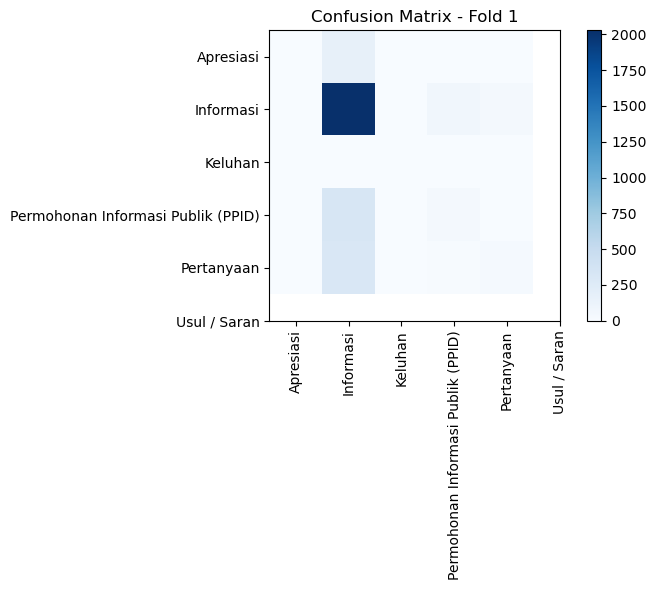

=========Fold :  1 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0  165    0    5    6]
 [   1 2029    1   67   42]
 [   0    0    0    0    0]
 [   0  326    0   42    2]
 [   0  306    0    8   30]]
Accuracy: 0.6933993399339934
Precision: [0.         0.71797594 0.         0.3442623  0.375     ]
Recall: [0.         0.94813084 0.         0.11351351 0.0872093 ]
F1-Score: [0.         0.81715667 0.         0.17073171 0.14150943]
Processing time 0.03354597091674805
=========Macro Average=========
Precision Macro Avg : 0.2874476465606256
Recall Macro Avg: 0.22977073139211807
F1-Score Macro Avg: 0.22587956132070838
=========Micro Average=========
Precision Micro Avg: 0.6933993399339934
Recall Micro Avg: 0.6933993399339934
F1-Score Micro Avg: 0.6933993399339934
=========Weighted Average=========
Precision Weighted Avg: 0.5916982032685187
Recall Weighted Avg: 0.6933993399339934
F1-Score Weighted Avg: 0.6140479342521894




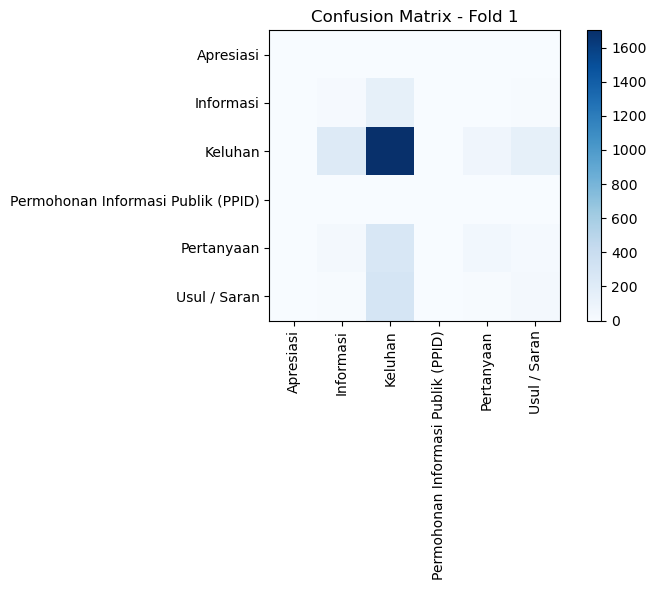

=========Fold :  1 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    0    0    0    0]
 [   0   19  142    1    5    9]
 [   1  217 1701    5   70  146]
 [   0    0    0    0    0    0]
 [   0   30  263    1   53   23]
 [   0   13  288    4    7   32]]
Accuracy: 0.5957095709570958
Precision: [0.         0.06810036 0.71052632 0.         0.39259259 0.15238095]
Recall: [0.         0.10795455 0.79485981 0.         0.14324324 0.09302326]
F1-Score: [0.         0.08351648 0.75033083 0.         0.20990099 0.11552347]
Processing time 12.0936598777771
=========Macro Average=========
Precision Macro Avg : 0.22060003653099294
Recall Macro Avg: 0.18984680959930902
F1-Score Macro Avg: 0.1932119621700652
=========Micro Average=========
Precision Micro Avg: 0.5957095709570958
Recall Micro Avg: 0.5957095709570958
F1-Score Micro Avg: 0.5957095709570958
=========Weighted Average=========
Precision Weighted Avg: 0.5710198962872006
Recall Weighted Avg: 0.5957095709570958
F1-Score Weighted A

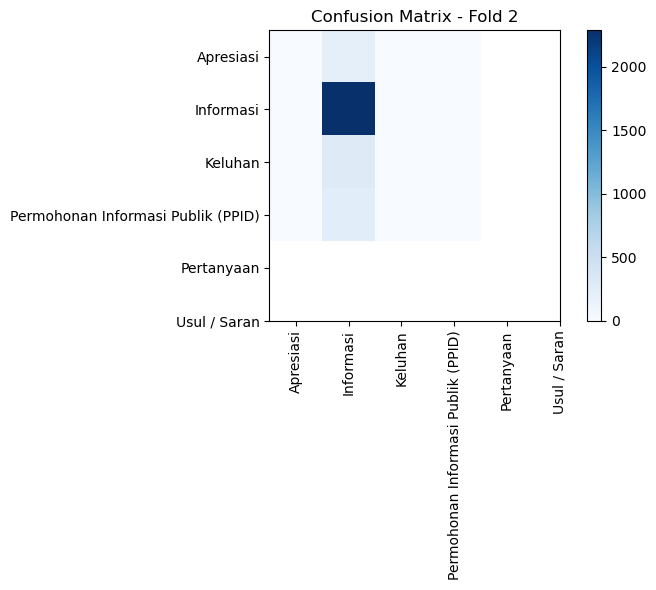

=========Fold :  2 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  214    0    0]
 [   0 2287    0    0]
 [   0  285    0    0]
 [   0  244    0    0]]
Accuracy: 0.7547854785478548
Precision: [0.         0.75478548 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.86025954 0.         0.        ]
Processing time 0.02951812744140625
=========Macro Average=========
Precision Macro Avg : 0.1886963696369637
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2150648862140305
=========Micro Average=========
Precision Micro Avg: 0.7547854785478548
Recall Micro Avg: 0.7547854785478548
F1-Score Micro Avg: 0.7547854785478548
=========Weighted Average=========
Precision Weighted Avg: 0.5697011186267141
Recall Weighted Avg: 0.7547854785478548
F1-Score Weighted Avg: 0.6493114122395878




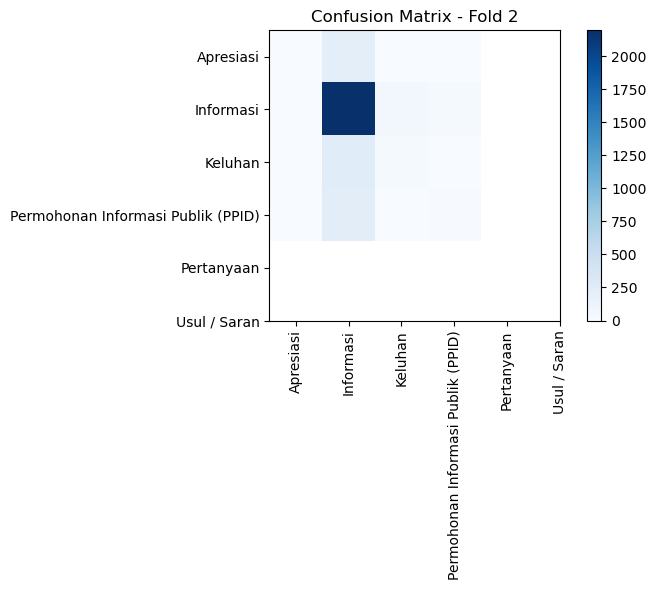

=========Fold :  2 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0  206    4    4]
 [   0 2195   62   30]
 [   0  251   31    3]
 [   0  223    7   14]]
Accuracy: 0.7392739273927392
Precision: [0.         0.76347826 0.29807692 0.2745098 ]
Recall: [0.         0.95977263 0.10877193 0.05737705]
F1-Score: [0.         0.85044556 0.15938303 0.09491525]
Processing time 0.031558990478515625
=========Macro Average=========
Precision Macro Avg : 0.33401624696701426
Recall Macro Avg: 0.2814804017254243
F1-Score Macro Avg: 0.27618596284782443
=========Micro Average=========
Precision Micro Avg: 0.7392739273927392
Recall Micro Avg: 0.7392739273927392
F1-Score Micro Avg: 0.7392739273927392
=========Weighted Average=========
Precision Weighted Avg: 0.6264049827862976
Recall Weighted Avg: 0.7392739273927392
F1-Score Weighted Avg: 0.6645387758482619




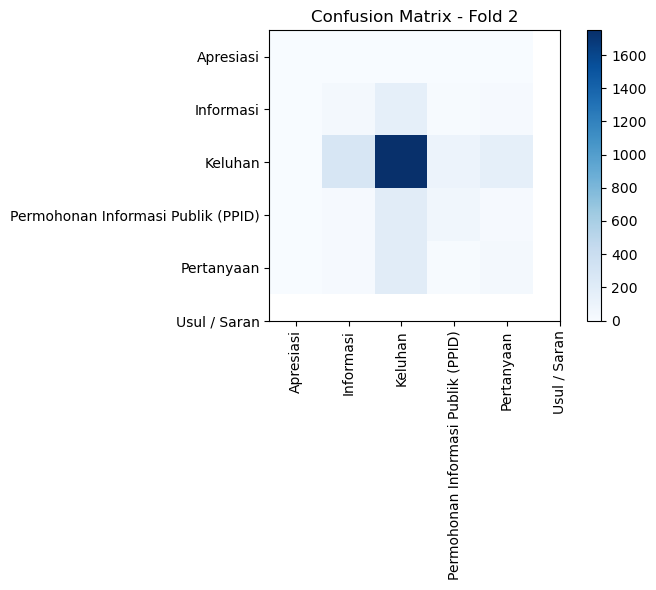

=========Fold :  2 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    0    0    0]
 [   0   36  154    8   16]
 [   2  284 1749  100  152]
 [   0   17  196   58   14]
 [   0   14  194    8   28]]
Accuracy: 0.6174917491749174
Precision: [0.         0.1025641  0.76275621 0.33333333 0.13333333]
Recall: [0.         0.1682243  0.76475732 0.20350877 0.1147541 ]
F1-Score: [0.         0.12743363 0.76375546 0.25272331 0.12334802]
Processing time 12.254639148712158
=========Macro Average=========
Precision Macro Avg : 0.26639739675936797
Recall Macro Avg: 0.2502488986722296
F1-Score Macro Avg: 0.2534520832003708
=========Micro Average=========
Precision Micro Avg: 0.6174917491749174
Recall Micro Avg: 0.6174917491749174
F1-Score Micro Avg: 0.6174917491749174
=========Weighted Average=========
Precision Weighted Avg: 0.6250513247507112
Recall Weighted Avg: 0.6174917491749174
F1-Score Weighted Avg: 0.6191757723349968




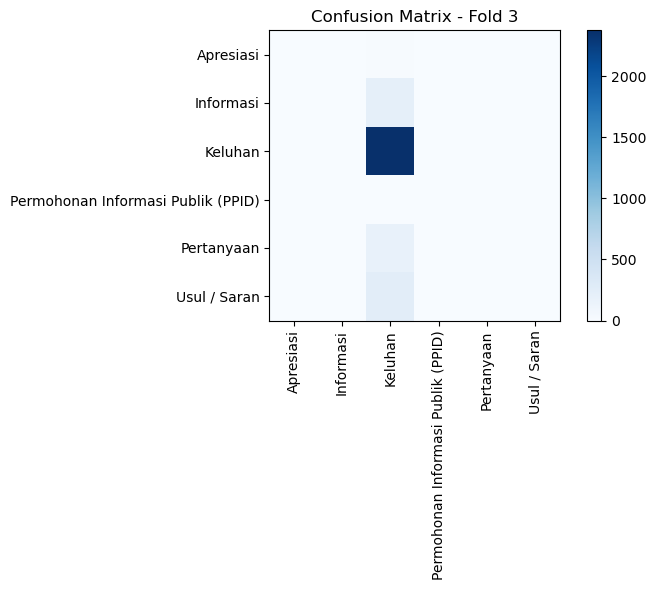

=========Fold :  3 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0   10    0    0    0]
 [   0    0  208    0    0    0]
 [   0    0 2377    0    0    0]
 [   0    0    6    0    0    0]
 [   0    0  178    0    0    0]
 [   0    0  250    0    0    0]]
Accuracy: 0.7847474413998019
Precision: [0.         0.         0.78474744 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.87939327 0.         0.         0.        ]
Processing time 0.025778770446777344
=========Macro Average=========
Precision Macro Avg : 0.13079124023330033
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.14656554445677641
=========Micro Average=========
Precision Micro Avg: 0.7847474413998019
Recall Micro Avg: 0.7847474413998019
F1-Score Micro Avg: 0.7847474413998019
=========Weighted Average=========
Precision Weighted Avg: 0.6158285467835355
Recall Weighted Avg: 0.7847474413998019
F1-Score Weighted Avg: 0.6901016160589453




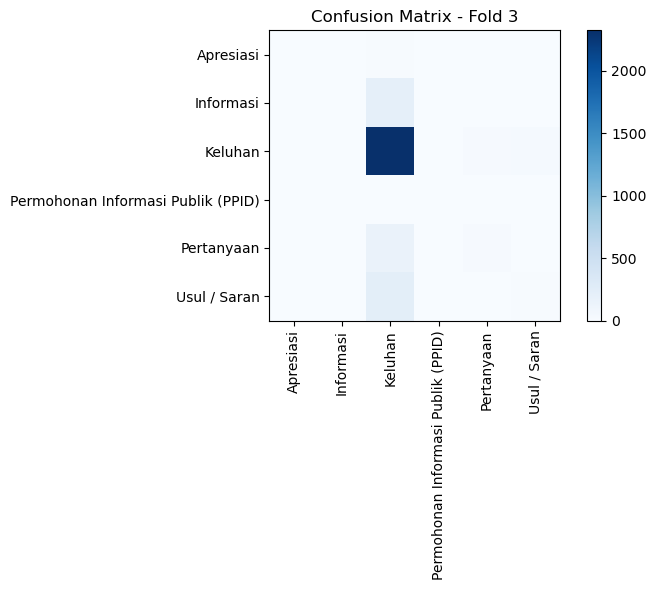

=========Fold :  3 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0   10    0    0    0]
 [   0    0  202    0    5    1]
 [   0    0 2322    0   25   30]
 [   0    0    3    0    2    1]
 [   0    0  152    0   24    2]
 [   0    0  234    0    2   14]]
Accuracy: 0.7791350280620667
Precision: [0.         0.         0.79438933 0.         0.4137931  0.29166667]
Recall: [0.         0.         0.97686159 0.         0.13483146 0.056     ]
F1-Score: [0.         0.         0.87622642 0.         0.20338983 0.09395973]
Processing time 0.03159594535827637
=========Macro Average=========
Precision Macro Avg : 0.24997484935830638
Recall Macro Avg: 0.19461550848565923
F1-Score Macro Avg: 0.19559599619107307
=========Micro Average=========
Precision Micro Avg: 0.7791350280620667
Recall Micro Avg: 0.7791350280620667
F1-Score Micro Avg: 0.7791350280620666
=========Weighted Average=========
Precision Weighted Avg: 0.6717845054689359
Recall Weighted Avg: 0.7791350280620667
F1-Score Weigh

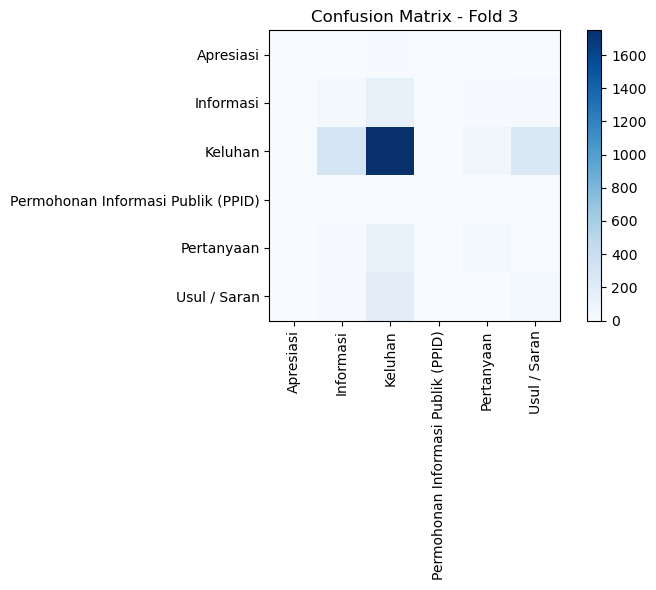

=========Fold :  3 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    2    7    0    0    1]
 [   0   31  146    0   11   20]
 [   0  314 1749    2   65  247]
 [   0    1    5    0    0    0]
 [   0   15  121    0   40    2]
 [   0   20  182    0    3   45]]
Accuracy: 0.6157147573456586
Precision: [0.         0.08093995 0.79140271 0.         0.33613445 0.14285714]
Recall: [0.         0.14903846 0.73580143 0.         0.2247191  0.18      ]
F1-Score: [0.         0.10490694 0.76258993 0.         0.26936027 0.15929204]
Processing time 11.710869073867798
=========Macro Average=========
Precision Macro Avg : 0.2252223765585768
Recall Macro Avg: 0.2149264988394131
F1-Score Macro Avg: 0.21602486170171675
=========Micro Average=========
Precision Micro Avg: 0.6157147573456586
Recall Micro Avg: 0.6157147573456586
F1-Score Micro Avg: 0.6157147573456586
=========Weighted Average=========
Precision Weighted Avg: 0.6581531796036452
Recall Weighted Avg: 0.6157147573456586
F1-Score Weighted 

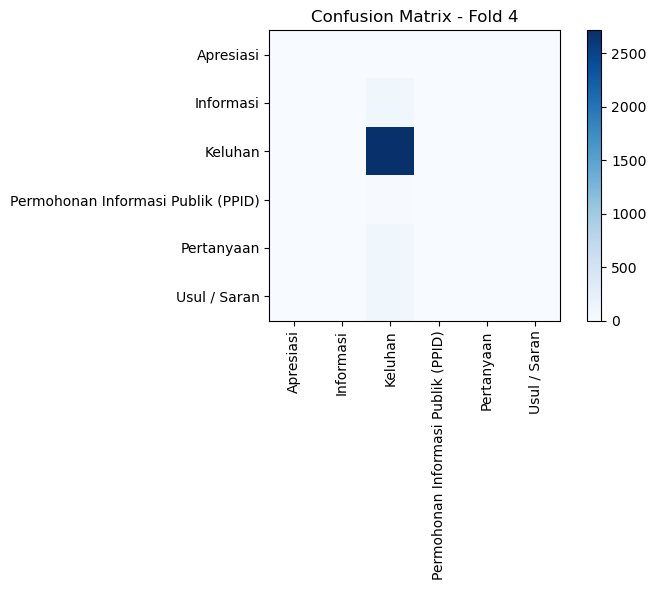

=========Fold :  4 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0    4    0    0    0]
 [   0    0   98    0    0    0]
 [   0    0 2714    0    0    0]
 [   0    0   11    0    0    0]
 [   0    0  100    0    0    0]
 [   0    0  102    0    0    0]]
Accuracy: 0.8960052822713767
Precision: [0.         0.         0.89600528 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.94515062 0.         0.         0.        ]
Processing time 0.027109146118164062
=========Macro Average=========
Precision Macro Avg : 0.14933421371189612
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.1575251030239712
=========Micro Average=========
Precision Micro Avg: 0.8960052822713767
Recall Micro Avg: 0.8960052822713767
F1-Score Micro Avg: 0.8960052822713767
=========Weighted Average=========
Precision Weighted Avg: 0.8028254658582094
Recall Weighted Avg: 0.8960052822713767
F1-Score Weighted Avg: 0.846859946398926




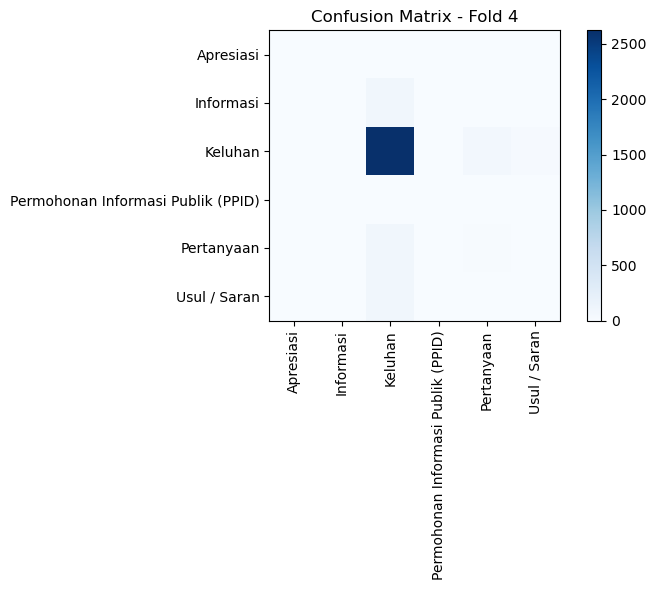

=========Fold :  4 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0    4    0    0    0]
 [   0    0   90    0    5    3]
 [   0    0 2622    1   67   24]
 [   0    0   10    0    1    0]
 [   0    0   86    0   13    1]
 [   0    0   89    0    5    8]]
Accuracy: 0.872565203037306
Precision: [0.         0.         0.90382627 0.         0.14285714 0.22222222]
Recall: [0.         0.         0.96610169 0.         0.13       0.07843137]
F1-Score: [0.         0.         0.93392698 0.         0.13612565 0.11594203]
Processing time 0.03324484825134277
=========Macro Average=========
Precision Macro Avg : 0.21148427198065253
Recall Macro Avg: 0.19575551124404564
F1-Score Macro Avg: 0.19766577745597635
=========Micro Average=========
Precision Micro Avg: 0.872565203037306
Recall Micro Avg: 0.872565203037306
F1-Score Micro Avg: 0.872565203037306
=========Weighted Average=========
Precision Weighted Avg: 0.8220326408253318
Recall Weighted Avg: 0.872565203037306
F1-Score Weighted A

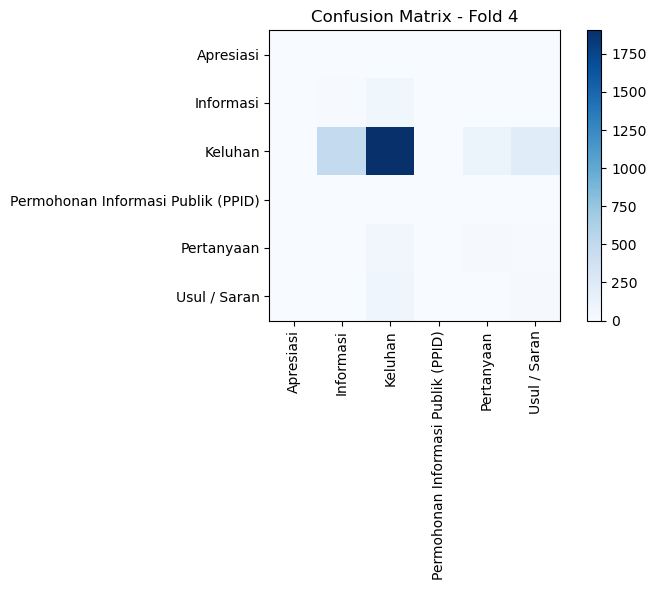

=========Fold :  4 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    3    0    0    1]
 [   0   14   72    1    6    5]
 [   1  489 1904    0  103  217]
 [   0    3    5    1    2    0]
 [   0    6   66    0   19    9]
 [   0    6   78    0    2   16]]
Accuracy: 0.6450973918785078
Precision: [0.         0.02702703 0.89473684 0.5        0.14393939 0.06451613]
Recall: [0.         0.14285714 0.70154753 0.09090909 0.19       0.15686275]
F1-Score: [0.         0.04545455 0.78645188 0.15384615 0.1637931  0.09142857]
Processing time 10.909013986587524
=========Macro Average=========
Precision Macro Avg : 0.2717032320173237
Recall Macro Avg: 0.2136960850305599
F1-Score Macro Avg: 0.20682904226103813
=========Micro Average=========
Precision Micro Avg: 0.6450973918785078
Recall Micro Avg: 0.6450973918785078
F1-Score Micro Avg: 0.6450973918785078
=========Weighted Average=========
Precision Weighted Avg: 0.8113037380909748
Recall Weighted Avg: 0.6450973918785078
F1-Score Weighted 

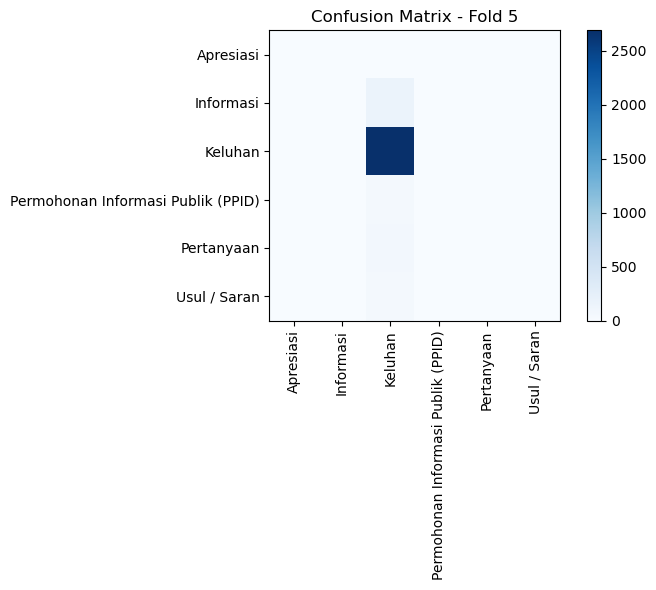

=========Fold :  5 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0    2    0    0    0]
 [   0    0  160    0    0    0]
 [   0    0 2687    0    0    1]
 [   0    0   61    0    0    0]
 [   0    0   67    0    0    0]
 [   0    0   51    0    0    0]]
Accuracy: 0.8870914493232089
Precision: [0.         0.         0.88738441 0.         0.         0.        ]
Recall: [0.         0.         0.99962798 0.         0.         0.        ]
F1-Score: [0.         0.         0.94016795 0.         0.         0.        ]
Processing time 0.02530384063720703
=========Macro Average=========
Precision Macro Avg : 0.14789740202553942
Recall Macro Avg: 0.1666046626984127
F1-Score Macro Avg: 0.1566946582691859
=========Micro Average=========
Precision Micro Avg: 0.8870914493232089
Recall Micro Avg: 0.8870914493232089
F1-Score Micro Avg: 0.8870914493232089
=========Weighted Average=========
Precision Weighted Avg: 0.787484087113866
Recall Weighted Avg: 0.8870914493232089
F1-Score Weight

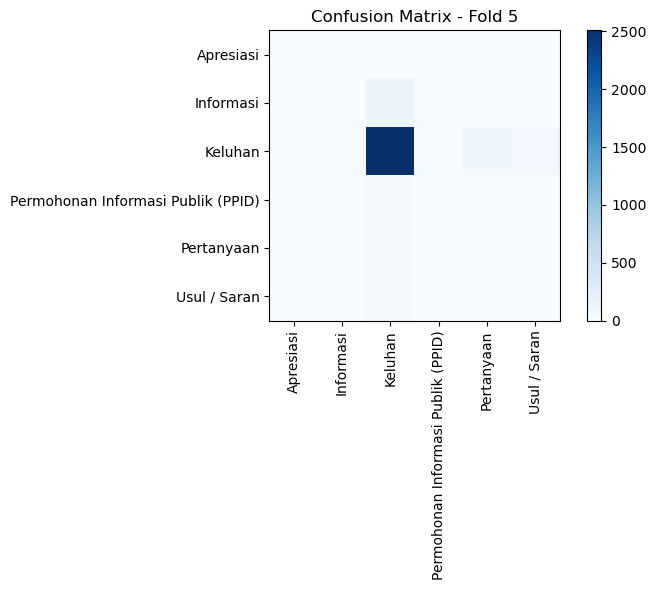

=========Fold :  5 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0    2    0    0    0]
 [   0    0  154    0    6    0]
 [   0   11 2510    0   94   73]
 [   0    0   53    0    8    0]
 [   0    0   54    0   12    1]
 [   0    0   43    0    2    6]]
Accuracy: 0.8345988775173324
Precision: [0.         0.         0.89133523 0.         0.09836066 0.075     ]
Recall: [0.         0.         0.93377976 0.         0.17910448 0.11764706]
F1-Score: [0.         0.         0.91206395 0.         0.12698413 0.09160305]
Processing time 0.031449079513549805
=========Macro Average=========
Precision Macro Avg : 0.17744931383507204
Recall Macro Avg: 0.20508854972337195
F1-Score Macro Avg: 0.18844185565126892
=========Micro Average=========
Precision Micro Avg: 0.8345988775173324
Recall Micro Avg: 0.8345988775173324
F1-Score Micro Avg: 0.8345988775173324
=========Weighted Average=========
Precision Weighted Avg: 0.7944286083999725
Recall Weighted Avg: 0.8345988775173324
F1-Score Weig

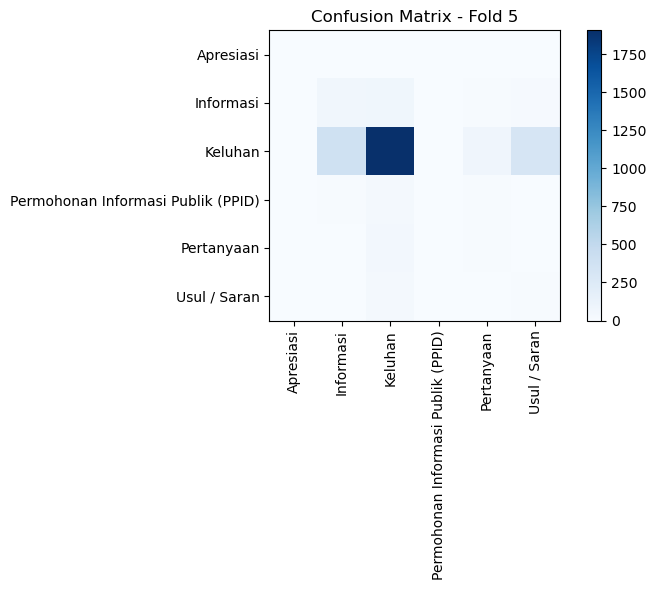

=========Fold :  5 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    2    0    0    0]
 [   0   64   71    0   10   15]
 [   2  385 1906    0   80  315]
 [   0    9   36    1   12    3]
 [   0    5   47    0   11    4]
 [   0    5   31    0    3   12]]
Accuracy: 0.6583030703202377
Precision: [0.         0.13675214 0.91065456 1.         0.09482759 0.03438395]
Recall: [0.         0.4        0.70907738 0.01639344 0.1641791  0.23529412]
F1-Score: [0.         0.20382166 0.79732274 0.03225806 0.12021858 0.06      ]
Processing time 10.117964029312134
=========Macro Average=========
Precision Macro Avg : 0.36276970665703945
Recall Macro Avg: 0.2541573409500004
F1-Score Macro Avg: 0.20227017260523025
=========Micro Average=========
Precision Micro Avg: 0.6583030703202377
Recall Micro Avg: 0.6583030703202377
F1-Score Micro Avg: 0.6583030703202377
=========Weighted Average=========
Precision Weighted Avg: 0.8381732706177081
Recall Weighted Avg: 0.6583030703202377
F1-Score Weighted

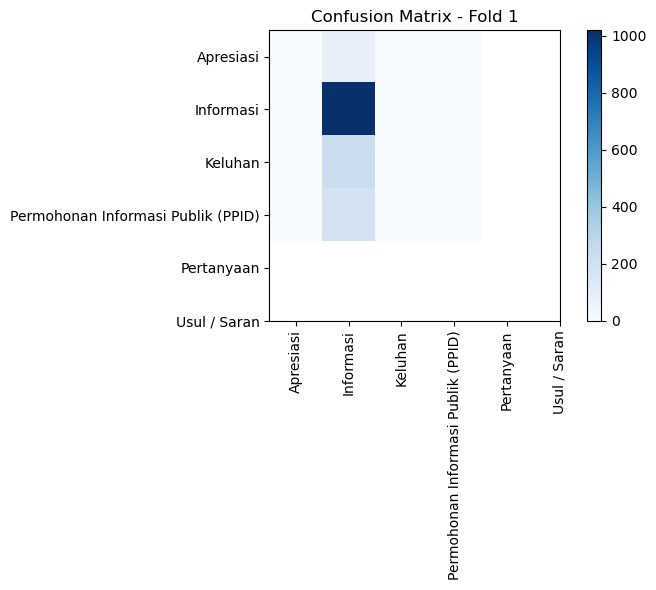

=========Fold :  1 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0   82    0    0]
 [   0 1019    0    0]
 [   0  227    0    0]
 [   0  187    0    0]]
Accuracy: 0.6726072607260726
Precision: [0.         0.67260726 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.80426204 0.         0.        ]
Processing time 0.029103755950927734
=========Macro Average=========
Precision Macro Avg : 0.16815181518151814
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.20106550907655882
=========Micro Average=========
Precision Micro Avg: 0.6726072607260726
Recall Micro Avg: 0.6726072607260726
F1-Score Micro Avg: 0.6726072607260726
=========Weighted Average=========
Precision Weighted Avg: 0.45240052718143103
Recall Weighted Avg: 0.6726072607260726
F1-Score Weighted Avg: 0.5409524851459101




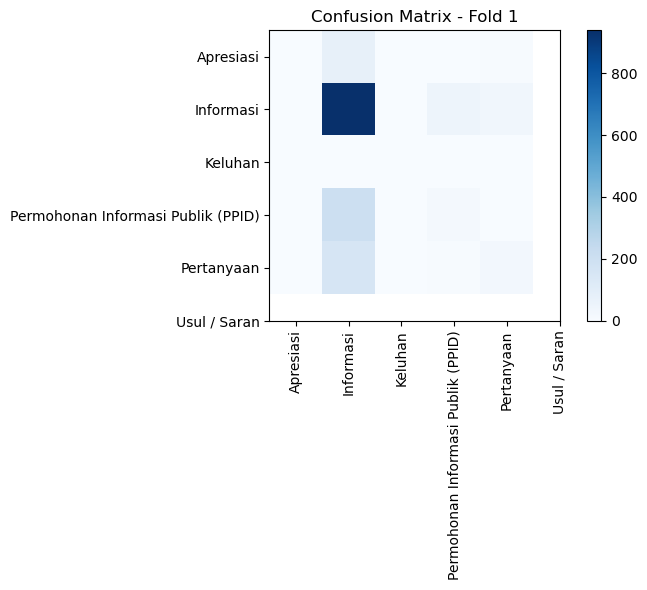

=========Fold :  1 =========
Classifier: BernoulliNB
Confusion Matrix:
[[  0  77   0   1   4]
 [  0 939   1  46  33]
 [  0   0   0   0   0]
 [  0 204   0  21   2]
 [  0 156   0   6  25]]
Accuracy: 0.6501650165016502
Precision: [0.         0.68241279 0.         0.28378378 0.390625  ]
Recall: [0.         0.92149166 0.         0.09251101 0.13368984]
F1-Score: [0.         0.78413361 0.         0.13953488 0.19920319]
Processing time 0.03371000289916992
=========Macro Average=========
Precision Macro Avg : 0.27136431489629165
Recall Macro Avg: 0.2295385022553532
F1-Score Macro Avg: 0.22457433653258985
=========Micro Average=========
Precision Micro Avg: 0.6501650165016502
Recall Micro Avg: 0.6501650165016502
F1-Score Micro Avg: 0.6501650165016502
=========Weighted Average=========
Precision Weighted Avg: 0.5497322954718477
Recall Weighted Avg: 0.6501650165016502
F1-Score Weighted Avg: 0.5729092837846468




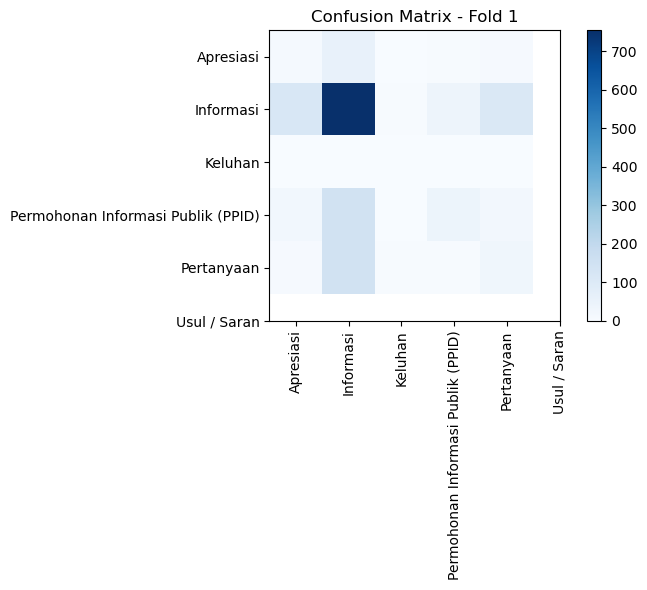

=========Fold :  1 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 11  57   1   5   8]
 [116 755   5  36 107]
 [  0   0   0   0   0]
 [ 22 147   0  40  18]
 [  7 145   4   3  28]]
Accuracy: 0.5504950495049505
Precision: [0.07051282 0.68387681 0.         0.47619048 0.17391304]
Recall: [0.13414634 0.74092247 0.         0.17621145 0.14973262]
F1-Score: [0.09243697 0.71125765 0.         0.25723473 0.16091954]
Processing time 13.082327842712402
=========Macro Average=========
Precision Macro Avg : 0.28089863035515206
Recall Macro Avg: 0.24020257770830425
F1-Score Macro Avg: 0.24436977919414793
=========Micro Average=========
Precision Micro Avg: 0.5504950495049505
Recall Micro Avg: 0.5504950495049505
F1-Score Micro Avg: 0.5504950495049505
=========Weighted Average=========
Precision Weighted Avg: 0.5566135310377669
Recall Weighted Avg: 0.5504950495049505
F1-Score Weighted Avg: 0.5418056888500267




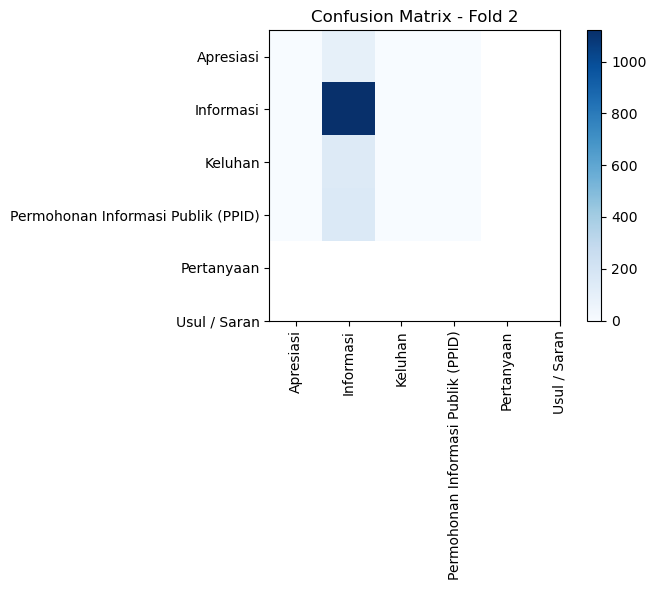

=========Fold :  2 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0   94    0    0]
 [   0 1121    0    0]
 [   0  143    0    0]
 [   0  157    0    0]]
Accuracy: 0.73993399339934
Precision: [0.         0.73993399 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.85053111 0.         0.        ]
Processing time 0.02935791015625
=========Macro Average=========
Precision Macro Avg : 0.184983498349835
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21263277693474963
=========Micro Average=========
Precision Micro Avg: 0.73993399339934
Recall Micro Avg: 0.73993399339934
F1-Score Micro Avg: 0.73993399339934
=========Weighted Average=========
Precision Weighted Avg: 0.5475023145878944
Recall Weighted Avg: 0.73993399339934
F1-Score Weighted Avg: 0.6293368790596814




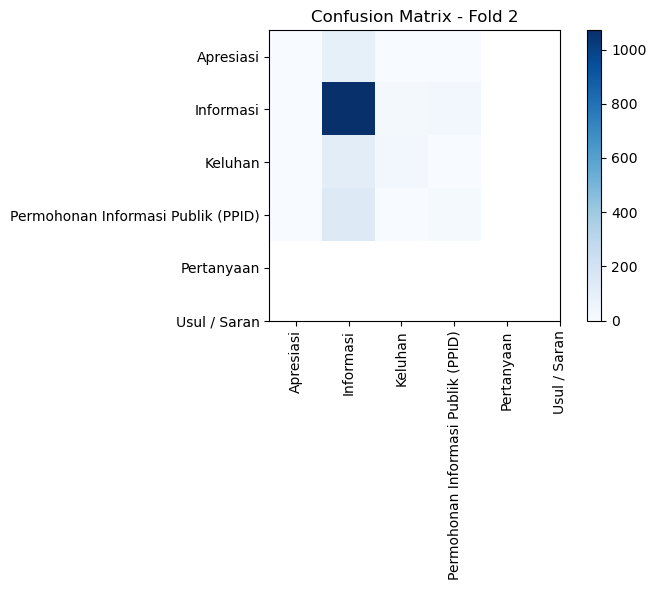

=========Fold :  2 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0   88    4    2]
 [   1 1071   23   26]
 [   0  111   31    1]
 [   0  141    3   13]]
Accuracy: 0.735973597359736
Precision: [0.         0.75903614 0.50819672 0.30952381]
Recall: [0.         0.95539697 0.21678322 0.08280255]
F1-Score: [0.         0.84597156 0.30392157 0.13065327]
Processing time 0.03683805465698242
=========Macro Average=========
Precision Macro Avg : 0.39418916885339955
Recall Macro Avg: 0.31374568288691823
F1-Score Macro Avg: 0.32013659973503794
=========Micro Average=========
Precision Micro Avg: 0.735973597359736
Recall Micro Avg: 0.735973597359736
F1-Score Micro Avg: 0.735973597359736
=========Weighted Average=========
Precision Weighted Avg: 0.6416811137393189
Recall Weighted Avg: 0.735973597359736
F1-Score Weighted Avg: 0.6681897494063002




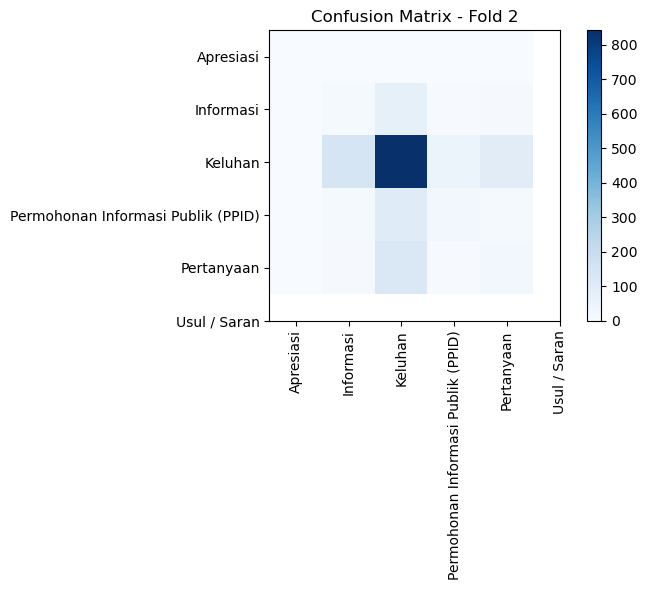

=========Fold :  2 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   0   0   0]
 [  0  12  70   4   8]
 [  1 140 842  44  94]
 [  0  12 101  20  10]
 [  0   8 123   6  20]]
Accuracy: 0.5900990099009901
Precision: [0.         0.06976744 0.74119718 0.27027027 0.15151515]
Recall: [0.         0.12765957 0.75111508 0.13986014 0.12738854]
F1-Score: [0.         0.09022556 0.74612317 0.1843318  0.1384083 ]
Processing time 11.19867491722107
=========Macro Average=========
Precision Macro Avg : 0.2465500093488957
Recall Macro Avg: 0.22920466503704562
F1-Score Macro Avg: 0.2318177675991496
=========Micro Average=========
Precision Micro Avg: 0.5900990099009901
Recall Micro Avg: 0.5900990099009901
F1-Score Micro Avg: 0.5900990099009901
=========Weighted Average=========
Precision Weighted Avg: 0.5939780258910443
Recall Weighted Avg: 0.5900990099009901
F1-Score Weighted Avg: 0.5894223300499739




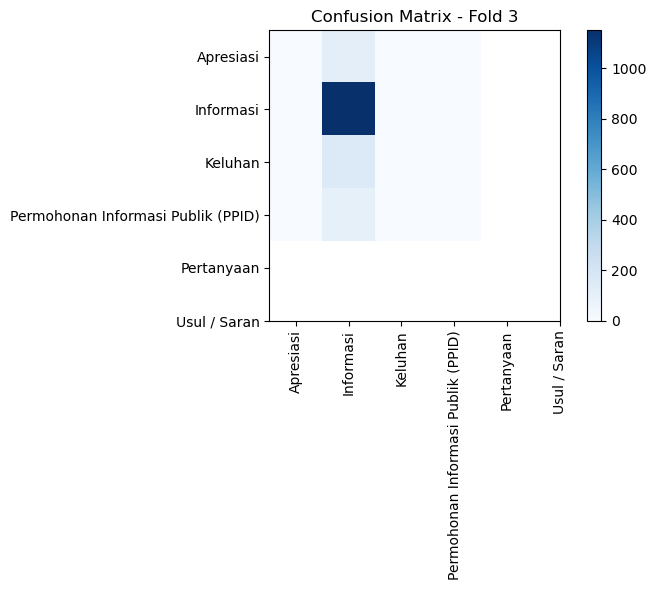

=========Fold :  3 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  114    0    0]
 [   0 1151    0    0]
 [   0  154    0    0]
 [   0   96    0    0]]
Accuracy: 0.7597359735973598
Precision: [0.         0.75973597 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.86346587 0.         0.        ]
Processing time 0.028575897216796875
=========Macro Average=========
Precision Macro Avg : 0.18993399339933995
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.21586646661665418
=========Micro Average=========
Precision Micro Avg: 0.7597359735973598
Recall Micro Avg: 0.7597359735973598
F1-Score Micro Avg: 0.7597359735973598
=========Weighted Average=========
Precision Weighted Avg: 0.577198749577928
Recall Weighted Avg: 0.7597359735973598
F1-Score Weighted Avg: 0.6560060807281028




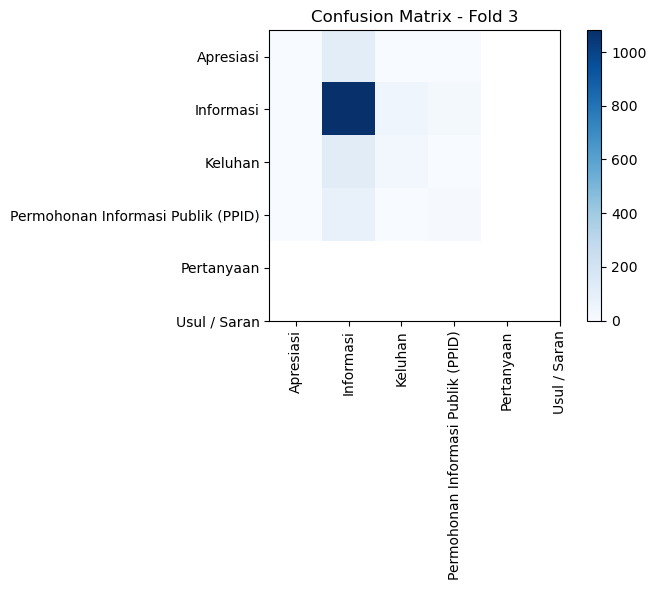

=========Fold :  3 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0  111    2    1]
 [   0 1081   48   22]
 [   0  122   28    4]
 [   0   81    3   12]]
Accuracy: 0.73993399339934
Precision: [0.         0.77491039 0.34567901 0.30769231]
Recall: [0.         0.93918332 0.18181818 0.125     ]
F1-Score: [0.         0.84917518 0.23829787 0.17777778]
Processing time 0.03870201110839844
=========Macro Average=========
Precision Macro Avg : 0.3570704285758049
Recall Macro Avg: 0.31150037516783824
F1-Score Macro Avg: 0.31631270671651074
=========Micro Average=========
Precision Micro Avg: 0.73993399339934
Recall Micro Avg: 0.73993399339934
F1-Score Micro Avg: 0.73993399339934
=========Weighted Average=========
Precision Weighted Avg: 0.6433629658343097
Recall Weighted Avg: 0.73993399339934
F1-Score Weighted Avg: 0.6806370742203669




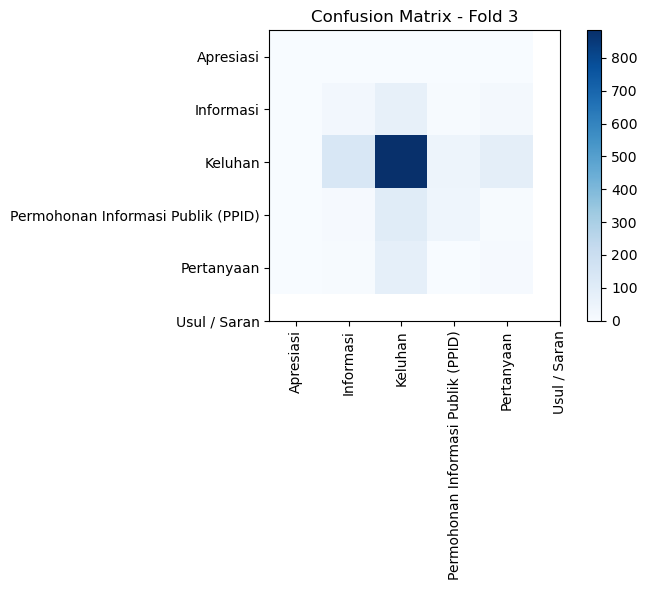

=========Fold :  3 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   0   0   0]
 [  0  24  70   5  15]
 [  1 138 884  44  84]
 [  0   7 103  38   6]
 [  0   6  78   2  10]]
Accuracy: 0.6310231023102311
Precision: [0.         0.13714286 0.77885463 0.42696629 0.08695652]
Recall: [0.         0.21052632 0.7680278  0.24675325 0.10416667]
F1-Score: [0.         0.16608997 0.77340332 0.3127572  0.09478673]
Processing time 10.937496185302734
=========Macro Average=========
Precision Macro Avg : 0.28598405931349596
Recall Macro Avg: 0.26589480622415373
F1-Score Macro Avg: 0.2694074442972522
=========Micro Average=========
Precision Micro Avg: 0.6310231023102311
Recall Micro Avg: 0.6310231023102311
F1-Score Micro Avg: 0.6310231023102311
=========Weighted Average=========
Precision Weighted Avg: 0.6509548480520243
Recall Weighted Avg: 0.6310231023102311
F1-Score Weighted Avg: 0.6378782955590014




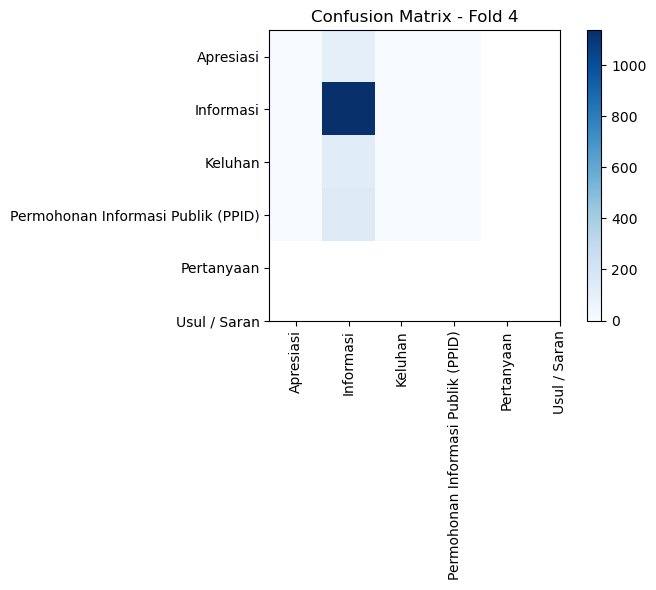

=========Fold :  4 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0  100    0    0]
 [   0 1136    0    0]
 [   0  131    0    0]
 [   0  148    0    0]]
Accuracy: 0.7498349834983499
Precision: [0.         0.74983498 0.         0.        ]
Recall: [0. 1. 0. 0.]
F1-Score: [0.         0.85703508 0.         0.        ]
Processing time 0.02870321273803711
=========Macro Average=========
Precision Macro Avg : 0.18745874587458747
Recall Macro Avg: 0.25
F1-Score Macro Avg: 0.2142587702753678
=========Micro Average=========
Precision Micro Avg: 0.7498349834983499
Recall Micro Avg: 0.7498349834983499
F1-Score Micro Avg: 0.7498349834983499
=========Weighted Average=========
Precision Weighted Avg: 0.5622525024779705
Recall Weighted Avg: 0.7498349834983499
F1-Score Weighted Avg: 0.6426348858952285




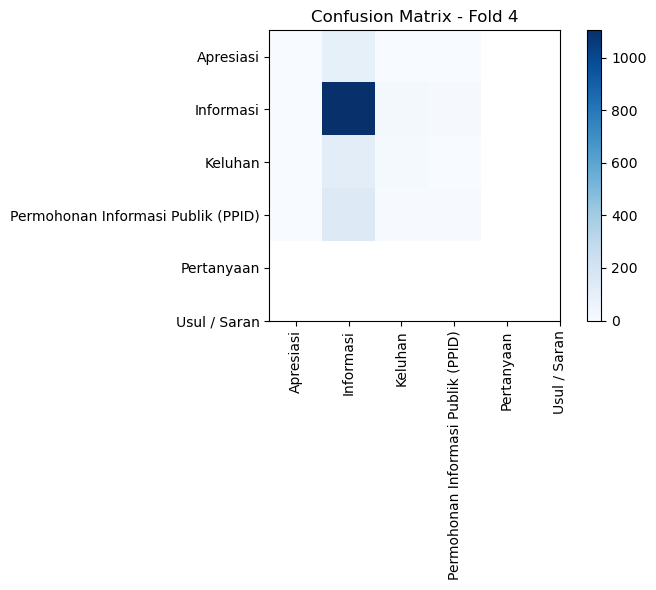

=========Fold :  4 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0   94    3    3]
 [   0 1104   23    9]
 [   0  116   15    0]
 [   0  138    5    5]]
Accuracy: 0.7419141914191419
Precision: [0.         0.76033058 0.32608696 0.29411765]
Recall: [0.         0.97183099 0.11450382 0.03378378]
F1-Score: [0.         0.85316847 0.16949153 0.06060606]
Processing time 0.03542900085449219
=========Macro Average=========
Precision Macro Avg : 0.34513379552323986
Recall Macro Avg: 0.2800296466232925
F1-Score Macro Avg: 0.2708165139726715
=========Micro Average=========
Precision Micro Avg: 0.7419141914191419
Recall Micro Avg: 0.7419141914191419
F1-Score Micro Avg: 0.7419141914191419
=========Weighted Average=========
Precision Weighted Avg: 0.6270510496759977
Recall Weighted Avg: 0.7419141914191419
F1-Score Weighted Avg: 0.660311860437085




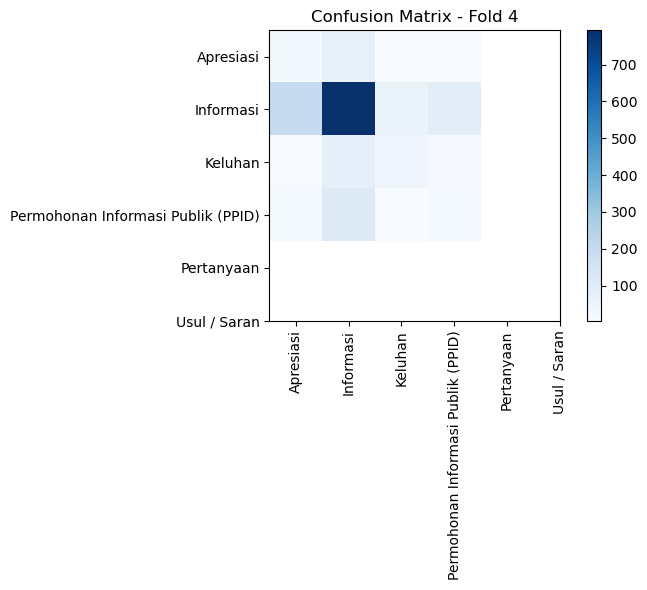

=========Fold :  4 =========
Classifier: GaussianNB
Confusion Matrix:
[[ 19  70   6   5]
 [199 793  56  88]
 [ 10  73  36  12]
 [ 17 109   6  16]]
Accuracy: 0.5702970297029702
Precision: [0.07755102 0.75885167 0.34615385 0.1322314 ]
Recall: [0.19       0.69806338 0.27480916 0.10810811]
F1-Score: [0.11014493 0.72718936 0.30638298 0.11895911]
Processing time 10.828805923461914
=========Macro Average=========
Precision Macro Avg : 0.32869698654045887
Recall Macro Avg: 0.31774516217378546
F1-Score Macro Avg: 0.31566909418599953
=========Micro Average=========
Precision Micro Avg: 0.5702970297029702
Recall Micro Avg: 0.5702970297029702
F1-Score Micro Avg: 0.5702970297029702
=========Weighted Average=========
Precision Weighted Avg: 0.6169815222529366
Recall Weighted Avg: 0.5702970297029702
F1-Score Weighted Avg: 0.5906559253621211




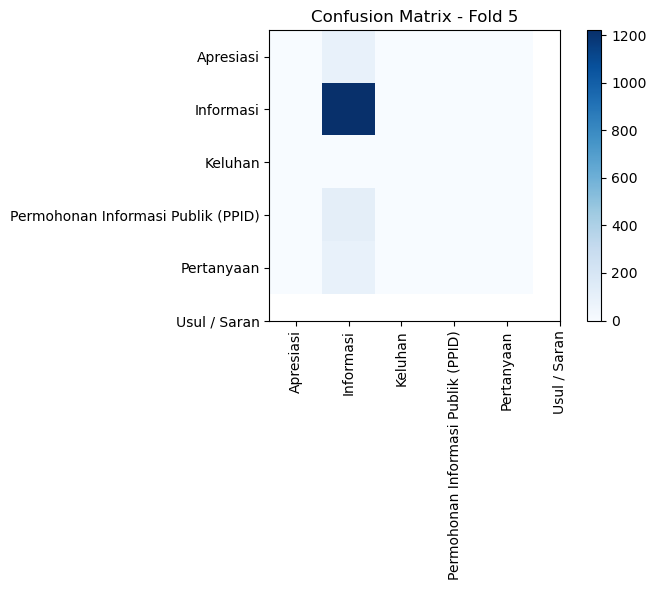

=========Fold :  5 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0   86    0    0    0]
 [   0 1221    0    0    0]
 [   0    1    0    0    0]
 [   0  118    0    0    0]
 [   0   89    0    0    0]]
Accuracy: 0.805940594059406
Precision: [0.         0.80594059 0.         0.         0.        ]
Recall: [0. 1. 0. 0. 0.]
F1-Score: [0.         0.89254386 0.         0.         0.        ]
Processing time 0.03008103370666504
=========Macro Average=========
Precision Macro Avg : 0.1611881188118812
Recall Macro Avg: 0.2
F1-Score Macro Avg: 0.17850877192982456
=========Micro Average=========
Precision Micro Avg: 0.805940594059406
Recall Micro Avg: 0.805940594059406
F1-Score Micro Avg: 0.805940594059406
=========Weighted Average=========
Precision Weighted Avg: 0.6495402411528282
Recall Weighted Avg: 0.805940594059406
F1-Score Weighted Avg: 0.7193373284696891




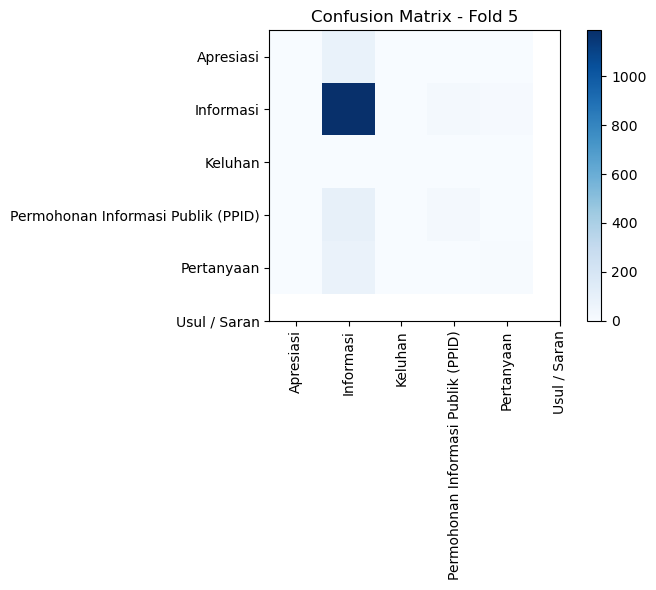

=========Fold :  5 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0   83    0    3    0]
 [   0 1189    0   20   12]
 [   0    0    0    1    0]
 [   0   94    0   24    0]
 [   0   78    0    2    9]]
Accuracy: 0.8066006600660066
Precision: [0.         0.8234072  0.         0.48       0.42857143]
Recall: [0.         0.97379197 0.         0.20338983 0.1011236 ]
F1-Score: [0.         0.89230769 0.         0.28571429 0.16363636]
Processing time 0.03528189659118652
=========Macro Average=========
Precision Macro Avg : 0.34639572615749903
Recall Macro Avg: 0.2556610799612133
F1-Score Macro Avg: 0.2683316683316683
=========Micro Average=========
Precision Micro Avg: 0.8066006600660066
Recall Micro Avg: 0.8066006600660066
F1-Score Micro Avg: 0.8066006600660066
=========Weighted Average=========
Precision Weighted Avg: 0.7261802317152966
Recall Weighted Avg: 0.8066006600660066
F1-Score Weighted Avg: 0.7510136068551911




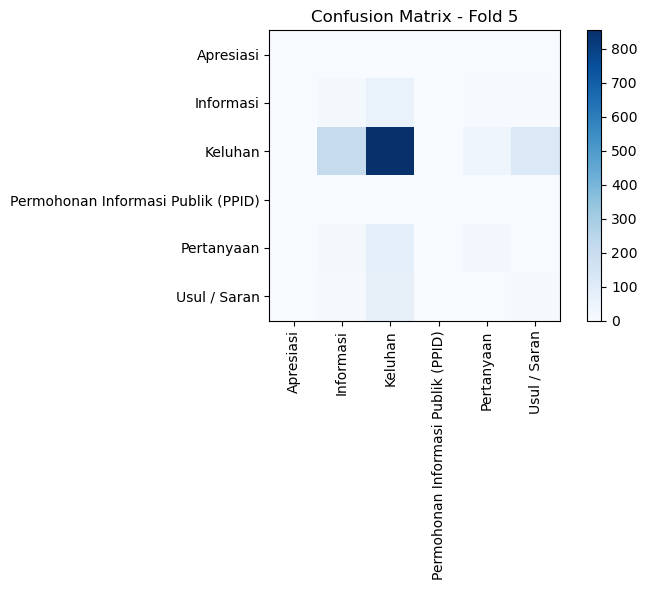

=========Fold :  5 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   0   0   0   0]
 [  0  18  58   0   6   4]
 [  1 207 854   1  40 118]
 [  0   0   1   0   0   0]
 [  0  14  79   0  24   1]
 [  0   8  67   0   2  12]]
Accuracy: 0.5993399339933994
Precision: [0.         0.07287449 0.80642115 0.         0.33333333 0.08888889]
Recall: [0.         0.20930233 0.6994267  0.         0.20338983 0.13483146]
F1-Score: [0.         0.10810811 0.74912281 0.         0.25263158 0.10714286]
Processing time 12.975031852722168
=========Macro Average=========
Precision Macro Avg : 0.2169196446965941
Recall Macro Avg: 0.20782505269845442
F1-Score Macro Avg: 0.20283422520264624
=========Micro Average=========
Precision Micro Avg: 0.5993399339933994
Recall Micro Avg: 0.5993399339933994
F1-Score Micro Avg: 0.5993399339933994
=========Weighted Average=========
Precision Weighted Avg: 0.6852487640601137
Recall Weighted Avg: 0.5993399339933994
F1-Score Weighted Avg: 0.6358564259189584




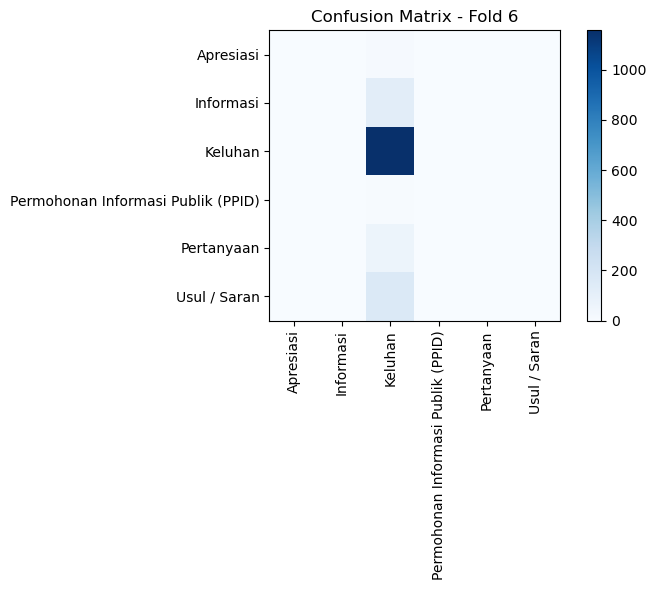

=========Fold :  6 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0   10    0    0    0]
 [   0    0  122    0    0    0]
 [   0    0 1157    0    0    0]
 [   0    0    5    0    0    0]
 [   0    0   60    0    0    0]
 [   0    0  161    0    0    0]]
Accuracy: 0.7636963696369637
Precision: [0.         0.         0.76369637 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.86601796 0.         0.         0.        ]
Processing time 0.030085086822509766
=========Macro Average=========
Precision Macro Avg : 0.1272827282728273
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.1443363273453094
=========Micro Average=========
Precision Micro Avg: 0.7636963696369637
Recall Micro Avg: 0.7636963696369637
F1-Score Micro Avg: 0.7636963696369637
=========Weighted Average=========
Precision Weighted Avg: 0.583232144996678
Recall Weighted Avg: 0.7636963696369637
F1-Score Weighted Avg: 0.6613747752020712




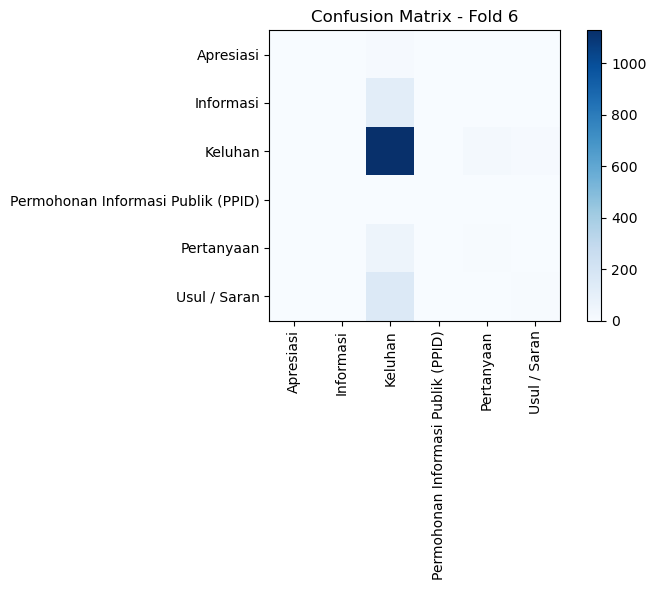

=========Fold :  6 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0   10    0    0    0]
 [   0    0  118    0    3    1]
 [   0    0 1128    0   19   10]
 [   0    0    3    0    2    0]
 [   0    0   55    0    5    0]
 [   0    0  154    0    2    5]]
Accuracy: 0.7511551155115511
Precision: [0.         0.         0.76839237 0.         0.16129032 0.3125    ]
Recall: [0.         0.         0.97493518 0.         0.08333333 0.0310559 ]
F1-Score: [0.         0.         0.85942857 0.         0.10989011 0.05649718]
Processing time 0.03985095024108887
=========Macro Average=========
Precision Macro Avg : 0.2070304488588087
Recall Macro Avg: 0.18155406852280323
F1-Score Macro Avg: 0.17096930940998736
=========Micro Average=========
Precision Micro Avg: 0.7511551155115511
Recall Micro Avg: 0.7511551155115511
F1-Score Micro Avg: 0.7511551155115511
=========Weighted Average=========
Precision Weighted Avg: 0.626415770367579
Recall Weighted Avg: 0.7511551155115511
F1-Score Weighte

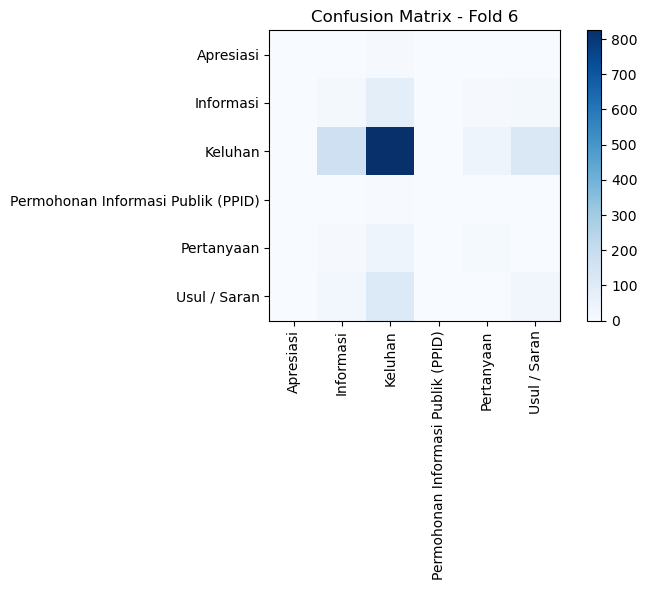

=========Fold :  6 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   2   7   0   0   1]
 [  0  18  81   0   7  16]
 [  0 172 825   1  39 120]
 [  0   1   4   0   0   0]
 [  0   8  41   0  10   1]
 [  0  20 111   0   1  29]]
Accuracy: 0.5821782178217821
Precision: [0.         0.08144796 0.7717493  0.         0.1754386  0.17365269]
Recall: [0.         0.14754098 0.71305099 0.         0.16666667 0.18012422]
F1-Score: [0.         0.10495627 0.74123989 0.         0.17094017 0.17682927]
Processing time 13.334693193435669
=========Macro Average=========
Precision Macro Avg : 0.2003814255521067
Recall Macro Avg: 0.20123047797092983
F1-Score Macro Avg: 0.19899426660628608
=========Micro Average=========
Precision Micro Avg: 0.5821782178217821
Recall Micro Avg: 0.5821782178217821
F1-Score Micro Avg: 0.5821782178217821
=========Weighted Average=========
Precision Weighted Avg: 0.6213432273700168
Recall Weighted Avg: 0.5821782178217821
F1-Score Weighted Avg: 0.6000958035845736




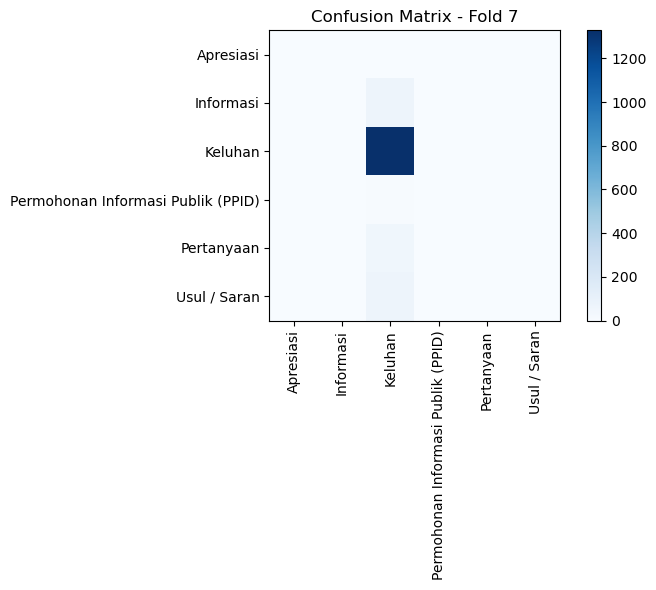

=========Fold :  7 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0    3    0    0    0]
 [   0    0   63    0    0    0]
 [   0    0 1328    0    0    0]
 [   0    0    7    0    0    0]
 [   0    0   51    0    0    0]
 [   0    0   63    0    0    0]]
Accuracy: 0.8765676567656766
Precision: [0.         0.         0.87656766 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.93422441 0.         0.         0.        ]
Processing time 0.028743982315063477
=========Macro Average=========
Precision Macro Avg : 0.1460946094609461
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.15570406847227108
=========Micro Average=========
Precision Micro Avg: 0.8765676567656766
Recall Micro Avg: 0.8765676567656766
F1-Score Micro Avg: 0.8765676567656766
=========Weighted Average=========
Precision Weighted Avg: 0.7683708568876689
Recall Weighted Avg: 0.8765676567656766
F1-Score Weighted Avg: 0.8189109026977267




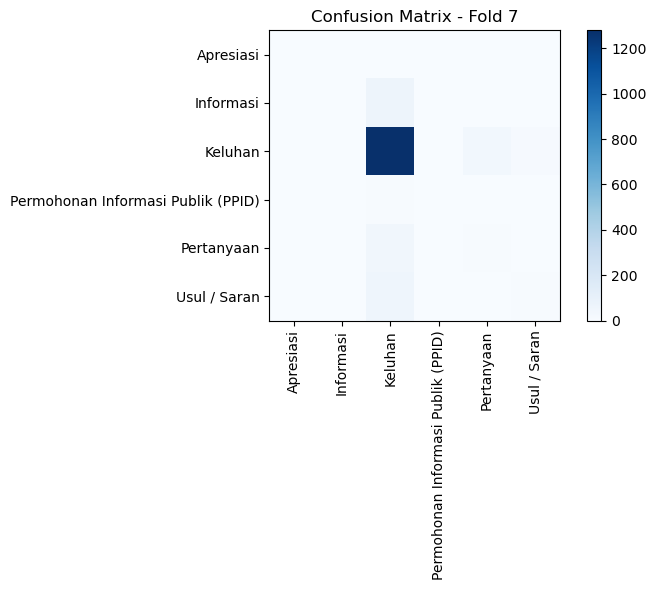

=========Fold :  7 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0    3    0    0    0]
 [   0    0   60    0    2    1]
 [   0    0 1279    1   36   12]
 [   0    0    6    0    1    0]
 [   0    0   42    0    9    0]
 [   0    0   55    0    1    7]]
Accuracy: 0.8547854785478548
Precision: [0.         0.         0.88512111 0.         0.18367347 0.35      ]
Recall: [0.         0.         0.96310241 0.         0.17647059 0.11111111]
F1-Score: [0.         0.         0.92246664 0.         0.18       0.1686747 ]
Processing time 0.039830923080444336
=========Macro Average=========
Precision Macro Avg : 0.23646576277569853
Recall Macro Avg: 0.20844735149749324
F1-Score Macro Avg: 0.2118568902367494
=========Micro Average=========
Precision Micro Avg: 0.8547854785478548
Recall Micro Avg: 0.8547854785478548
F1-Score Micro Avg: 0.8547854785478549
=========Weighted Average=========
Precision Weighted Avg: 0.7966060576822458
Recall Weighted Avg: 0.8547854785478548
F1-Score Weigh

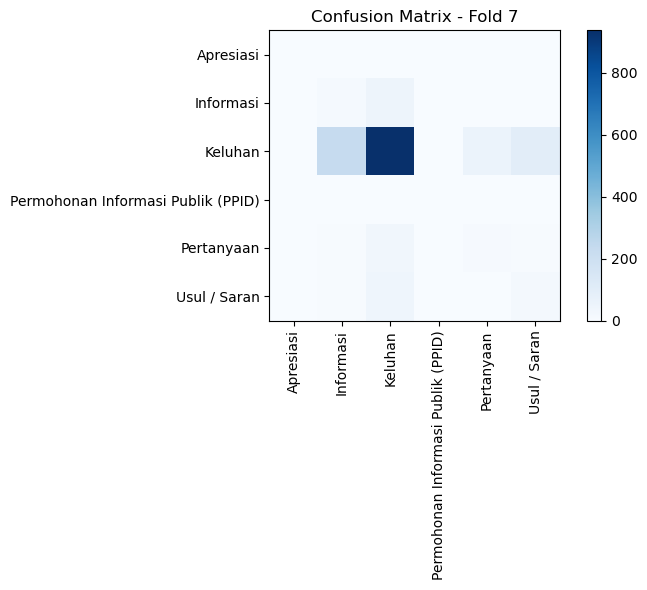

=========Fold :  7 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   2   0   0   1]
 [  0  12  45   1   2   3]
 [  1 234 937   0  58  98]
 [  0   3   3   0   1   0]
 [  0   6  32   0   9   4]
 [  0   6  42   0   0  15]]
Accuracy: 0.6422442244224422
Precision: [0.         0.04597701 0.88312912 0.         0.12857143 0.12396694]
Recall: [0.         0.19047619 0.70557229 0.         0.17647059 0.23809524]
F1-Score: [0.         0.07407407 0.78442863 0.         0.14876033 0.16304348]
Processing time 13.71657109260559
=========Macro Average=========
Precision Macro Avg : 0.1969407509471446
Recall Macro Avg: 0.21843571766055822
F1-Score Macro Avg: 0.1950510856899851
=========Micro Average=========
Precision Micro Avg: 0.6422442244224422
Recall Micro Avg: 0.6422442244224422
F1-Score Micro Avg: 0.6422442244224422
=========Weighted Average=========
Precision Weighted Avg: 0.7855175497707739
Recall Weighted Avg: 0.6422442244224422
F1-Score Weighted Avg: 0.7024728745381765




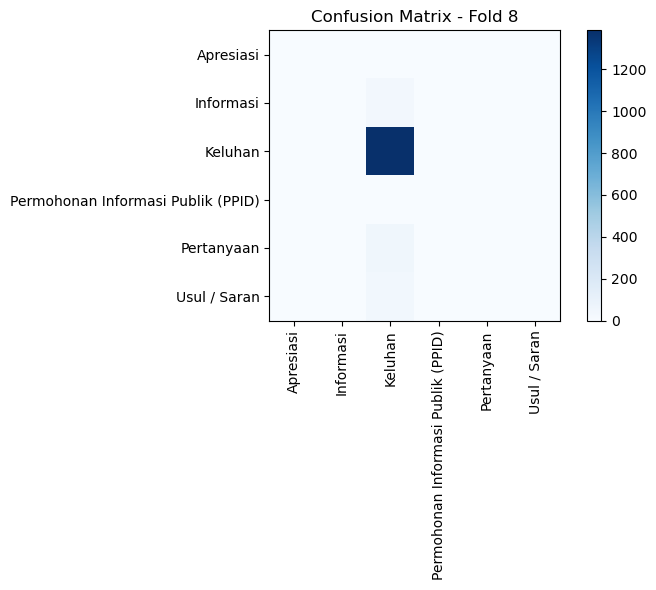

=========Fold :  8 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0    1    0    0    0]
 [   0    0   35    0    0    0]
 [   0    0 1386    0    0    0]
 [   0    0    4    0    0    0]
 [   0    0   49    0    0    0]
 [   0    0   39    0    0    0]]
Accuracy: 0.9154557463672391
Precision: [0.         0.         0.91545575 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.95586207 0.         0.         0.        ]
Processing time 0.03161191940307617
=========Macro Average=========
Precision Macro Avg : 0.1525759577278732
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.1593103448275862
=========Micro Average=========
Precision Micro Avg: 0.9154557463672391
Recall Micro Avg: 0.9154557463672391
F1-Score Micro Avg: 0.9154557463672391
=========Weighted Average=========
Precision Weighted Avg: 0.838059223556799
Recall Weighted Avg: 0.9154557463672391
F1-Score Weighted Avg: 0.8750494237689609




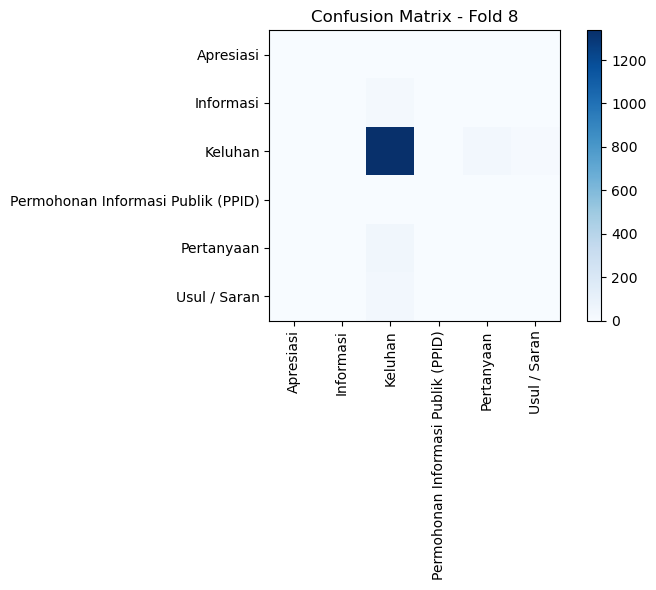

=========Fold :  8 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0    1    0    0    0]
 [   0    0   30    0    3    2]
 [   0    0 1337    0   36   13]
 [   0    0    4    0    0    0]
 [   0    0   44    0    4    1]
 [   0    0   34    0    3    2]]
Accuracy: 0.8870541611624835
Precision: [0.         0.         0.92206897 0.         0.08695652 0.11111111]
Recall: [0.         0.         0.96464646 0.         0.08163265 0.05128205]
F1-Score: [0.         0.         0.94287729 0.         0.08421053 0.07017544]
Processing time 0.035372018814086914
=========Macro Average=========
Precision Macro Avg : 0.18668943306124716
Recall Macro Avg: 0.18292686149829007
F1-Score Macro Avg: 0.18287720947879807
=========Micro Average=========
Precision Micro Avg: 0.8870541611624835
Recall Micro Avg: 0.8870541611624835
F1-Score Micro Avg: 0.8870541611624835
=========Weighted Average=========
Precision Weighted Avg: 0.8497898210736112
Recall Weighted Avg: 0.8870541611624835
F1-Score Weig

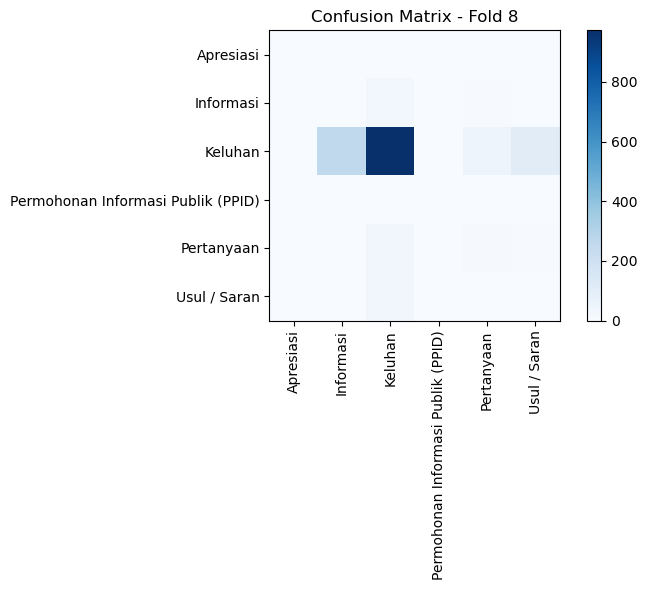

=========Fold :  8 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0   2  25   0   5   3]
 [  0 258 973   0  46 109]
 [  0   0   2   1   1   0]
 [  0   1  33   0  10   5]
 [  0   1  33   0   2   3]]
Accuracy: 0.6532364597093792
Precision: [0.         0.00763359 0.91190253 1.         0.15625    0.025     ]
Recall: [0.         0.05714286 0.7020202  0.25       0.20408163 0.07692308]
F1-Score: [0.         0.01346801 0.79331431 0.4        0.17699115 0.03773585]
Processing time 11.628123044967651
=========Macro Average=========
Precision Macro Avg : 0.3501310197075818
Recall Macro Avg: 0.21502796145653288
F1-Score Macro Avg: 0.2369182203294119
=========Micro Average=========
Precision Micro Avg: 0.6532364597093792
Recall Micro Avg: 0.6532364597093792
F1-Score Micro Avg: 0.6532364597093792
=========Weighted Average=========
Precision Weighted Avg: 0.8433258472846855
Recall Weighted Avg: 0.6532364597093792
F1-Score Weighted Avg: 0.7343126005569779




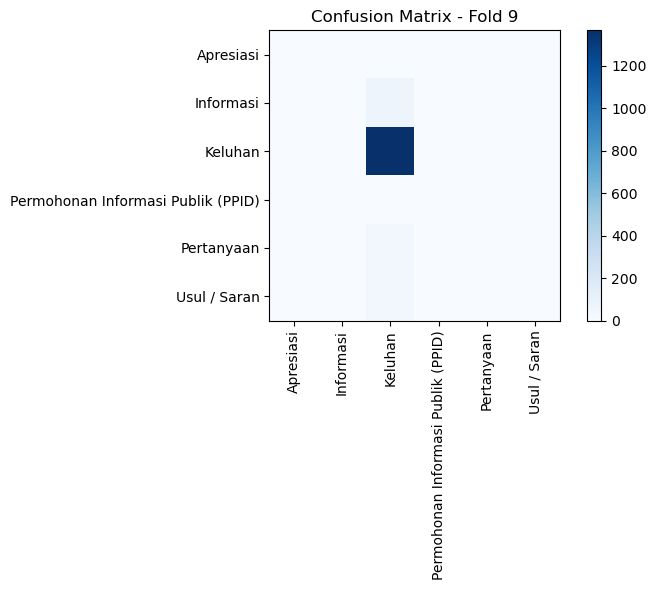

=========Fold :  9 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0    1    0    0    0]
 [   0    0   66    0    0    0]
 [   0    0 1366    0    0    1]
 [   0    0    4    0    0    0]
 [   0    0   42    0    0    0]
 [   0    0   34    0    0    0]]
Accuracy: 0.9022457067371202
Precision: [0.         0.         0.90284204 0.         0.         0.        ]
Recall: [0.         0.         0.99926847 0.         0.         0.        ]
F1-Score: [0.         0.         0.94861111 0.         0.         0.        ]
Processing time 0.028625011444091797
=========Macro Average=========
Precision Macro Avg : 0.15047367261511346
Recall Macro Avg: 0.16654474518410142
F1-Score Macro Avg: 0.15810185185185185
=========Micro Average=========
Precision Micro Avg: 0.9022457067371202
Recall Micro Avg: 0.9022457067371202
F1-Score Micro Avg: 0.9022457067371203
=========Weighted Average=========
Precision Weighted Avg: 0.8151816795172792
Recall Weighted Avg: 0.9022457067371202
F1-Score We

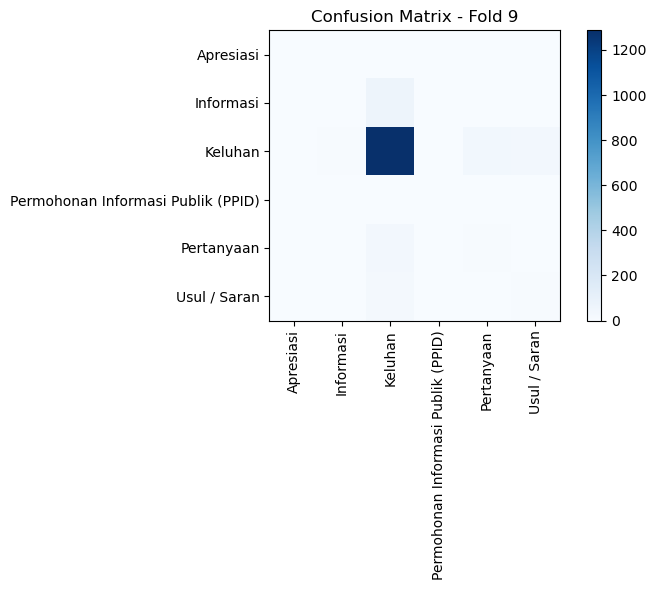

=========Fold :  9 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0    1    0    0    0]
 [   0    0   65    0    1    0]
 [   0    7 1287    1   39   33]
 [   0    0    3    0    1    0]
 [   0    0   35    0    6    1]
 [   0    0   27    0    1    6]]
Accuracy: 0.8579920739762219
Precision: [0.         0.         0.90761636 0.         0.125      0.15      ]
Recall: [0.         0.         0.94147769 0.         0.14285714 0.17647059]
F1-Score: [0.         0.         0.92423698 0.         0.13333333 0.16216216]
Processing time 0.033601999282836914
=========Macro Average=========
Precision Macro Avg : 0.19710272684532204
Recall Macro Avg: 0.2101342365768546
F1-Score Macro Avg: 0.20328874655625104
=========Micro Average=========
Precision Micro Avg: 0.8579920739762219
Recall Micro Avg: 0.8579920739762219
F1-Score Micro Avg: 0.8579920739762219
=========Weighted Average=========
Precision Weighted Avg: 0.8263286430550406
Recall Weighted Avg: 0.8579920739762219
F1-Score Weigh

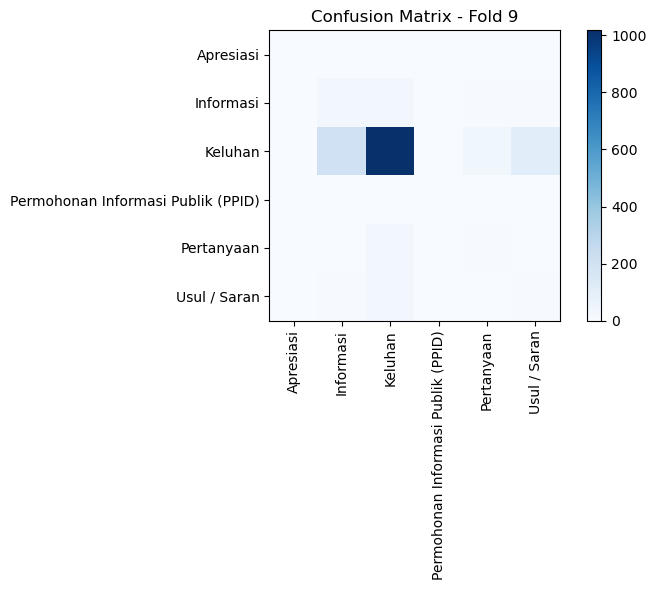

=========Fold :  9 =========
Classifier: GaussianNB
Confusion Matrix:
[[   0    0    1    0    0    0]
 [   0   27   29    0    6    4]
 [   0  203 1018    0   36  110]
 [   0    1    2    0    1    0]
 [   0    3   31    0    5    3]
 [   0    4   24    0    1    5]]
Accuracy: 0.6968295904887715
Precision: [0.         0.11344538 0.92126697 0.         0.10204082 0.04098361]
Recall: [0.         0.40909091 0.74469642 0.         0.11904762 0.14705882]
F1-Score: [0.         0.17763158 0.8236246  0.         0.10989011 0.06410256]
Processing time 11.492743253707886
=========Macro Average=========
Precision Macro Avg : 0.19628946156015994
Recall Macro Avg: 0.23664896119605874
F1-Score Macro Avg: 0.19587480806821633
=========Micro Average=========
Precision Micro Avg: 0.6968295904887715
Recall Micro Avg: 0.6968295904887715
F1-Score Micro Avg: 0.6968295904887715
=========Weighted Average=========
Precision Weighted Avg: 0.8405141991862652
Recall Weighted Avg: 0.6968295904887715
F1-Score Weighte

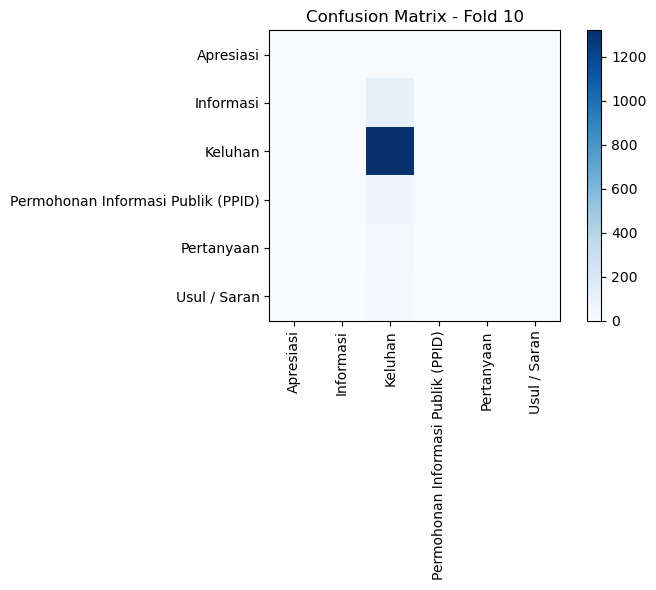

=========Fold :  10 =========
Classifier: MultinomialNB
Confusion Matrix:
[[   0    0    1    0    0    0]
 [   0    0   94    0    0    0]
 [   0    0 1320    0    0    0]
 [   0    0   57    0    0    0]
 [   0    0   25    0    0    0]
 [   0    0   17    0    0    0]]
Accuracy: 0.8718626155878467
Precision: [0.         0.         0.87186262 0.         0.         0.        ]
Recall: [0. 0. 1. 0. 0. 0.]
F1-Score: [0.         0.         0.93154552 0.         0.         0.        ]
Processing time 0.030740022659301758
=========Macro Average=========
Precision Macro Avg : 0.1453104359313078
Recall Macro Avg: 0.16666666666666666
F1-Score Macro Avg: 0.155257586450247
=========Micro Average=========
Precision Micro Avg: 0.8718626155878467
Recall Micro Avg: 0.8718626155878467
F1-Score Micro Avg: 0.8718626155878466
=========Weighted Average=========
Precision Weighted Avg: 0.7601444204596814
Recall Weighted Avg: 0.8718626155878467
F1-Score Weighted Avg: 0.8121797124742115




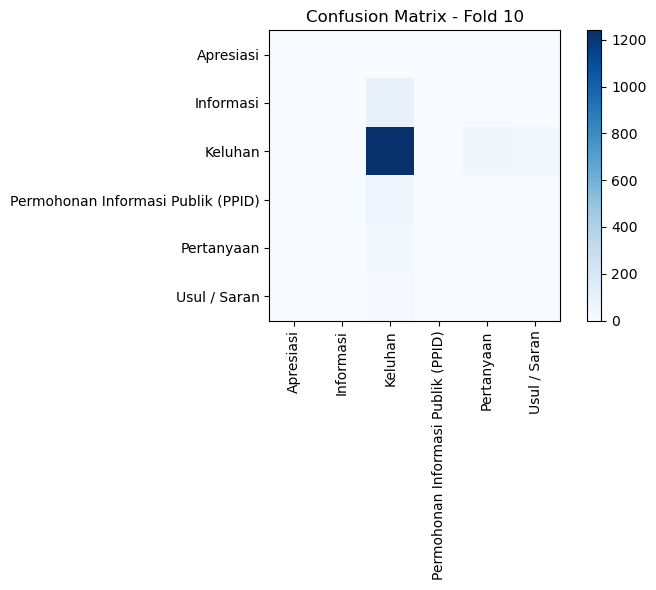

=========Fold :  10 =========
Classifier: BernoulliNB
Confusion Matrix:
[[   0    0    1    0    0    0]
 [   0    0   89    0    5    0]
 [   0    7 1241    0   42   30]
 [   0    0   50    0    7    0]
 [   0    0   24    0    1    0]
 [   0    0   12    0    1    4]]
Accuracy: 0.8229854689564069
Precision: [0.         0.         0.87579393 0.         0.01785714 0.11764706]
Recall: [0.         0.         0.94015152 0.         0.04       0.23529412]
F1-Score: [0.         0.         0.9068323  0.         0.02469136 0.15686275]
Processing time 0.03569293022155762
=========Macro Average=========
Precision Macro Avg : 0.16854968875341245
Recall Macro Avg: 0.20257427213309567
F1-Score Macro Avg: 0.1813977335432294
=========Micro Average=========
Precision Micro Avg: 0.8229854689564069
Recall Micro Avg: 0.8229854689564069
F1-Score Micro Avg: 0.8229854689564069
=========Weighted Average=========
Precision Weighted Avg: 0.7651878581769933
Recall Weighted Avg: 0.8229854689564069
F1-Score Weigh

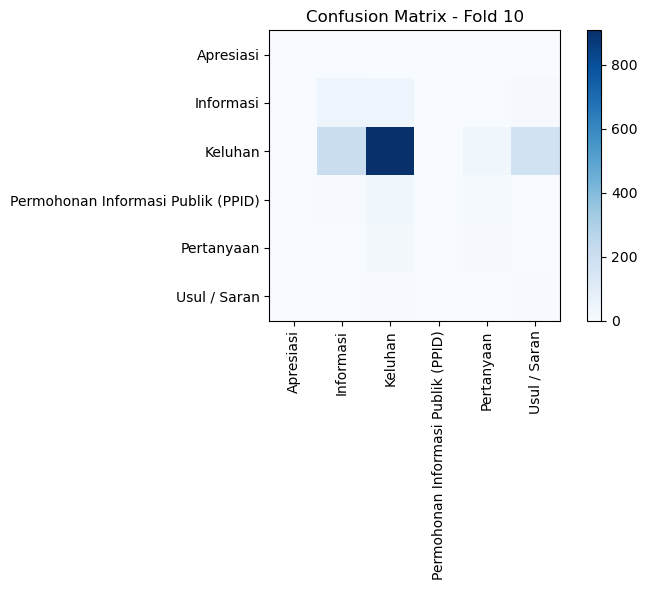

=========Fold :  10 =========
Classifier: GaussianNB
Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0  43  41   0   1   9]
 [  2 202 908   0  35 173]
 [  0   5  35   1  14   2]
 [  0   1  15   0   8   1]
 [  0   2   7   0   2   6]]
Accuracy: 0.6380449141347424
Precision: [0.         0.16996047 0.90168818 1.         0.13333333 0.03141361]
Recall: [0.         0.45744681 0.68787879 0.01754386 0.32       0.35294118]
F1-Score: [0.         0.24783862 0.78040395 0.03448276 0.18823529 0.05769231]
Processing time 11.356724977493286
=========Macro Average=========
Precision Macro Avg : 0.3727326004880054
Recall Macro Avg: 0.3059684387515229
F1-Score Macro Avg: 0.21810882178894217
=========Micro Average=========
Precision Micro Avg: 0.6380449141347424
Recall Micro Avg: 0.6380449141347424
F1-Score Micro Avg: 0.6380449141347424
=========Weighted Average=========
Precision Weighted Avg: 0.8369036000816278
Recall Weighted Avg: 0.6380449141347424
F1-Score Weighted Avg: 0.7008469072211639




In [ ]:
# Loop through each fold cross validation

#Init Fold
fold_array = [kf5, kf10]

#Init Data Deskripsi
data_deskripsi_array = [deskripsi_25, deskripsi_50, deskripsi_75, deskripsi_100] #

#Init Data Preprocess
data_preprocess_array = [data_preprocess_25, data_preprocess_50, data_preprocess_75, data_preprocess_100] #

i=0
for data_preprocess in data_preprocess_array:
    
    j=0
    for data_fold in fold_array:
        print(f"======{data_fold.n_splits}-FOLD CROSS VALIDATION FOR {'25' if i==0 else '50' if i==1 else '75' if i==2 else '100'}% DATA======")
        print(f"K-Fold = {data_fold.n_splits}")
        print(f"Data Deskripsi Array Len = {len(data_deskripsi_array[i])}")
        print(f"Data Pre-process Array Len = {len(data_preprocess)}")
        
        k=1
        for train_index, test_index in data_fold.split(data_preprocess):
            #Do classification
            classification(data_deskripsi_array[i], train_index, test_index, k)

            #Add k for each fold
            k = k+1;
        j=j+1;
    i=i+1;